# Poisson 2d
---

Consider the 2d Poisson Equation
\begin{equation}
\begin{aligned}
&\nabla \cdot (\sigma \nabla u) = 0, \\
&\sigma u|_{\partial\Omega} = g, \\
\end{aligned}
\end{equation}
where the domain $\Omega = [0, 1]\times [0, 1]$, and the target field $\sigma(x, y)\equiv 1$.
$g$ is chosen such that the exact solution is
\begin{equation}
u(x, y) = \exp(\pi y)\sin(\pi x).
\end{equation}

For the inverse problem, Dirichlet measurements are provided on the boundary.

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("./"))))

import torch
import torch.nn as nn
import numpy as np

from pinn_lightning.pinn import PINN, InversePINN, Task
from pinn_lightning.data.dataset import PINNDataModule
from pinn_lightning.data.utils import tensor_grid, tensors_from_numpy
from pinn_lightning.utils.basic_nets import *
from pinn_lightning.utils.operators import grad, directional_grad

import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config Completer.use_jedi = False

import random
torch.manual_seed(1001)
np.random.seed(1001)
random.seed(1001)

torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

# Step 1: Define Model

In [2]:
class Poisson2d(InversePINN):	
	def get_output(self, batch_input):
		(x_domain, y_domain), (x_n, y_n, normal), (x_d, y_d) = batch_input  # x_n: neumann BC; x_d: dirichlet measurements
		x_domain.requires_grad = True
		y_domain.requires_grad = True
		u_domain = self.forward(torch.hstack([x_domain, y_domain]))
		sigma_domain = self.inverse_module(torch.hstack([x_domain, y_domain]))
		eq = grad(grad(u_domain, x_domain)*sigma_domain, x_domain) + \
			grad(grad(u_domain, y_domain)*sigma_domain, y_domain)
		
		x_n.requires_grad = True
		y_n.requires_grad = True
		u_n = self.forward(torch.hstack([x_n, y_n]))
		u_grad = directional_grad(u_n, x_n, y_n, direction=normal)
		sigma_n = self.inverse_module(torch.hstack([x_n, y_n]))
		
		u_d = self.forward(torch.hstack([x_d, y_d]))
		return eq, u_grad*sigma_n, u_d

forward_module = DenseNet(
	[2] + [128]*6 + [1], Swish,
)
inverse_module = DenseNet(
	[2] + [32]*2 + [1], Swish,
)

pinn = Poisson2d(forward_module, inverse_module)
pinn.configure_tasks(
	[
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 1.0,
			name = "domain",
		),
		Task(
			n_input = 3,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 100.0,
			name = "neumann",
		),
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 100.0,
			name = "dirichlet",
		),
	]
)
optimizer = torch.optim.Adam(
	[
		{
			"params": pinn.param_groups[0],
			"lr": 1e-3,
			"weight_decay": 1e-6
		},
		{
			"params": pinn.param_groups[1],
			"lr": 1e-3,
			"weight_decay": 0,
		},
	]
)
pinn.configure_optimizers_and_schedulers(
	optimizer = optimizer,
	lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
		optimizer,
		factor = 0.8,
		patience = 100,
		threshold = 1e-6,
		min_lr = 1e-4,
	),
)
pinn

Poisson2d(
  (forward_module): DenseNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Swish()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Swish()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Swish()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): Swish()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): Swish()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): Swish()
      (12): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (inverse_module): DenseNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Swish()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Swish()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

# Step 2: Generate Dataset

In [3]:
x_1d = np.linspace(0, 1, 99).reshape((-1, 1))
y_1d = np.linspace(0, 1, 101).reshape((-1, 1))
xy = tensor_grid([x_1d, y_1d])
x_domain, y_domain = xy[:, 0:1], xy[:, 1:2]
u_domain = np.zeros_like(x_domain)

x_bc_1d = np.linspace(0, 1, 1001).reshape((-1, 1))
y_bc_1d = np.linspace(0, 1, 999).reshape((-1, 1))
xy_bc = np.vstack(
	[
		np.hstack([x_bc_1d, 0*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), y_bc_1d]),
		np.hstack([x_bc_1d, np.ones_like(x_bc_1d)]),
		np.hstack([0*np.ones_like(y_bc_1d), y_bc_1d]),
	]
)
normal = np.vstack(
	[
		np.hstack([np.zeros_like(x_bc_1d), -1*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), np.zeros_like(y_bc_1d)]),
		np.hstack([np.zeros_like(x_bc_1d), np.ones_like(x_bc_1d)]),
		np.hstack([-np.ones_like(y_bc_1d), np.zeros_like(y_bc_1d)]),
	]
)
x_d, y_d = xy_bc[:, 0:1], xy_bc[:, 1:2]
u_fn = lambda x, y: np.exp(np.pi*y)*np.sin(np.pi*x)
u_d = u_fn(x_d, y_d)

x_n, y_n = x_d, y_d
du_dx_fn = lambda x, y: np.pi*np.exp(np.pi*y)*np.cos(np.pi*x)
du_dy_fn = lambda x, y: np.pi*np.exp(np.pi*y)*np.sin(np.pi*x)
u_n = du_dx_fn(x_n, y_n)*normal[:, 0:1] + du_dy_fn(x_n, y_n)*normal[:, 1:2]

In [4]:
dataset_domain = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_domain, y_domain, u_domain),
)
dataset_n = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_n, y_n, normal, u_n),
)
dataset_d = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_d, y_d, u_d),
)

poisson_data_module = PINNDataModule(
	datasets = [dataset_domain, dataset_n, dataset_d],
	collate_fns = [None, None, None],
	valid_splits = [0.2, 0.2, 0.2],
	batch_sizes = [40000, 4000, 4000],
)

# Step 3: training

In [5]:
trainer = pl.Trainer(
	max_epochs=20000,
	gpus=1,
	logger=True,
	callbacks=[
		pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10000),
        pl.callbacks.ModelCheckpoint(dirpath="models", save_last=True, save_top_k=1),
		pl.callbacks.LearningRateMonitor(logging_interval='step')
	],
	log_every_n_steps=10,
)
trainer.fit(
	pinn,
	poisson_data_module,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/chuan/GitHub/PINN_lightning/examples/example_2_Poisson_2d_inverse/lightning_logs

  | Name           | Type     | Params
--------------------------------------------
0 | forward_module | DenseNet | 83.1 K
1 | inverse_module | DenseNet | 1.2 K 
--------------------------------------------
84.3 K    Trainable params
0         Non-trainable params
84.3 K    Total params
0.337     Total estimated model params size (MB)


/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1999. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: : 0it [00:00, ?it/s]

/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8000. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: : 1it [00:00,  3.15it/s, loss=1.16e+05, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 0: : 3it [00:00,  6.51it/s, loss=1.16e+05, v_num=0]
Epoch 1: : 2it [00:00,  7.18it/s, loss=1.16e+05, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1: : 3it [00:00,  7.22it/s, loss=1.16e+05, v_num=0]
Epoch 2: : 2it [00:00,  7.21it/s, loss=1.16e+05, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2: : 3it [00:00,  7.06it/s, loss=1.16e+05, v_num=0]
Epoch 3: : 2it [00:00,  6.41it/s, loss=1.16e+05, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3: : 3it [00:00,  6.67it/s, loss=1.16e+05, v_num=0]
Epoch 4: : 2it [00:00,  7.15it/s, loss=1.16e+05, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4: : 3it [00:00,  6.98it/s, loss=1.16e+05, v_num=0]
Epoch 5: : 2it [00:00,  6.75it/s, loss=1.16e+05, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:0

Epoch 50: : 3it [00:00,  7.32it/s, loss=7e+04, v_num=0]
Epoch 51: : 2it [00:00,  5.49it/s, loss=6.81e+04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 51: : 3it [00:00,  6.57it/s, loss=6.81e+04, v_num=0]
Epoch 52: : 2it [00:00,  5.56it/s, loss=6.62e+04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 52: : 3it [00:00,  6.72it/s, loss=6.62e+04, v_num=0]
Epoch 53: : 2it [00:00,  5.65it/s, loss=6.46e+04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 53: : 3it [00:00,  6.81it/s, loss=6.46e+04, v_num=0]
Epoch 54: : 2it [00:00,  5.37it/s, loss=6.31e+04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 54: : 3it [00:00,  6.44it/s, loss=6.31e+04, v_num=0]
Epoch 55: : 2it [00:00,  5.34it/s, loss=6.18e+04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 55: : 3it [00:00,  6.41it/s, loss=6.18e+04, v_num=0]
Epoch 56: : 2it [00:00,  5.62it/s, loss=6.07e+04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 56: : 3it [00:00,  6.65it/s, loss=6.07e+04, v_num=0]
Epoch 57: : 2it [00:00,  5.58it/s, loss=5.98e+04, 

Epoch 101: : 3it [00:00,  6.79it/s, loss=8.76e+03, v_num=0]
Epoch 102: : 2it [00:00,  5.24it/s, loss=8.5e+03, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 102: : 3it [00:00,  6.59it/s, loss=8.5e+03, v_num=0]
Epoch 103: : 2it [00:00,  5.67it/s, loss=8.21e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 103: : 3it [00:00,  6.78it/s, loss=8.21e+03, v_num=0]
Epoch 104: : 2it [00:00,  5.69it/s, loss=8.05e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 104: : 3it [00:00,  6.98it/s, loss=8.05e+03, v_num=0]
Epoch 105: : 2it [00:00,  5.44it/s, loss=7.75e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 105: : 3it [00:00,  6.80it/s, loss=7.75e+03, v_num=0]
Epoch 106: : 2it [00:00,  5.58it/s, loss=7.49e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 106: : 3it [00:00,  6.70it/s, loss=7.49e+03, v_num=0]
Epoch 107: : 2it [00:00,  5.37it/s, loss=7.32e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 107: : 3it [00:00,  6.39it/s, loss=7.32e+03, v_num=0]
Epoch 108: : 2it [00:00,  5.37it/s,

Epoch 152: : 2it [00:00,  5.53it/s, loss=2.53e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 152: : 3it [00:00,  6.59it/s, loss=2.53e+03, v_num=0]
Epoch 153: : 2it [00:00,  5.77it/s, loss=2.46e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 153: : 3it [00:00,  7.15it/s, loss=2.46e+03, v_num=0]
Epoch 154: : 2it [00:00,  5.39it/s, loss=2.39e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 154: : 3it [00:00,  6.39it/s, loss=2.39e+03, v_num=0]
Epoch 155: : 2it [00:00,  5.52it/s, loss=2.32e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 155: : 3it [00:00,  6.88it/s, loss=2.32e+03, v_num=0]
Epoch 156: : 2it [00:00,  5.75it/s, loss=2.25e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 156: : 3it [00:00,  6.96it/s, loss=2.25e+03, v_num=0]
Epoch 157: : 2it [00:00,  5.33it/s, loss=2.18e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 157: : 3it [00:00,  6.33it/s, loss=2.18e+03, v_num=0]
Epoch 158: : 2it [00:00,  5.58it/s, loss=2.12e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 204: : 3it [00:00,  7.09it/s, loss=1.43e+03, v_num=0]
Epoch 205: : 2it [00:00,  6.72it/s, loss=1.39e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 205: : 3it [00:00,  6.71it/s, loss=1.39e+03, v_num=0]
Epoch 206: : 2it [00:00,  7.00it/s, loss=1.32e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 206: : 3it [00:00,  6.82it/s, loss=1.32e+03, v_num=0]
Epoch 207: : 2it [00:00,  7.14it/s, loss=1.24e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 207: : 3it [00:00,  7.24it/s, loss=1.24e+03, v_num=0]
Epoch 208: : 2it [00:00,  7.21it/s, loss=1.21e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 208: : 3it [00:00,  7.28it/s, loss=1.21e+03, v_num=0]
Epoch 209: : 2it [00:00,  6.72it/s, loss=1.13e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 209: : 3it [00:00,  6.64it/s, loss=1.13e+03, v_num=0]
Epoch 210: : 2it [00:00,  6.37

Epoch 259: : 2it [00:00,  5.66it/s, loss=394, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 259: : 3it [00:00,  6.78it/s, loss=394, v_num=0]
Epoch 260: : 2it [00:00,  5.46it/s, loss=389, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 260: : 3it [00:00,  6.41it/s, loss=389, v_num=0]
Epoch 261: : 2it [00:00,  5.83it/s, loss=384, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 261: : 3it [00:00,  6.91it/s, loss=384, v_num=0]
Epoch 262: : 2it [00:00,  5.31it/s, loss=379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 262: : 3it [00:00,  6.60it/s, loss=379, v_num=0]
Epoch 263: : 2it [00:00,  5.66it/s, loss=374, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 263: : 3it [00:00,  6.75it/s, loss=374, v_num=0]
Epoch 264: : 2it [00:00,  5.60it/s, loss=369, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 264: : 3it [00:00,  6.77it/s, loss=369, v_num=0]
Epoch 265: : 2it [00:00,  5.74it/s, loss=364, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 265: : 3it [00:00,  6.91it/s, loss=364, v_num=0]
Epoch 266: : 

Epoch 313: : 2it [00:00,  5.77it/s, loss=223, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 313: : 3it [00:00,  6.90it/s, loss=223, v_num=0]
Epoch 314: : 2it [00:00,  5.82it/s, loss=221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 314: : 3it [00:00,  6.98it/s, loss=221, v_num=0]
Epoch 315: : 2it [00:00,  5.47it/s, loss=219, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 315: : 3it [00:00,  6.54it/s, loss=219, v_num=0]
Epoch 316: : 2it [00:00,  5.53it/s, loss=217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 316: : 3it [00:00,  6.62it/s, loss=217, v_num=0]
Epoch 317: : 2it [00:00,  5.60it/s, loss=216, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 317: : 3it [00:00,  6.87it/s, loss=216, v_num=0]
Epoch 318: : 2it [00:00,  5.27it/s, loss=214, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 318: : 3it [00:00,  6.51it/s, loss=214, v_num=0]
Epoch 319: : 2it [00:00,  5.71it/s, loss=212, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 319: : 3it [00:00,  6.81it/s, loss=212, v_num=0]
Epoch 320: : 

Epoch 367: : 2it [00:00,  4.89it/s, loss=159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 367: : 3it [00:00,  6.11it/s, loss=159, v_num=0]
Epoch 368: : 2it [00:00,  5.45it/s, loss=158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 368: : 3it [00:00,  6.63it/s, loss=158, v_num=0]
Epoch 369: : 2it [00:00,  5.63it/s, loss=157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 369: : 3it [00:00,  6.94it/s, loss=157, v_num=0]
Epoch 370: : 2it [00:00,  5.47it/s, loss=156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 370: : 3it [00:00,  6.58it/s, loss=156, v_num=0]
Epoch 371: : 2it [00:00,  5.82it/s, loss=156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 371: : 3it [00:00,  7.20it/s, loss=156, v_num=0]
Epoch 372: : 2it [00:00,  5.72it/s, loss=155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 372: : 3it [00:00,  6.99it/s, loss=155, v_num=0]
Epoch 373: : 2it [00:00,  5.75it/s, loss=154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 373: : 3it [00:00,  6.74it/s, loss=154, v_num=0]
Epoch 374: : 

Epoch 421: : 2it [00:00,  5.87it/s, loss=127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 421: : 3it [00:00,  7.26it/s, loss=127, v_num=0]
Epoch 422: : 2it [00:00,  5.31it/s, loss=127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 422: : 3it [00:00,  6.67it/s, loss=127, v_num=0]
Epoch 423: : 2it [00:00,  5.53it/s, loss=127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 423: : 3it [00:00,  6.59it/s, loss=127, v_num=0]
Epoch 424: : 2it [00:00,  5.83it/s, loss=126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 424: : 3it [00:00,  7.00it/s, loss=126, v_num=0]
Epoch 425: : 2it [00:00,  5.63it/s, loss=126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 425: : 3it [00:00,  6.68it/s, loss=126, v_num=0]
Epoch 426: : 2it [00:00,  5.28it/s, loss=125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 426: : 3it [00:00,  6.39it/s, loss=125, v_num=0]
Epoch 427: : 2it [00:00,  5.41it/s, loss=125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 427: : 3it [00:00,  6.72it/s, loss=125, v_num=0]
Epoch 428: : 

Epoch 475: : 3it [00:00,  6.74it/s, loss=108, v_num=0]
Epoch 476: : 2it [00:00,  6.38it/s, loss=108, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 476: : 3it [00:00,  6.39it/s, loss=108, v_num=0]
Epoch 477: : 2it [00:00,  6.99it/s, loss=107, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 477: : 3it [00:00,  6.77it/s, loss=107, v_num=0]
Epoch 478: : 2it [00:00,  7.04it/s, loss=107, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 478: : 3it [00:00,  6.77it/s, loss=107, v_num=0]
Epoch 479: : 2it [00:00,  6.82it/s, loss=107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 479: : 3it [00:00,  7.75it/s, loss=107, v_num=0]
Epoch 480: : 2it [00:00,  5.42it/s, loss=106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 480: : 3it [00:00,  6.53it/s, loss=106, v_num=0]
Epoch 481: : 2it [00:00,  5.67it/s, loss=106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 481: : 3it [00:00,  6.70it/s, loss=106, v_num=0]
Epoch 

Validating: 0it [00:00, ?it/s]
Epoch 531: : 3it [00:00,  7.21it/s, loss=92, v_num=0]
Epoch 532: : 2it [00:00,  5.76it/s, loss=91.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 532: : 3it [00:00,  7.13it/s, loss=91.8, v_num=0]
Epoch 533: : 2it [00:00,  6.77it/s, loss=91.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 533: : 3it [00:00,  6.81it/s, loss=91.5, v_num=0]
Epoch 534: : 2it [00:00,  6.70it/s, loss=91.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 534: : 3it [00:00,  6.77it/s, loss=91.3, v_num=0]
Epoch 535: : 2it [00:00,  7.23it/s, loss=91, v_num=0]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 535: : 3it [00:00,  7.00it/s, loss=91, v_num=0]
Epoch 536: : 2it [00:00,  7.18it/s, loss=90.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 536: : 3it [00:00,  7.05it/s, loss=90.7, v_num=0]
Epoch 537: : 2it [00:00,  6.64it/s, loss=90.5, v_num=0]
Validating: 0it [00:00

Epoch 584: : 3it [00:00,  6.80it/s, loss=79.1, v_num=0]
Epoch 585: : 2it [00:00,  5.70it/s, loss=78.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 585: : 3it [00:00,  7.11it/s, loss=78.9, v_num=0]
Epoch 586: : 2it [00:00,  5.19it/s, loss=78.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 586: : 3it [00:00,  6.54it/s, loss=78.6, v_num=0]
Epoch 587: : 2it [00:00,  5.44it/s, loss=78.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 587: : 3it [00:00,  6.53it/s, loss=78.4, v_num=0]
Epoch 588: : 2it [00:00,  5.28it/s, loss=78.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 588: : 3it [00:00,  6.42it/s, loss=78.2, v_num=0]
Epoch 589: : 2it [00:00,  5.31it/s, loss=78, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 589: : 3it [00:00,  6.72it/s, loss=78, v_num=0]
Epoch 590: : 2it [00:00,  5.81it/s, loss=77.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 590: : 3it [00:00,  7.24it/s, loss=77.7, v_num=0]
Epoch 591: : 2it [00:00,  5.38it/s, loss=77.6, v_num=0]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 638: : 3it [00:00,  6.78it/s, loss=165, v_num=0]
Epoch 639: : 2it [00:00,  5.68it/s, loss=163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 639: : 3it [00:00,  7.09it/s, loss=163, v_num=0]
Epoch 640: : 2it [00:00,  5.44it/s, loss=155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 640: : 3it [00:00,  6.59it/s, loss=155, v_num=0]
Epoch 641: : 2it [00:00,  5.46it/s, loss=142, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 641: : 3it [00:00,  6.63it/s, loss=142, v_num=0]
Epoch 642: : 2it [00:00,  5.70it/s, loss=139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 642: : 3it [00:00,  6.76it/s, loss=139, v_num=0]
Epoch 643: : 2it [00:00,  5.33it/s, loss=134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 643: : 3it [00:00,  6.58it/s, loss=134, v_num=0]
Epoch 644: : 2it [00:00,  5.69it/s, loss=124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 644: : 3it [00:00,  7.11it/s, loss=124, v_num=0]
Epoch 645: : 2it [00:00,  5.44it/s, loss=121, v_num=0]
Validating: 0

Epoch 691: : 3it [00:00,  6.92it/s, loss=61.6, v_num=0]
Epoch 692: : 2it [00:00,  5.51it/s, loss=61.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 692: : 3it [00:00,  6.74it/s, loss=61.3, v_num=0]
Epoch 693: : 2it [00:00,  5.58it/s, loss=61.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 693: : 3it [00:00,  6.61it/s, loss=61.1, v_num=0]
Epoch 694: : 2it [00:00,  5.75it/s, loss=60.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 694: : 3it [00:00,  7.13it/s, loss=60.8, v_num=0]
Epoch 695: : 2it [00:00,  5.35it/s, loss=60.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 695: : 3it [00:00,  6.48it/s, loss=60.5, v_num=0]
Epoch 696: : 2it [00:00,  5.73it/s, loss=60.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 696: : 3it [00:00,  6.83it/s, loss=60.3, v_num=0]
Epoch 697: : 2it [00:00,  5.75it/s, loss=60.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 697: : 3it [00:00,  7.05it/s, loss=60.1, v_num=0]
Epoch 698: : 2it [00:00,  5.36it/s, loss=59.8, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 744: : 3it [00:00,  6.67it/s, loss=51.1, v_num=0]
Epoch 745: : 2it [00:00,  7.09it/s, loss=50.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 745: : 3it [00:00,  8.31it/s, loss=50.9, v_num=0]
Epoch 746: : 2it [00:00,  5.81it/s, loss=50.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 746: : 3it [00:00,  6.89it/s, loss=50.7, v_num=0]
Epoch 747: : 2it [00:00,  5.62it/s, loss=50.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 747: : 3it [00:00,  6.53it/s, loss=50.6, v_num=0]
Epoch 748: : 2it [00:00,  5.62it/s, loss=50.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 748: : 3it [00:00,  6.82it/s, loss=50.4, v_num=0]
Epoch 749: : 2it [00:00,  5.73it/s, loss=50.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 749: : 3it [00:00,  6.89it/s, loss=50.3, v_num=0]
Epoch 750: : 2it [00:00,  5.50it/s, loss=50.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 750: : 3it [00:00,  6.61it/s, loss=50.1, v_num=0]
Epoch 751: : 2it [00:00,  5.95it/s, loss=50, v_num=0]  
Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 800: : 3it [00:00,  7.07it/s, loss=43.2, v_num=0]
Epoch 801: : 2it [00:00,  6.88it/s, loss=43.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 801: : 3it [00:00,  7.02it/s, loss=43.1, v_num=0]
Epoch 802: : 2it [00:00,  6.34it/s, loss=43, v_num=0]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 802: : 3it [00:00,  6.40it/s, loss=43, v_num=0]
Epoch 803: : 2it [00:00,  6.73it/s, loss=42.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 803: : 3it [00:00,  6.68it/s, loss=42.9, v_num=0]
Epoch 804: : 2it [00:00,  7.11it/s, loss=42.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 804: : 3it [00:00,  6.90it/s, loss=42.8, v_num=0]
Epoch 805: : 2it [00:00,  7.13it/s, loss=42.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 805: : 3it [00:00,  7.15it/s, loss=42.7, v_num=0]
Epoch 806: : 2

Epoch 854: : 2it [00:00,  5.29it/s, loss=216, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 854: : 3it [00:00,  6.43it/s, loss=216, v_num=0]
Epoch 855: : 2it [00:00,  5.58it/s, loss=192, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 855: : 3it [00:00,  6.74it/s, loss=192, v_num=0]
Epoch 856: : 2it [00:00,  5.66it/s, loss=174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 856: : 3it [00:00,  6.86it/s, loss=174, v_num=0]
Epoch 857: : 2it [00:00,  5.88it/s, loss=172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 857: : 3it [00:00,  7.01it/s, loss=172, v_num=0]
Epoch 858: : 2it [00:00,  5.72it/s, loss=167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 858: : 3it [00:00,  6.81it/s, loss=167, v_num=0]
Epoch 859: : 2it [00:00,  5.52it/s, loss=151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 859: : 3it [00:00,  6.63it/s, loss=151, v_num=0]
Epoch 860: : 2it [00:00,  5.50it/s, loss=131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 860: : 3it [00:00,  6.65it/s, loss=131, v_num=0]
Epoch 861: : 

Validating: 0it [00:00, ?it/s]
Epoch 907: : 3it [00:00,  6.66it/s, loss=35.2, v_num=0]
Epoch 908: : 2it [00:00,  5.67it/s, loss=35, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 908: : 3it [00:00,  6.68it/s, loss=35, v_num=0]
Epoch 909: : 2it [00:00,  5.19it/s, loss=34.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 909: : 3it [00:00,  6.41it/s, loss=34.9, v_num=0]
Epoch 910: : 2it [00:00,  5.91it/s, loss=34.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 910: : 3it [00:00,  6.98it/s, loss=34.8, v_num=0]
Epoch 911: : 2it [00:00,  5.85it/s, loss=34.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 911: : 3it [00:00,  7.23it/s, loss=34.6, v_num=0]
Epoch 912: : 2it [00:00,  4.84it/s, loss=34.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 912: : 3it [00:00,  5.92it/s, loss=34.5, v_num=0]
Epoch 913: : 2it [00:00,  5.79it/s, loss=34.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 913: : 3it [00:00,  6.72it/s, loss=34.3, v_num=0]
Epoch 914: : 2it [00:00,  5.22it/s, loss=34.1, v_num=0]
V

Validating: 0it [00:00, ?it/s]
Epoch 960: : 3it [00:00,  7.12it/s, loss=30.4, v_num=0]
Epoch 961: : 2it [00:00,  5.89it/s, loss=30.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 961: : 3it [00:00,  6.99it/s, loss=30.4, v_num=0]
Epoch 962: : 2it [00:00,  5.60it/s, loss=30.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 962: : 3it [00:00,  7.01it/s, loss=30.3, v_num=0]
Epoch 963: : 2it [00:00,  5.71it/s, loss=30.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 963: : 3it [00:00,  7.09it/s, loss=30.3, v_num=0]
Epoch 964: : 2it [00:00,  5.54it/s, loss=30.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 964: : 3it [00:00,  6.51it/s, loss=30.3, v_num=0]
Epoch 965: : 2it [00:00,  5.52it/s, loss=30.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 965: : 3it [00:00,  6.58it/s, loss=30.2, v_num=0]
Epoch 966: : 2it [00:00,  5.69it/s, loss=30.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 966: : 3it [00:00,  7.03it/s, loss=30.2, v_num=0]
Epoch 967: : 2it [00:00,  5.52it/s, loss=30.2, v_num=0]

Validating: 0it [00:00, ?it/s]
Epoch 1014: : 3it [00:00,  6.80it/s, loss=76, v_num=0]
Epoch 1015: : 2it [00:00,  5.91it/s, loss=68.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1015: : 3it [00:00,  7.32it/s, loss=68.2, v_num=0]
Epoch 1016: : 2it [00:00,  5.58it/s, loss=60.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1016: : 3it [00:00,  6.71it/s, loss=60.6, v_num=0]
Epoch 1017: : 2it [00:00,  5.66it/s, loss=55.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1017: : 3it [00:00,  6.97it/s, loss=55.1, v_num=0]
Epoch 1018: : 2it [00:00,  5.63it/s, loss=52.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1018: : 3it [00:00,  6.63it/s, loss=52.8, v_num=0]
Epoch 1019: : 2it [00:00,  5.81it/s, loss=52.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1019: : 3it [00:00,  6.99it/s, loss=52.5, v_num=0]
Epoch 1020: : 2it [00:00,  5.68it/s, loss=51.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1020: : 3it [00:00,  6.82it/s, loss=51.5, v_num=0]
Epoch 1021: : 2it [00:00,  5.23it/s, loss=48

Epoch 1068: : 3it [00:00,  6.75it/s, loss=25.5, v_num=0]
Epoch 1069: : 2it [00:00,  6.87it/s, loss=25.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1069: : 3it [00:00,  6.80it/s, loss=25.4, v_num=0]
Epoch 1070: : 2it [00:00,  6.77it/s, loss=25.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1070: : 3it [00:00,  6.74it/s, loss=25.3, v_num=0]
Epoch 1071: : 2it [00:00,  7.18it/s, loss=25.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1071: : 3it [00:00,  7.20it/s, loss=25.3, v_num=0]
Epoch 1072: : 2it [00:00,  6.57it/s, loss=25.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1072: : 3it [00:00,  6.53it/s, loss=25.2, v_num=0]
Epoch 1073: : 2it [00:00,  6.87it/s, loss=25.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1073: : 3it [00:00,  6.77it/s, loss=25.1, v_num=0]
Epoch 1074: : 2it [00:00,  6.95it/s, loss=25, v_num=0]  
Valida

Epoch 1122: : 2it [00:00,  5.60it/s, loss=68.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1122: : 3it [00:00,  6.95it/s, loss=68.2, v_num=0]
Epoch 1123: : 2it [00:00,  5.66it/s, loss=65.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1123: : 3it [00:00,  7.05it/s, loss=65.8, v_num=0]
Epoch 1124: : 2it [00:00,  5.79it/s, loss=65.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1124: : 3it [00:00,  6.99it/s, loss=65.9, v_num=0]
Epoch 1125: : 2it [00:00,  5.50it/s, loss=65.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1125: : 3it [00:00,  6.86it/s, loss=65.5, v_num=0]
Epoch 1126: : 2it [00:00,  5.52it/s, loss=62.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1126: : 3it [00:00,  6.91it/s, loss=62.5, v_num=0]
Epoch 1127: : 2it [00:00,  5.75it/s, loss=57.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1127: : 3it [00:00,  7.12it/s, loss=57.2, v_num=0]
Epoch 1128: : 2it [00:00,  5.68it/s, loss=51, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1128: : 3it [00:00,  7.01it/s, loss=

Epoch 1174: : 3it [00:00,  6.53it/s, loss=21.3, v_num=0]
Epoch 1175: : 2it [00:00,  5.48it/s, loss=21.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1175: : 3it [00:00,  6.81it/s, loss=21.2, v_num=0]
Epoch 1176: : 2it [00:00,  5.84it/s, loss=21.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1176: : 3it [00:00,  6.92it/s, loss=21.2, v_num=0]
Epoch 1177: : 2it [00:00,  5.67it/s, loss=21.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1177: : 3it [00:00,  6.80it/s, loss=21.1, v_num=0]
Epoch 1178: : 2it [00:00,  5.62it/s, loss=21, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1178: : 3it [00:00,  6.71it/s, loss=21, v_num=0]
Epoch 1179: : 2it [00:00,  5.30it/s, loss=21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1179: : 3it [00:00,  6.32it/s, loss=21, v_num=0]
Epoch 1180: : 2it [00:00,  5.30it/s, loss=21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1180: : 3it [00:00,  6.56it/s, loss=21, v_num=0]
Epoch 1181: : 2it [00:00,  5.37it/s, loss=21, v_num=0]
Validating: 0it [00:00, ?it/

Epoch 1227: : 3it [00:00,  6.65it/s, loss=98.3, v_num=0]
Epoch 1228: : 2it [00:00,  5.64it/s, loss=85.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1228: : 3it [00:00,  7.00it/s, loss=85.7, v_num=0]
Epoch 1229: : 2it [00:00,  5.35it/s, loss=73.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1229: : 3it [00:00,  6.50it/s, loss=73.1, v_num=0]
Epoch 1230: : 2it [00:00,  5.58it/s, loss=62.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1230: : 3it [00:00,  6.85it/s, loss=62.3, v_num=0]
Epoch 1231: : 2it [00:00,  5.76it/s, loss=56.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1231: : 3it [00:00,  6.93it/s, loss=56.2, v_num=0]
Epoch 1232: : 2it [00:00,  5.36it/s, loss=54.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1232: : 3it [00:00,  6.55it/s, loss=54.6, v_num=0]
Epoch 1233: : 2it [00:00,  5.40it/s, loss=55.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1233: : 3it [00:00,  6.60it/s, loss=55.4, v_num=0]
Epoch 1234: : 2it [00:00,  5.78it/s, loss=55.2, v_num=0]
Validating: 0it 

Epoch 1280: : 2it [00:00,  5.83it/s, loss=18.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1280: : 3it [00:00,  7.20it/s, loss=18.2, v_num=0]
Epoch 1281: : 2it [00:00,  5.92it/s, loss=18.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1281: : 3it [00:00,  7.01it/s, loss=18.1, v_num=0]
Epoch 1282: : 2it [00:00,  5.76it/s, loss=18.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1282: : 3it [00:00,  6.90it/s, loss=18.1, v_num=0]
Epoch 1283: : 2it [00:00,  5.79it/s, loss=18, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1283: : 3it [00:00,  6.87it/s, loss=18, v_num=0]
Epoch 1284: : 2it [00:00,  5.79it/s, loss=18.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1284: : 3it [00:00,  6.70it/s, loss=18.1, v_num=0]
Epoch 1285: : 2it [00:00,  5.75it/s, loss=18.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1285: : 3it [00:00,  6.93it/s, loss=18.1, v_num=0]
Epoch 1286: : 2it [00:00,  5.57it/s, loss=18.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1286: : 3it [00:00,  6.73it/s, loss=18

Epoch 1334: : 3it [00:00,  6.81it/s, loss=54.3, v_num=0]
Epoch 1335: : 2it [00:00,  5.94it/s, loss=53.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1335: : 3it [00:00,  6.34it/s, loss=53.6, v_num=0]
Epoch 1336: : 2it [00:00,  7.11it/s, loss=54.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1336: : 3it [00:00,  7.18it/s, loss=54.3, v_num=0]
Epoch 1337: : 2it [00:00,  6.69it/s, loss=53.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1337: : 3it [00:00,  6.80it/s, loss=53.2, v_num=0]
Epoch 1338: : 2it [00:00,  7.02it/s, loss=49, v_num=0]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1338: : 3it [00:00,  6.90it/s, loss=49, v_num=0]
Epoch 1339: : 2it [00:00,  6.71it/s, loss=43.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1339: : 3it [00:00,  6.55it/s, loss=43.2, v_num=0]
Epoch 1340: : 2it [00:00,  6.15it/s, loss=38.4, v_num=0]
Validati

Epoch 1388: : 2it [00:00,  5.47it/s, loss=15.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1388: : 3it [00:00,  6.49it/s, loss=15.6, v_num=0]
Epoch 1389: : 2it [00:00,  5.73it/s, loss=15.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1389: : 3it [00:00,  7.07it/s, loss=15.7, v_num=0]
Epoch 1390: : 2it [00:00,  5.53it/s, loss=15.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1390: : 3it [00:00,  6.83it/s, loss=15.9, v_num=0]
Epoch 1391: : 2it [00:00,  5.66it/s, loss=16.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1391: : 3it [00:00,  7.03it/s, loss=16.1, v_num=0]
Epoch 1392: : 2it [00:00,  5.76it/s, loss=16.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1392: : 3it [00:00,  6.90it/s, loss=16.5, v_num=0]
Epoch 1393: : 2it [00:00,  5.75it/s, loss=16.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1393: : 3it [00:00,  6.78it/s, loss=16.9, v_num=0]
Epoch 1394: : 2it [00:00,  5.69it/s, loss=17.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1394: : 3it [00:00,  6.80it/s, loss=

Epoch 1440: : 3it [00:00,  6.66it/s, loss=50.9, v_num=0]
Epoch 1441: : 2it [00:00,  5.62it/s, loss=49.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1441: : 3it [00:00,  6.68it/s, loss=49.1, v_num=0]
Epoch 1442: : 2it [00:00,  5.81it/s, loss=44.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1442: : 3it [00:00,  7.17it/s, loss=44.4, v_num=0]
Epoch 1443: : 2it [00:00,  5.67it/s, loss=38.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1443: : 3it [00:00,  6.80it/s, loss=38.4, v_num=0]
Epoch 1444: : 2it [00:00,  5.23it/s, loss=33.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1444: : 3it [00:00,  6.56it/s, loss=33.4, v_num=0]
Epoch 1445: : 2it [00:00,  5.47it/s, loss=30.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1445: : 3it [00:00,  6.68it/s, loss=30.4, v_num=0]
Epoch 1446: : 2it [00:00,  5.34it/s, loss=29.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1446: : 3it [00:00,  6.49it/s, loss=29.5, v_num=0]
Epoch 1447: : 2it [00:00,  5.40it/s, loss=29.7, v_num=0]
Validating: 0it 

Epoch 1493: : 2it [00:00,  5.23it/s, loss=13.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1493: : 3it [00:00,  6.57it/s, loss=13.4, v_num=0]
Epoch 1494: : 2it [00:00,  5.76it/s, loss=13.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1494: : 3it [00:00,  7.14it/s, loss=13.5, v_num=0]
Epoch 1495: : 2it [00:00,  5.80it/s, loss=13.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1495: : 3it [00:00,  6.89it/s, loss=13.6, v_num=0]
Epoch 1496: : 2it [00:00,  5.69it/s, loss=13.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1496: : 3it [00:00,  6.90it/s, loss=13.9, v_num=0]
Epoch 1497: : 2it [00:00,  5.51it/s, loss=14.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1497: : 3it [00:00,  6.49it/s, loss=14.2, v_num=0]
Epoch 1498: : 2it [00:00,  5.70it/s, loss=14.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1498: : 3it [00:00,  7.03it/s, loss=14.8, v_num=0]
Epoch 1499: : 2it [00:00,  5.61it/s, loss=15.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1499: : 3it [00:00,  6.53it/s, loss=

Epoch 1546: : 2it [00:00,  5.81it/s, loss=42.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1546: : 3it [00:00,  7.00it/s, loss=42.2, v_num=0]
Epoch 1547: : 2it [00:00,  5.72it/s, loss=36, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1547: : 3it [00:00,  6.80it/s, loss=36, v_num=0]
Epoch 1548: : 2it [00:00,  5.81it/s, loss=32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1548: : 3it [00:00,  6.90it/s, loss=32, v_num=0]
Epoch 1549: : 2it [00:00,  5.62it/s, loss=30.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1549: : 3it [00:00,  6.64it/s, loss=30.4, v_num=0]
Epoch 1550: : 2it [00:00,  5.80it/s, loss=30.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1550: : 3it [00:00,  6.86it/s, loss=30.5, v_num=0]
Epoch 1551: : 2it [00:00,  5.96it/s, loss=30.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1551: : 3it [00:00,  7.10it/s, loss=30.8, v_num=0]
Epoch 1552: : 2it [00:00,  5.81it/s, loss=30.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1552: : 3it [00:00,  6.91it/s, loss=30.2, 

Validating: 0it [00:00, ?it/s]
Epoch 1600: : 3it [00:00,  6.75it/s, loss=11.3, v_num=0]
Epoch 1601: : 2it [00:00,  6.96it/s, loss=11.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1601: : 3it [00:00,  6.77it/s, loss=11.2, v_num=0]
Epoch 1602: : 2it [00:00,  7.12it/s, loss=11.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1602: : 3it [00:00,  6.92it/s, loss=11.2, v_num=0]
Epoch 1603: : 2it [00:00,  6.67it/s, loss=11.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1603: : 3it [00:00,  6.75it/s, loss=11.1, v_num=0]
Epoch 1604: : 2it [00:00,  6.86it/s, loss=11.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1604: : 3it [00:00,  6.68it/s, loss=11.1, v_num=0]
Epoch 1605: : 2it [00:00,  6.68it/s, loss=11.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1605: : 3it [00:00,  6.59it/s, loss=11.1, v_num=0]
Epoch 1606: : 2it [00:00,  7.16i

Epoch 1654: : 2it [00:00,  5.26it/s, loss=68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1654: : 3it [00:00,  6.35it/s, loss=68, v_num=0]
Epoch 1655: : 2it [00:00,  5.86it/s, loss=59.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1655: : 3it [00:00,  7.25it/s, loss=59.6, v_num=0]
Epoch 1656: : 2it [00:00,  5.65it/s, loss=57.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1656: : 3it [00:00,  6.87it/s, loss=57.4, v_num=0]
Epoch 1657: : 2it [00:00,  5.36it/s, loss=57.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1657: : 3it [00:00,  6.55it/s, loss=57.3, v_num=0]
Epoch 1658: : 2it [00:00,  5.80it/s, loss=54.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1658: : 3it [00:00,  6.87it/s, loss=54.9, v_num=0]
Epoch 1659: : 2it [00:00,  5.17it/s, loss=49.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1659: : 3it [00:00,  6.27it/s, loss=49.8, v_num=0]
Epoch 1660: : 2it [00:00,  5.88it/s, loss=44.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1660: : 3it [00:00,  7.28it/s, loss=44.1

Epoch 1706: : 3it [00:00,  6.63it/s, loss=10.4, v_num=0]
Epoch 1707: : 2it [00:00,  5.47it/s, loss=10.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1707: : 3it [00:00,  6.85it/s, loss=10.3, v_num=0]
Epoch 1708: : 2it [00:00,  5.75it/s, loss=10.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1708: : 3it [00:00,  7.03it/s, loss=10.2, v_num=0]
Epoch 1709: : 2it [00:00,  5.85it/s, loss=10.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1709: : 3it [00:00,  7.19it/s, loss=10.2, v_num=0]
Epoch 1710: : 2it [00:00,  5.49it/s, loss=10.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1710: : 3it [00:00,  6.46it/s, loss=10.1, v_num=0]
Epoch 1711: : 2it [00:00,  5.25it/s, loss=10, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1711: : 3it [00:00,  6.36it/s, loss=10, v_num=0]
Epoch 1712: : 2it [00:00,  5.79it/s, loss=10, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1712: : 3it [00:00,  6.92it/s, loss=10, v_num=0]
Epoch 1713: : 2it [00:00,  5.51it/s, loss=9.99, v_num=0]
Validating: 0it [00:00

Epoch 1759: : 2it [00:00,  5.41it/s, loss=113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1759: : 3it [00:00,  6.79it/s, loss=113, v_num=0]
Epoch 1760: : 2it [00:00,  5.72it/s, loss=118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1760: : 3it [00:00,  6.94it/s, loss=118, v_num=0]
Epoch 1761: : 2it [00:00,  5.73it/s, loss=119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1761: : 3it [00:00,  6.82it/s, loss=119, v_num=0]
Epoch 1762: : 2it [00:00,  5.76it/s, loss=120, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1762: : 3it [00:00,  7.19it/s, loss=120, v_num=0]
Epoch 1763: : 2it [00:00,  5.70it/s, loss=123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1763: : 3it [00:00,  6.79it/s, loss=123, v_num=0]
Epoch 1764: : 2it [00:00,  5.78it/s, loss=130, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1764: : 3it [00:00,  7.13it/s, loss=130, v_num=0]
Epoch 1765: : 2it [00:00,  5.48it/s, loss=142, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1765: : 3it [00:00,  6.61it/s, loss=142, v_num=0]

Epoch 1812: : 2it [00:00,  5.84it/s, loss=14.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1812: : 3it [00:00,  6.93it/s, loss=14.5, v_num=0]
Epoch 1813: : 2it [00:00,  5.70it/s, loss=13.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1813: : 3it [00:00,  6.80it/s, loss=13.8, v_num=0]
Epoch 1814: : 2it [00:00,  5.81it/s, loss=12.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1814: : 3it [00:00,  7.17it/s, loss=12.9, v_num=0]
Epoch 1815: : 2it [00:00,  5.73it/s, loss=12.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1815: : 3it [00:00,  6.86it/s, loss=12.2, v_num=0]
Epoch 1816: : 2it [00:00,  5.33it/s, loss=11.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1816: : 3it [00:00,  6.70it/s, loss=11.8, v_num=0]
Epoch 1817: : 2it [00:00,  5.44it/s, loss=11.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1817: : 3it [00:00,  6.62it/s, loss=11.8, v_num=0]
Epoch 1818: : 2it [00:00,  5.37it/s, loss=11.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1818: : 3it [00:00,  6.71it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 1866: : 3it [00:00,  7.03it/s, loss=8.11, v_num=0]
Epoch 1867: : 2it [00:00,  6.74it/s, loss=8.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1867: : 3it [00:00,  6.63it/s, loss=8.14, v_num=0]
Epoch 1868: : 2it [00:00,  6.74it/s, loss=8.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1868: : 3it [00:00,  6.66it/s, loss=8.17, v_num=0]
Epoch 1869: : 2it [00:00,  6.99it/s, loss=8.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1869: : 3it [00:00,  6.91it/s, loss=8.23, v_num=0]
Epoch 1870: : 2it [00:00,  7.14it/s, loss=8.3, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1870: : 3it [00:00,  6.98it/s, loss=8.3, v_num=0]
Epoch 1871: : 2it [00:00,  6.91it/s, loss=8.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1871: : 3it [00:00,  6.62it/s, loss=8.42, v_num=0]
Epoch 1872: : 2it [00:00,  6.67it

Epoch 1920: : 2it [00:00,  5.55it/s, loss=46.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1920: : 3it [00:00,  6.88it/s, loss=46.3, v_num=0]
Epoch 1921: : 2it [00:00,  5.45it/s, loss=39.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1921: : 3it [00:00,  6.79it/s, loss=39.5, v_num=0]
Epoch 1922: : 2it [00:00,  5.47it/s, loss=34.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1922: : 3it [00:00,  6.57it/s, loss=34.1, v_num=0]
Epoch 1923: : 2it [00:00,  5.36it/s, loss=30.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1923: : 3it [00:00,  6.53it/s, loss=30.9, v_num=0]
Epoch 1924: : 2it [00:00,  5.84it/s, loss=30.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1924: : 3it [00:00,  7.03it/s, loss=30.1, v_num=0]
Epoch 1925: : 2it [00:00,  5.57it/s, loss=30, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1925: : 3it [00:00,  6.71it/s, loss=30, v_num=0]
Epoch 1926: : 2it [00:00,  5.81it/s, loss=29.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1926: : 3it [00:00,  6.93it/s, loss=29

Epoch 1972: : 3it [00:00,  6.72it/s, loss=7.57, v_num=0]
Epoch 1973: : 2it [00:00,  5.77it/s, loss=7.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1973: : 3it [00:00,  6.66it/s, loss=7.52, v_num=0]
Epoch 1974: : 2it [00:00,  5.53it/s, loss=7.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1974: : 3it [00:00,  6.47it/s, loss=7.46, v_num=0]
Epoch 1975: : 2it [00:00,  5.81it/s, loss=7.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1975: : 3it [00:00,  6.90it/s, loss=7.4, v_num=0]
Epoch 1976: : 2it [00:00,  5.79it/s, loss=7.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1976: : 3it [00:00,  7.15it/s, loss=7.36, v_num=0]
Epoch 1977: : 2it [00:00,  5.86it/s, loss=7.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1977: : 3it [00:00,  7.22it/s, loss=7.33, v_num=0]
Epoch 1978: : 2it [00:00,  5.60it/s, loss=7.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1978: : 3it [00:00,  6.50it/s, loss=7.32, v_num=0]
Epoch 1979: : 2it [00:00,  5.48it/s, loss=7.31, v_num=0]
Validating: 0it [

Epoch 2025: : 2it [00:00,  5.63it/s, loss=153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2025: : 3it [00:00,  6.73it/s, loss=153, v_num=0]
Epoch 2026: : 2it [00:00,  5.76it/s, loss=166, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2026: : 3it [00:00,  6.86it/s, loss=166, v_num=0]
Epoch 2027: : 2it [00:00,  5.66it/s, loss=174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2027: : 3it [00:00,  7.03it/s, loss=174, v_num=0]
Epoch 2028: : 2it [00:00,  5.47it/s, loss=175, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2028: : 3it [00:00,  6.55it/s, loss=175, v_num=0]
Epoch 2029: : 2it [00:00,  5.70it/s, loss=173, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2029: : 3it [00:00,  6.82it/s, loss=173, v_num=0]
Epoch 2030: : 2it [00:00,  5.78it/s, loss=173, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2030: : 3it [00:00,  6.66it/s, loss=173, v_num=0]
Epoch 2031: : 2it [00:00,  5.60it/s, loss=173, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2031: : 3it [00:00,  6.87it/s, loss=173, v_num=0]

Epoch 2078: : 2it [00:00,  5.69it/s, loss=9.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2078: : 3it [00:00,  6.81it/s, loss=9.15, v_num=0]
Epoch 2079: : 2it [00:00,  5.86it/s, loss=8.82, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2079: : 3it [00:00,  6.98it/s, loss=8.82, v_num=0]
Epoch 2080: : 2it [00:00,  5.84it/s, loss=8.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2080: : 3it [00:00,  6.80it/s, loss=8.4, v_num=0]
Epoch 2081: : 2it [00:00,  5.72it/s, loss=8.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2081: : 3it [00:00,  6.87it/s, loss=8.05, v_num=0]
Epoch 2082: : 2it [00:00,  5.07it/s, loss=7.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2082: : 3it [00:00,  6.17it/s, loss=7.85, v_num=0]
Epoch 2083: : 2it [00:00,  5.81it/s, loss=7.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2083: : 3it [00:00,  7.20it/s, loss=7.78, v_num=0]
Epoch 2084: : 2it [00:00,  5.67it/s, loss=7.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2084: : 3it [00:00,  7.06it/s, loss=7

Epoch 2132: : 3it [00:00,  6.58it/s, loss=6.61, v_num=0]
Epoch 2133: : 2it [00:00,  6.90it/s, loss=6.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2133: : 3it [00:00,  6.75it/s, loss=6.78, v_num=0]
Epoch 2134: : 2it [00:00,  6.21it/s, loss=7.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2134: : 3it [00:00,  6.34it/s, loss=7.02, v_num=0]
Epoch 2135: : 2it [00:00,  6.62it/s, loss=7.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2135: : 3it [00:00,  6.14it/s, loss=7.39, v_num=0]
Epoch 2136: : 2it [00:00,  7.06it/s, loss=7.92, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2136: : 3it [00:00,  6.76it/s, loss=7.92, v_num=0]
Epoch 2137: : 2it [00:00,  7.15it/s, loss=8.73, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2137: : 3it [00:00,  6.97it/s, loss=8.73, v_num=0]
Epoch 2138: : 2it [00:00,  6.88it/s, loss=9.91, v_num=0]
Valida

Epoch 2186: : 2it [00:00,  5.46it/s, loss=24.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2186: : 3it [00:00,  6.70it/s, loss=24.6, v_num=0]
Epoch 2187: : 2it [00:00,  5.62it/s, loss=24.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2187: : 3it [00:00,  6.95it/s, loss=24.5, v_num=0]
Epoch 2188: : 2it [00:00,  5.44it/s, loss=23.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2188: : 3it [00:00,  6.54it/s, loss=23.4, v_num=0]
Epoch 2189: : 2it [00:00,  5.73it/s, loss=21.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2189: : 3it [00:00,  6.99it/s, loss=21.1, v_num=0]
Epoch 2190: : 2it [00:00,  5.88it/s, loss=18.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2190: : 3it [00:00,  6.96it/s, loss=18.6, v_num=0]
Epoch 2191: : 2it [00:00,  5.42it/s, loss=17, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 2191: : 3it [00:00,  6.80it/s, loss=17, v_num=0]
Epoch 2192: : 2it [00:00,  5.45it/s, loss=16.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2192: : 3it [00:00,  6.53it/s, loss=16

Epoch 2238: : 3it [00:00,  6.84it/s, loss=5.74, v_num=0]
Epoch 2239: : 2it [00:00,  5.46it/s, loss=5.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2239: : 3it [00:00,  6.59it/s, loss=5.71, v_num=0]
Epoch 2240: : 2it [00:00,  5.84it/s, loss=5.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2240: : 3it [00:00,  6.92it/s, loss=5.69, v_num=0]
Epoch 2241: : 2it [00:00,  5.71it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2241: : 3it [00:00,  6.98it/s, loss=5.67, v_num=0]
Epoch 2242: : 2it [00:00,  5.84it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2242: : 3it [00:00,  6.96it/s, loss=5.65, v_num=0]
Epoch 2243: : 2it [00:00,  5.81it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2243: : 3it [00:00,  6.85it/s, loss=5.64, v_num=0]
Epoch 2244: : 2it [00:00,  5.77it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2244: : 3it [00:00,  7.14it/s, loss=5.64, v_num=0]
Epoch 2245: : 2it [00:00,  5.77it/s, loss=5.62, v_num=0]
Validating: 0it 

Epoch 2291: : 2it [00:00,  5.60it/s, loss=163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2291: : 3it [00:00,  6.73it/s, loss=163, v_num=0]
Epoch 2292: : 2it [00:00,  5.76it/s, loss=163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2292: : 3it [00:00,  6.89it/s, loss=163, v_num=0]
Epoch 2293: : 2it [00:00,  5.81it/s, loss=165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2293: : 3it [00:00,  7.04it/s, loss=165, v_num=0]
Epoch 2294: : 2it [00:00,  5.37it/s, loss=165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2294: : 3it [00:00,  6.72it/s, loss=165, v_num=0]
Epoch 2295: : 2it [00:00,  4.97it/s, loss=160, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2295: : 3it [00:00,  6.27it/s, loss=160, v_num=0]
Epoch 2296: : 2it [00:00,  5.36it/s, loss=149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2296: : 3it [00:00,  6.54it/s, loss=149, v_num=0]
Epoch 2297: : 2it [00:00,  5.49it/s, loss=134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2297: : 3it [00:00,  6.73it/s, loss=134, v_num=0]

Epoch 2344: : 2it [00:00,  5.44it/s, loss=6.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2344: : 3it [00:00,  6.49it/s, loss=6.45, v_num=0]
Epoch 2345: : 2it [00:00,  5.61it/s, loss=6.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2345: : 3it [00:00,  6.97it/s, loss=6.43, v_num=0]
Epoch 2346: : 2it [00:00,  5.75it/s, loss=6.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2346: : 3it [00:00,  7.06it/s, loss=6.44, v_num=0]
Epoch 2347: : 2it [00:00,  5.69it/s, loss=6.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2347: : 3it [00:00,  6.80it/s, loss=6.4, v_num=0]
Epoch 2348: : 2it [00:00,  5.79it/s, loss=6.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2348: : 3it [00:00,  7.11it/s, loss=6.28, v_num=0]
Epoch 2349: : 2it [00:00,  5.27it/s, loss=6.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2349: : 3it [00:00,  6.68it/s, loss=6.11, v_num=0]
Epoch 2350: : 2it [00:00,  5.51it/s, loss=5.93, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2350: : 3it [00:00,  6.86it/s, loss=5

Validating: 0it [00:00, ?it/s]
Epoch 2398: : 3it [00:00,  7.06it/s, loss=4.76, v_num=0]
Epoch 2399: : 2it [00:00,  6.76it/s, loss=4.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2399: : 3it [00:00,  6.72it/s, loss=4.75, v_num=0]
Epoch 2400: : 2it [00:00,  7.16it/s, loss=4.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2400: : 3it [00:00,  7.11it/s, loss=4.75, v_num=0]
Epoch 2401: : 2it [00:00,  7.06it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2401: : 3it [00:00,  6.88it/s, loss=4.74, v_num=0]
Epoch 2402: : 2it [00:00,  6.74it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2402: : 3it [00:00,  6.58it/s, loss=4.74, v_num=0]
Epoch 2403: : 2it [00:00,  6.56it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2403: : 3it [00:00,  6.58it/s, loss=4.74, v_num=0]
Epoch 2404: : 2it [00:00,  7.18i

Epoch 2452: : 2it [00:00,  5.48it/s, loss=64.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2452: : 3it [00:00,  6.57it/s, loss=64.8, v_num=0]
Epoch 2453: : 2it [00:00,  5.33it/s, loss=62.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2453: : 3it [00:00,  6.53it/s, loss=62.2, v_num=0]
Epoch 2454: : 2it [00:00,  5.51it/s, loss=53.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2454: : 3it [00:00,  6.88it/s, loss=53.9, v_num=0]
Epoch 2455: : 2it [00:00,  5.32it/s, loss=44.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2455: : 3it [00:00,  6.65it/s, loss=44.4, v_num=0]
Epoch 2456: : 2it [00:00,  5.46it/s, loss=40.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2456: : 3it [00:00,  6.76it/s, loss=40.4, v_num=0]
Epoch 2457: : 2it [00:00,  5.81it/s, loss=40.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2457: : 3it [00:00,  7.22it/s, loss=40.7, v_num=0]
Epoch 2458: : 2it [00:00,  5.76it/s, loss=40.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2458: : 3it [00:00,  6.86it/s, loss=

Epoch 2504: : 3it [00:00,  7.18it/s, loss=5.05, v_num=0]
Epoch 2505: : 2it [00:00,  5.40it/s, loss=5.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2505: : 3it [00:00,  6.53it/s, loss=5.02, v_num=0]
Epoch 2506: : 2it [00:00,  5.80it/s, loss=4.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2506: : 3it [00:00,  6.90it/s, loss=4.97, v_num=0]
Epoch 2507: : 2it [00:00,  5.55it/s, loss=4.9, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2507: : 3it [00:00,  6.92it/s, loss=4.9, v_num=0]
Epoch 2508: : 2it [00:00,  5.81it/s, loss=4.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2508: : 3it [00:00,  6.88it/s, loss=4.85, v_num=0]
Epoch 2509: : 2it [00:00,  5.58it/s, loss=4.82, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2509: : 3it [00:00,  6.91it/s, loss=4.82, v_num=0]
Epoch 2510: : 2it [00:00,  5.60it/s, loss=4.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2510: : 3it [00:00,  6.94it/s, loss=4.81, v_num=0]
Epoch 2511: : 2it [00:00,  5.80it/s, loss=4.8, v_num=0] 
Validating: 0it [

Epoch 2557: : 2it [00:00,  5.59it/s, loss=4.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2557: : 3it [00:00,  6.64it/s, loss=4.28, v_num=0]
Epoch 2558: : 2it [00:00,  5.57it/s, loss=4.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2558: : 3it [00:00,  6.69it/s, loss=4.28, v_num=0]
Epoch 2559: : 2it [00:00,  5.55it/s, loss=4.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2559: : 3it [00:00,  6.64it/s, loss=4.27, v_num=0]
Epoch 2560: : 2it [00:00,  5.50it/s, loss=4.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2560: : 3it [00:00,  6.59it/s, loss=4.26, v_num=0]
Epoch 2561: : 2it [00:00,  5.71it/s, loss=4.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2561: : 3it [00:00,  6.92it/s, loss=4.26, v_num=0]
Epoch 2562: : 2it [00:00,  5.72it/s, loss=4.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2562: : 3it [00:00,  6.66it/s, loss=4.25, v_num=0]
Epoch 2563: : 2it [00:00,  5.71it/s, loss=4.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2563: : 3it [00:00,  6.95it/s, loss=

Epoch 2609: : 3it [00:00,  7.08it/s, loss=3.96, v_num=0]
Epoch 2610: : 2it [00:00,  5.78it/s, loss=3.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2610: : 3it [00:00,  6.87it/s, loss=3.96, v_num=0]
Epoch 2611: : 2it [00:00,  5.67it/s, loss=3.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2611: : 3it [00:00,  6.78it/s, loss=3.95, v_num=0]
Epoch 2612: : 2it [00:00,  5.36it/s, loss=3.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2612: : 3it [00:00,  6.48it/s, loss=3.94, v_num=0]
Epoch 2613: : 2it [00:00,  5.76it/s, loss=3.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2613: : 3it [00:00,  6.96it/s, loss=3.94, v_num=0]
Epoch 2614: : 2it [00:00,  5.71it/s, loss=3.93, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2614: : 3it [00:00,  6.82it/s, loss=3.93, v_num=0]
Epoch 2615: : 2it [00:00,  5.59it/s, loss=3.93, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2615: : 3it [00:00,  6.75it/s, loss=3.93, v_num=0]
Epoch 2616: : 2it [00:00,  5.53it/s, loss=3.92, v_num=0]
Validating: 0it 

Epoch 2664: : 2it [00:00,  7.08it/s, loss=3.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2664: : 3it [00:00,  6.94it/s, loss=3.68, v_num=0]
Epoch 2665: : 2it [00:00,  6.67it/s, loss=3.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2665: : 3it [00:00,  6.67it/s, loss=3.68, v_num=0]
Epoch 2666: : 2it [00:00,  6.78it/s, loss=3.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2666: : 3it [00:00,  6.67it/s, loss=3.68, v_num=0]
Epoch 2667: : 2it [00:00,  6.54it/s, loss=3.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2667: : 3it [00:00,  6.63it/s, loss=3.67, v_num=0]
Epoch 2668: : 2it [00:00,  6.39it/s, loss=3.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2668: : 3it [00:00,  6.62it/s, loss=3.67, v_num=0]
Epoch 2669: : 2it [00:00,  6.96it/s, loss=3.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
E

Epoch 2717: : 2it [00:00,  5.93it/s, loss=3.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2717: : 3it [00:00,  6.96it/s, loss=3.46, v_num=0]
Epoch 2718: : 2it [00:00,  5.52it/s, loss=3.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2718: : 3it [00:00,  6.70it/s, loss=3.46, v_num=0]
Epoch 2719: : 2it [00:00,  5.51it/s, loss=3.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2719: : 3it [00:00,  6.77it/s, loss=3.45, v_num=0]
Epoch 2720: : 2it [00:00,  5.42it/s, loss=3.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2720: : 3it [00:00,  6.50it/s, loss=3.45, v_num=0]
Epoch 2721: : 2it [00:00,  5.69it/s, loss=3.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2721: : 3it [00:00,  7.07it/s, loss=3.45, v_num=0]
Epoch 2722: : 2it [00:00,  5.65it/s, loss=3.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2722: : 3it [00:00,  7.01it/s, loss=3.44, v_num=0]
Epoch 2723: : 2it [00:00,  5.86it/s, loss=3.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2723: : 3it [00:00,  7.25it/s, loss=

Epoch 2769: : 3it [00:00,  6.56it/s, loss=3.27, v_num=0]
Epoch 2770: : 2it [00:00,  5.87it/s, loss=3.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2770: : 3it [00:00,  6.96it/s, loss=3.27, v_num=0]
Epoch 2771: : 2it [00:00,  5.56it/s, loss=3.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2771: : 3it [00:00,  6.68it/s, loss=3.26, v_num=0]
Epoch 2772: : 2it [00:00,  5.70it/s, loss=3.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2772: : 3it [00:00,  6.76it/s, loss=3.26, v_num=0]
Epoch 2773: : 2it [00:00,  5.21it/s, loss=3.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2773: : 3it [00:00,  6.58it/s, loss=3.26, v_num=0]
Epoch 2774: : 2it [00:00,  5.47it/s, loss=3.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2774: : 3it [00:00,  6.58it/s, loss=3.25, v_num=0]
Epoch 2775: : 2it [00:00,  5.55it/s, loss=3.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2775: : 3it [00:00,  6.87it/s, loss=3.25, v_num=0]
Epoch 2776: : 2it [00:00,  5.51it/s, loss=3.25, v_num=0]
Validating: 0it 

Epoch 2822: : 2it [00:00,  5.52it/s, loss=3.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2822: : 3it [00:00,  6.85it/s, loss=3.1, v_num=0]
Epoch 2823: : 2it [00:00,  5.79it/s, loss=3.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2823: : 3it [00:00,  6.89it/s, loss=3.1, v_num=0]
Epoch 2824: : 2it [00:00,  5.20it/s, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2824: : 3it [00:00,  6.55it/s, loss=3.09, v_num=0]
Epoch 2825: : 2it [00:00,  5.77it/s, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2825: : 3it [00:00,  6.92it/s, loss=3.09, v_num=0]
Epoch 2826: : 2it [00:00,  5.40it/s, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2826: : 3it [00:00,  6.50it/s, loss=3.09, v_num=0]
Epoch 2827: : 2it [00:00,  5.62it/s, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2827: : 3it [00:00,  6.62it/s, loss=3.09, v_num=0]
Epoch 2828: : 2it [00:00,  5.68it/s, loss=3.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2828: : 3it [00:00,  6.76it/s, loss=3.08

Epoch 2874: : 3it [00:00,  6.66it/s, loss=2.95, v_num=0]
Epoch 2875: : 2it [00:00,  5.77it/s, loss=2.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2875: : 3it [00:00,  6.93it/s, loss=2.95, v_num=0]
Epoch 2876: : 2it [00:00,  5.82it/s, loss=2.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2876: : 3it [00:00,  7.14it/s, loss=2.94, v_num=0]
Epoch 2877: : 2it [00:00,  5.51it/s, loss=2.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2877: : 3it [00:00,  6.90it/s, loss=2.94, v_num=0]
Epoch 2878: : 2it [00:00,  5.45it/s, loss=2.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2878: : 3it [00:00,  6.80it/s, loss=2.94, v_num=0]
Epoch 2879: : 2it [00:00,  5.83it/s, loss=2.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2879: : 3it [00:00,  6.98it/s, loss=2.94, v_num=0]
Epoch 2880: : 2it [00:00,  5.69it/s, loss=2.93, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2880: : 3it [00:00,  6.73it/s, loss=2.93, v_num=0]
Epoch 2881: : 2it [00:00,  5.54it/s, loss=2.93, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2929: : 3it [00:00,  7.03it/s, loss=2.8, v_num=0]
Epoch 2930: : 2it [00:00,  6.37it/s, loss=2.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2930: : 3it [00:00,  6.67it/s, loss=2.8, v_num=0]
Epoch 2931: : 2it [00:00,  6.73it/s, loss=2.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2931: : 3it [00:00,  6.75it/s, loss=2.8, v_num=0]
Epoch 2932: : 2it [00:00,  7.13it/s, loss=2.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2932: : 3it [00:00,  7.10it/s, loss=2.8, v_num=0]
Epoch 2933: : 2it [00:00,  6.60it/s, loss=2.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2933: : 3it [00:00,  6.69it/s, loss=2.79, v_num=0]
Epoch 2934: : 2it [00:00,  6.28it/s, loss=2.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2934: : 3it [00:00,  6.54it/s, loss=2.79, v_num=0]
Epoch 29

Epoch 2982: : 2it [00:00,  5.22it/s, loss=2.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2982: : 3it [00:00,  6.55it/s, loss=2.68, v_num=0]
Epoch 2983: : 2it [00:00,  5.66it/s, loss=2.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2983: : 3it [00:00,  6.80it/s, loss=2.67, v_num=0]
Epoch 2984: : 2it [00:00,  5.85it/s, loss=2.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2984: : 3it [00:00,  7.19it/s, loss=2.67, v_num=0]
Epoch 2985: : 2it [00:00,  5.52it/s, loss=2.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2985: : 3it [00:00,  6.55it/s, loss=2.67, v_num=0]
Epoch 2986: : 2it [00:00,  5.67it/s, loss=2.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2986: : 3it [00:00,  6.82it/s, loss=2.67, v_num=0]
Epoch 2987: : 2it [00:00,  5.71it/s, loss=2.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2987: : 3it [00:00,  7.10it/s, loss=2.67, v_num=0]
Epoch 2988: : 2it [00:00,  5.81it/s, loss=2.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2988: : 3it [00:00,  6.93it/s, loss=

Epoch 3034: : 3it [00:00,  6.82it/s, loss=240, v_num=0]
Epoch 3035: : 2it [00:00,  5.32it/s, loss=235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3035: : 3it [00:00,  6.48it/s, loss=235, v_num=0]
Epoch 3036: : 2it [00:00,  5.71it/s, loss=209, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3036: : 3it [00:00,  7.12it/s, loss=209, v_num=0]
Epoch 3037: : 2it [00:00,  5.81it/s, loss=180, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3037: : 3it [00:00,  6.75it/s, loss=180, v_num=0]
Epoch 3038: : 2it [00:00,  5.89it/s, loss=167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3038: : 3it [00:00,  7.01it/s, loss=167, v_num=0]
Epoch 3039: : 2it [00:00,  5.51it/s, loss=169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3039: : 3it [00:00,  6.57it/s, loss=169, v_num=0]
Epoch 3040: : 2it [00:00,  5.32it/s, loss=160, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3040: : 3it [00:00,  6.44it/s, loss=160, v_num=0]
Epoch 3041: : 2it [00:00,  5.80it/s, loss=129, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 3087: : 2it [00:00,  5.44it/s, loss=4.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3087: : 3it [00:00,  6.60it/s, loss=4.81, v_num=0]
Epoch 3088: : 2it [00:00,  5.76it/s, loss=4.7, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3088: : 3it [00:00,  6.66it/s, loss=4.7, v_num=0]
Epoch 3089: : 2it [00:00,  5.10it/s, loss=4.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3089: : 3it [00:00,  6.35it/s, loss=4.48, v_num=0]
Epoch 3090: : 2it [00:00,  5.87it/s, loss=4.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3090: : 3it [00:00,  6.88it/s, loss=4.38, v_num=0]
Epoch 3091: : 2it [00:00,  5.58it/s, loss=4.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3091: : 3it [00:00,  6.74it/s, loss=4.37, v_num=0]
Epoch 3092: : 2it [00:00,  5.31it/s, loss=4.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3092: : 3it [00:00,  6.73it/s, loss=4.25, v_num=0]
Epoch 3093: : 2it [00:00,  5.34it/s, loss=4.1, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3093: : 3it [00:00,  6.45it/s, loss=4

Epoch 3139: : 3it [00:00,  7.88it/s, loss=3.12, v_num=0]
Epoch 3140: : 2it [00:00,  5.70it/s, loss=3.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3140: : 3it [00:00,  7.11it/s, loss=3.12, v_num=0]
Epoch 3141: : 2it [00:00,  5.91it/s, loss=3.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3141: : 3it [00:00,  7.05it/s, loss=3.11, v_num=0]
Epoch 3142: : 2it [00:00,  5.87it/s, loss=3.1, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3142: : 3it [00:00,  7.01it/s, loss=3.1, v_num=0]
Epoch 3143: : 2it [00:00,  5.87it/s, loss=3.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3143: : 3it [00:00,  6.91it/s, loss=3.1, v_num=0]
Epoch 3144: : 2it [00:00,  5.82it/s, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3144: : 3it [00:00,  6.90it/s, loss=3.09, v_num=0]
Epoch 3145: : 2it [00:00,  5.81it/s, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3145: : 3it [00:00,  7.19it/s, loss=3.09, v_num=0]
Epoch 3146: : 2it [00:00,  5.83it/s, loss=3.08, v_num=0]
Validating: 0it [00

Epoch 3194: : 3it [00:00,  7.15it/s, loss=2.85, v_num=0]
Epoch 3195: : 2it [00:00,  6.47it/s, loss=2.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3195: : 3it [00:00,  6.53it/s, loss=2.85, v_num=0]
Epoch 3196: : 2it [00:00,  6.60it/s, loss=2.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3196: : 3it [00:00,  6.77it/s, loss=2.85, v_num=0]
Epoch 3197: : 2it [00:00,  6.35it/s, loss=2.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3197: : 3it [00:00,  6.47it/s, loss=2.84, v_num=0]
Epoch 3198: : 2it [00:00,  6.57it/s, loss=2.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3198: : 3it [00:00,  6.54it/s, loss=2.84, v_num=0]
Epoch 3199: : 2it [00:00,  6.21it/s, loss=2.83, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3199: : 3it [00:00,  6.25it/s, loss=2.83, v_num=0]
Epoch 3200: : 2it [00:00,  7.11it/s, loss=2.83, v_num=0]
Valida

Validating: 0it [00:00, ?it/s]
Epoch 3247: : 3it [00:00,  7.10it/s, loss=2.69, v_num=0]
Epoch 3248: : 2it [00:00,  5.49it/s, loss=2.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3248: : 3it [00:00,  6.57it/s, loss=2.69, v_num=0]
Epoch 3249: : 2it [00:00,  5.82it/s, loss=2.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3249: : 3it [00:00,  7.25it/s, loss=2.69, v_num=0]
Epoch 3250: : 2it [00:00,  5.90it/s, loss=2.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3250: : 3it [00:00,  6.96it/s, loss=2.68, v_num=0]
Epoch 3251: : 2it [00:00,  5.69it/s, loss=2.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3251: : 3it [00:00,  6.76it/s, loss=2.68, v_num=0]
Epoch 3252: : 2it [00:00,  5.55it/s, loss=2.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3252: : 3it [00:00,  6.63it/s, loss=2.68, v_num=0]
Epoch 3253: : 2it [00:00,  5.62it/s, loss=2.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3253: : 3it [00:00,  7.03it/s, loss=2.68, v_num=0]
Epoch 3254: : 2it [00:00,  5.58it/s, loss=

Epoch 3300: : 2it [00:00,  5.56it/s, loss=2.57, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3300: : 3it [00:00,  6.66it/s, loss=2.57, v_num=0]
Epoch 3301: : 2it [00:00,  5.44it/s, loss=2.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3301: : 3it [00:00,  6.55it/s, loss=2.56, v_num=0]
Epoch 3302: : 2it [00:00,  5.56it/s, loss=2.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3302: : 3it [00:00,  6.64it/s, loss=2.56, v_num=0]
Epoch 3303: : 2it [00:00,  5.62it/s, loss=2.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3303: : 3it [00:00,  6.73it/s, loss=2.56, v_num=0]
Epoch 3304: : 2it [00:00,  5.45it/s, loss=2.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3304: : 3it [00:00,  6.62it/s, loss=2.56, v_num=0]
Epoch 3305: : 2it [00:00,  5.69it/s, loss=2.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3305: : 3it [00:00,  6.75it/s, loss=2.56, v_num=0]
Epoch 3306: : 2it [00:00,  5.47it/s, loss=2.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3306: : 3it [00:00,  6.55it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 3352: : 3it [00:00,  6.86it/s, loss=2.46, v_num=0]
Epoch 3353: : 2it [00:00,  5.63it/s, loss=2.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3353: : 3it [00:00,  6.97it/s, loss=2.46, v_num=0]
Epoch 3354: : 2it [00:00,  5.81it/s, loss=2.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3354: : 3it [00:00,  7.14it/s, loss=2.46, v_num=0]
Epoch 3355: : 2it [00:00,  5.61it/s, loss=2.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3355: : 3it [00:00,  6.82it/s, loss=2.46, v_num=0]
Epoch 3356: : 2it [00:00,  5.70it/s, loss=2.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3356: : 3it [00:00,  6.76it/s, loss=2.45, v_num=0]
Epoch 3357: : 2it [00:00,  5.36it/s, loss=2.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3357: : 3it [00:00,  6.68it/s, loss=2.45, v_num=0]
Epoch 3358: : 2it [00:00,  5.90it/s, loss=2.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3358: : 3it [00:00,  7.30it/s, loss=2.45, v_num=0]
Epoch 3359: : 2it [00:00,  5.73it/s, loss=

Epoch 3405: : 2it [00:00,  7.05it/s, loss=2.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3405: : 3it [00:00,  8.04it/s, loss=2.37, v_num=0]
Epoch 3406: : 2it [00:00,  5.40it/s, loss=2.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3406: : 3it [00:00,  6.48it/s, loss=2.37, v_num=0]
Epoch 3407: : 2it [00:00,  5.91it/s, loss=2.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3407: : 3it [00:00,  7.34it/s, loss=2.36, v_num=0]
Epoch 3408: : 2it [00:00,  5.55it/s, loss=2.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3408: : 3it [00:00,  6.90it/s, loss=2.36, v_num=0]
Epoch 3409: : 2it [00:00,  5.79it/s, loss=2.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3409: : 3it [00:00,  6.93it/s, loss=2.36, v_num=0]
Epoch 3410: : 2it [00:00,  5.81it/s, loss=2.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3410: : 3it [00:00,  7.10it/s, loss=2.36, v_num=0]
Epoch 3411: : 2it [00:00,  5.71it/s, loss=2.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3411: : 3it [00:00,  6.73it/s, loss=

Epoch 3460: : 2it [00:00,  6.89it/s, loss=2.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3460: : 3it [00:00,  6.77it/s, loss=2.28, v_num=0]
Epoch 3461: : 2it [00:00,  7.23it/s, loss=2.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3461: : 3it [00:00,  7.15it/s, loss=2.28, v_num=0]
Epoch 3462: : 2it [00:00,  6.34it/s, loss=2.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3462: : 3it [00:00,  6.45it/s, loss=2.28, v_num=0]
Epoch 3463: : 2it [00:00,  6.26it/s, loss=2.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3463: : 3it [00:00,  6.56it/s, loss=2.28, v_num=0]
Epoch 3464: : 2it [00:00,  6.80it/s, loss=2.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3464: : 3it [00:00,  6.80it/s, loss=2.28, v_num=0]
Epoch 3465: : 2it [00:00,  7.00it/s, loss=2.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3512: : 3it [00:00,  6.60it/s, loss=2.21, v_num=0]
Epoch 3513: : 2it [00:00,  5.30it/s, loss=2.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3513: : 3it [00:00,  6.41it/s, loss=2.21, v_num=0]
Epoch 3514: : 2it [00:00,  5.71it/s, loss=2.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3514: : 3it [00:00,  6.86it/s, loss=2.21, v_num=0]
Epoch 3515: : 2it [00:00,  5.73it/s, loss=2.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3515: : 3it [00:00,  7.12it/s, loss=2.2, v_num=0]
Epoch 3516: : 2it [00:00,  5.86it/s, loss=2.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3516: : 3it [00:00,  7.00it/s, loss=2.2, v_num=0]
Epoch 3517: : 2it [00:00,  5.80it/s, loss=2.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3517: : 3it [00:00,  6.87it/s, loss=2.2, v_num=0]
Epoch 3518: : 2it [00:00,  5.83it/s, loss=2.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3518: : 3it [00:00,  7.03it/s, loss=2.2, v_num=0]
Epoch 3519: : 2it [00:00,  5.79it/s, loss=2.2, v_

Epoch 3565: : 2it [00:00,  5.46it/s, loss=2.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3565: : 3it [00:00,  6.71it/s, loss=2.14, v_num=0]
Epoch 3566: : 2it [00:00,  5.74it/s, loss=2.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3566: : 3it [00:00,  7.11it/s, loss=2.14, v_num=0]
Epoch 3567: : 2it [00:00,  5.50it/s, loss=2.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3567: : 3it [00:00,  6.69it/s, loss=2.14, v_num=0]
Epoch 3568: : 2it [00:00,  5.50it/s, loss=2.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3568: : 3it [00:00,  6.62it/s, loss=2.14, v_num=0]
Epoch 3569: : 2it [00:00,  5.79it/s, loss=2.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3569: : 3it [00:00,  7.18it/s, loss=2.13, v_num=0]
Epoch 3570: : 2it [00:00,  5.86it/s, loss=2.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3570: : 3it [00:00,  7.31it/s, loss=2.13, v_num=0]
Epoch 3571: : 2it [00:00,  5.29it/s, loss=2.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3571: : 3it [00:00,  6.62it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 3617: : 3it [00:00,  6.86it/s, loss=2.08, v_num=0]
Epoch 3618: : 2it [00:00,  5.77it/s, loss=2.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3618: : 3it [00:00,  6.86it/s, loss=2.07, v_num=0]
Epoch 3619: : 2it [00:00,  5.73it/s, loss=2.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3619: : 3it [00:00,  6.84it/s, loss=2.07, v_num=0]
Epoch 3620: : 2it [00:00,  5.22it/s, loss=2.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3620: : 3it [00:00,  6.33it/s, loss=2.07, v_num=0]
Epoch 3621: : 2it [00:00,  5.74it/s, loss=2.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3621: : 3it [00:00,  6.85it/s, loss=2.07, v_num=0]
Epoch 3622: : 2it [00:00,  5.66it/s, loss=2.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3622: : 3it [00:00,  6.81it/s, loss=2.07, v_num=0]
Epoch 3623: : 2it [00:00,  5.37it/s, loss=2.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3623: : 3it [00:00,  6.74it/s, loss=2.07, v_num=0]
Epoch 3624: : 2it [00:00,  5.65it/s, loss=

Epoch 3670: : 2it [00:00,  6.72it/s, loss=2.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3670: : 3it [00:00,  6.54it/s, loss=2.02, v_num=0]
Epoch 3671: : 2it [00:00,  7.00it/s, loss=2.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3671: : 3it [00:00,  8.07it/s, loss=2.01, v_num=0]
Epoch 3672: : 2it [00:00,  5.78it/s, loss=2.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3672: : 3it [00:00,  6.93it/s, loss=2.01, v_num=0]
Epoch 3673: : 2it [00:00,  5.78it/s, loss=2.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3673: : 3it [00:00,  6.88it/s, loss=2.01, v_num=0]
Epoch 3674: : 2it [00:00,  5.67it/s, loss=2.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3674: : 3it [00:00,  6.77it/s, loss=2.01, v_num=0]
Epoch 3675: : 2it [00:00,  5.34it/s, loss=2.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3675: : 3it [00:00,  6.40it/s, loss=2.01, v_num=0]
Epoch 3676: : 2it [00:00,  5.23it/s, loss=2.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3676:

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3725: : 3it [00:00,  6.80it/s, loss=1.96, v_num=0]
Epoch 3726: : 2it [00:00,  6.75it/s, loss=1.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3726: : 3it [00:00,  6.96it/s, loss=1.96, v_num=0]
Epoch 3727: : 2it [00:00,  7.18it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3727: : 3it [00:00,  7.09it/s, loss=1.95, v_num=0]
Epoch 3728: : 2it [00:00,  6.46it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3728: : 3it [00:00,  6.46it/s, loss=1.95, v_num=0]
Epoch 3729: : 2it [00:00,  6.67it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3729: : 3it [00:00,  6.70it/s, loss=1.95, v_num=0]
Epoch 3730: : 2it [00:00,  6.88it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3730: : 3it [00:00,  7.01it/s, loss=1.95, v_num=0]
E

Epoch 3777: : 3it [00:00,  6.46it/s, loss=1.9, v_num=0]
Epoch 3778: : 2it [00:00,  5.57it/s, loss=1.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3778: : 3it [00:00,  7.00it/s, loss=1.9, v_num=0]
Epoch 3779: : 2it [00:00,  5.74it/s, loss=1.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3779: : 3it [00:00,  6.83it/s, loss=1.9, v_num=0]
Epoch 3780: : 2it [00:00,  5.81it/s, loss=1.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3780: : 3it [00:00,  7.24it/s, loss=1.9, v_num=0]
Epoch 3781: : 2it [00:00,  5.59it/s, loss=1.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3781: : 3it [00:00,  6.76it/s, loss=1.9, v_num=0]
Epoch 3782: : 2it [00:00,  5.37it/s, loss=1.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3782: : 3it [00:00,  6.46it/s, loss=1.9, v_num=0]
Epoch 3783: : 2it [00:00,  5.65it/s, loss=1.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3783: : 3it [00:00,  6.67it/s, loss=1.9, v_num=0]
Epoch 3784: : 2it [00:00,  5.84it/s, loss=1.9, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 3830: : 2it [00:00,  5.80it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3830: : 3it [00:00,  6.87it/s, loss=1.85, v_num=0]
Epoch 3831: : 2it [00:00,  5.63it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3831: : 3it [00:00,  6.67it/s, loss=1.85, v_num=0]
Epoch 3832: : 2it [00:00,  5.58it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3832: : 3it [00:00,  6.73it/s, loss=1.85, v_num=0]
Epoch 3833: : 2it [00:00,  5.65it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3833: : 3it [00:00,  7.04it/s, loss=1.85, v_num=0]
Epoch 3834: : 2it [00:00,  5.70it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3834: : 3it [00:00,  7.05it/s, loss=1.85, v_num=0]
Epoch 3835: : 2it [00:00,  5.97it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3835: : 3it [00:00,  7.41it/s, loss=1.85, v_num=0]
Epoch 3836: : 2it [00:00,  5.88it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3836: : 3it [00:00,  7.03it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 3882: : 3it [00:00,  6.63it/s, loss=1.8, v_num=0]
Epoch 3883: : 2it [00:00,  5.77it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3883: : 3it [00:00,  6.80it/s, loss=1.8, v_num=0]
Epoch 3884: : 2it [00:00,  5.70it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3884: : 3it [00:00,  7.07it/s, loss=1.8, v_num=0]
Epoch 3885: : 2it [00:00,  5.83it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3885: : 3it [00:00,  6.97it/s, loss=1.8, v_num=0]
Epoch 3886: : 2it [00:00,  5.60it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3886: : 3it [00:00,  6.73it/s, loss=1.8, v_num=0]
Epoch 3887: : 2it [00:00,  5.52it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3887: : 3it [00:00,  6.92it/s, loss=1.8, v_num=0]
Epoch 3888: : 2it [00:00,  5.45it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3888: : 3it [00:00,  6.54it/s, loss=1.8, v_num=0]
Epoch 3889: : 2it [00:00,  5.74it/s, loss=1.8, v_num=0]

Validating: 0it [00:00, ?it/s]
Epoch 3935: : 3it [00:00,  6.87it/s, loss=1.76, v_num=0]
Epoch 3936: : 2it [00:00,  7.08it/s, loss=1.76, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3936: : 3it [00:00,  6.79it/s, loss=1.76, v_num=0]
Epoch 3937: : 2it [00:00,  7.10it/s, loss=1.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3937: : 3it [00:00,  7.97it/s, loss=1.75, v_num=0]
Epoch 3938: : 2it [00:00,  5.58it/s, loss=1.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3938: : 3it [00:00,  6.57it/s, loss=1.75, v_num=0]
Epoch 3939: : 2it [00:00,  5.73it/s, loss=1.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3939: : 3it [00:00,  7.10it/s, loss=1.75, v_num=0]
Epoch 3940: : 2it [00:00,  5.58it/s, loss=1.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3940: : 3it [00:00,  6.67it/s, loss=1.75, v_num=0]
Epoch 3941: : 2it [00:00,  5.46it/s, loss=1.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3941: : 3it [00:00,  6.46it/s, loss=1.75, v_num=0]
Epoch 3942:

Validating: 0it [00:00, ?it/s]
Epoch 3990: : 3it [00:00,  6.42it/s, loss=1.71, v_num=0]
Epoch 3991: : 2it [00:00,  6.83it/s, loss=1.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3991: : 3it [00:00,  6.78it/s, loss=1.71, v_num=0]
Epoch 3992: : 2it [00:00,  6.86it/s, loss=1.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3992: : 3it [00:00,  6.63it/s, loss=1.71, v_num=0]
Epoch 3993: : 2it [00:00,  6.73it/s, loss=1.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3993: : 3it [00:00,  6.74it/s, loss=1.71, v_num=0]
Epoch 3994: : 2it [00:00,  6.68it/s, loss=1.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3994: : 3it [00:00,  6.67it/s, loss=1.71, v_num=0]
Epoch 3995: : 2it [00:00,  6.77it/s, loss=1.7, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3995: : 3it [00:00,  6.79it/s, loss=1.7, v_num=0]
Epoch 3996: : 2it [00:00,  7.02it

Epoch 4042: : 3it [00:00,  6.87it/s, loss=1.66, v_num=0]
Epoch 4043: : 2it [00:00,  5.50it/s, loss=1.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4043: : 3it [00:00,  6.67it/s, loss=1.66, v_num=0]
Epoch 4044: : 2it [00:00,  5.33it/s, loss=1.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4044: : 3it [00:00,  6.44it/s, loss=1.66, v_num=0]
Epoch 4045: : 2it [00:00,  5.67it/s, loss=1.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4045: : 3it [00:00,  6.73it/s, loss=1.66, v_num=0]
Epoch 4046: : 2it [00:00,  5.66it/s, loss=1.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4046: : 3it [00:00,  6.77it/s, loss=1.66, v_num=0]
Epoch 4047: : 2it [00:00,  5.43it/s, loss=1.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4047: : 3it [00:00,  6.52it/s, loss=1.66, v_num=0]
Epoch 4048: : 2it [00:00,  5.60it/s, loss=1.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4048: : 3it [00:00,  6.97it/s, loss=1.66, v_num=0]
Epoch 4049: : 2it [00:00,  5.54it/s, loss=1.66, v_num=0]
Validating: 0it 

Epoch 4095: : 2it [00:00,  5.72it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4095: : 3it [00:00,  6.88it/s, loss=1.62, v_num=0]
Epoch 4096: : 2it [00:00,  5.72it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4096: : 3it [00:00,  6.81it/s, loss=1.62, v_num=0]
Epoch 4097: : 2it [00:00,  5.38it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4097: : 3it [00:00,  6.70it/s, loss=1.62, v_num=0]
Epoch 4098: : 2it [00:00,  5.46it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4098: : 3it [00:00,  6.61it/s, loss=1.62, v_num=0]
Epoch 4099: : 2it [00:00,  5.47it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4099: : 3it [00:00,  6.46it/s, loss=1.62, v_num=0]
Epoch 4100: : 2it [00:00,  5.47it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4100: : 3it [00:00,  6.82it/s, loss=1.62, v_num=0]
Epoch 4101: : 2it [00:00,  5.91it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4101: : 3it [00:00,  7.27it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 4147: : 3it [00:00,  6.79it/s, loss=1.58, v_num=0]
Epoch 4148: : 2it [00:00,  5.79it/s, loss=1.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4148: : 3it [00:00,  7.15it/s, loss=1.58, v_num=0]
Epoch 4149: : 2it [00:00,  5.45it/s, loss=1.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4149: : 3it [00:00,  6.81it/s, loss=1.58, v_num=0]
Epoch 4150: : 2it [00:00,  5.60it/s, loss=1.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4150: : 3it [00:00,  6.59it/s, loss=1.58, v_num=0]
Epoch 4151: : 2it [00:00,  5.72it/s, loss=1.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4151: : 3it [00:00,  7.03it/s, loss=1.58, v_num=0]
Epoch 4152: : 2it [00:00,  5.79it/s, loss=1.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4152: : 3it [00:00,  7.20it/s, loss=1.58, v_num=0]
Epoch 4153: : 2it [00:00,  5.71it/s, loss=1.57, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4153: : 3it [00:00,  6.85it/s, loss=1.57, v_num=0]
Epoch 4154: : 2it [00:00,  5.55it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 4200: : 3it [00:00,  7.28it/s, loss=1.54, v_num=0]
Epoch 4201: : 2it [00:00,  6.94it/s, loss=1.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4201: : 3it [00:00,  7.09it/s, loss=1.54, v_num=0]
Epoch 4202: : 2it [00:00,  6.66it/s, loss=1.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4202: : 3it [00:00,  6.82it/s, loss=1.54, v_num=0]
Epoch 4203: : 2it [00:00,  7.09it/s, loss=1.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4203: : 3it [00:00,  7.97it/s, loss=1.54, v_num=0]
Epoch 4204: : 2it [00:00,  5.75it/s, loss=1.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4204: : 3it [00:00,  6.90it/s, loss=1.53, v_num=0]
Epoch 4205: : 2it [00:00,  5.86it/s, loss=1.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4205: : 3it [00:00,  6.97it/s, loss=1.53, v_num=0]
Epoch 4206: : 2it [00:00,  5.36it/s, loss=1.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4206: : 3it [00:00,  6.53it/s, 

Validating: 0it [00:00, ?it/s]
Epoch 4255: : 3it [00:00,  6.63it/s, loss=1.5, v_num=0]
Epoch 4256: : 2it [00:00,  5.62it/s, loss=1.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4256: : 3it [00:00,  6.69it/s, loss=1.49, v_num=0]
Epoch 4257: : 2it [00:00,  7.12it/s, loss=1.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4257: : 3it [00:00,  7.11it/s, loss=1.49, v_num=0]
Epoch 4258: : 2it [00:00,  7.20it/s, loss=1.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4258: : 3it [00:00,  7.27it/s, loss=1.49, v_num=0]
Epoch 4259: : 2it [00:00,  6.31it/s, loss=1.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4259: : 3it [00:00,  6.55it/s, loss=1.49, v_num=0]
Epoch 4260: : 2it [00:00,  6.34it/s, loss=1.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4260: : 3it [00:00,  6.57it/s, loss=1.49, v_num=0]
Epoch 4261: : 2it [00:00,  6.58it/s, loss=1.49, v_num=0]
Validat

Epoch 4308: : 2it [00:00,  5.62it/s, loss=74.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4308: : 3it [00:00,  6.92it/s, loss=74.9, v_num=0]
Epoch 4309: : 2it [00:00,  5.64it/s, loss=63.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4309: : 3it [00:00,  6.92it/s, loss=63.2, v_num=0]
Epoch 4310: : 2it [00:00,  5.21it/s, loss=62.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4310: : 3it [00:00,  6.33it/s, loss=62.8, v_num=0]
Epoch 4311: : 2it [00:00,  5.54it/s, loss=58.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4311: : 3it [00:00,  6.62it/s, loss=58.7, v_num=0]
Epoch 4312: : 2it [00:00,  5.45it/s, loss=49.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4312: : 3it [00:00,  6.57it/s, loss=49.3, v_num=0]
Epoch 4313: : 2it [00:00,  5.74it/s, loss=45.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4313: : 3it [00:00,  6.86it/s, loss=45.5, v_num=0]
Epoch 4314: : 2it [00:00,  5.53it/s, loss=44.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4314: : 3it [00:00,  6.63it/s, loss=

Epoch 4360: : 3it [00:00,  6.79it/s, loss=2.16, v_num=0]
Epoch 4361: : 2it [00:00,  5.27it/s, loss=2.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4361: : 3it [00:00,  6.66it/s, loss=2.12, v_num=0]
Epoch 4362: : 2it [00:00,  5.41it/s, loss=2.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4362: : 3it [00:00,  6.75it/s, loss=2.12, v_num=0]
Epoch 4363: : 2it [00:00,  5.77it/s, loss=2.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4363: : 3it [00:00,  7.20it/s, loss=2.08, v_num=0]
Epoch 4364: : 2it [00:00,  5.49it/s, loss=2.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4364: : 3it [00:00,  6.74it/s, loss=2.03, v_num=0]
Epoch 4365: : 2it [00:00,  5.59it/s, loss=2.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4365: : 3it [00:00,  6.69it/s, loss=2.02, v_num=0]
Epoch 4366: : 2it [00:00,  5.56it/s, loss=2, v_num=0]   
Validating: 0it [00:00, ?it/s]
Epoch 4366: : 3it [00:00,  6.71it/s, loss=2, v_num=0]
Epoch 4367: : 2it [00:00,  5.76it/s, loss=1.96, v_num=0]
Validating: 0it [00

Epoch 4413: : 2it [00:00,  5.78it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4413: : 3it [00:00,  6.99it/s, loss=1.69, v_num=0]
Epoch 4414: : 2it [00:00,  5.57it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4414: : 3it [00:00,  6.71it/s, loss=1.69, v_num=0]
Epoch 4415: : 2it [00:00,  5.79it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4415: : 3it [00:00,  6.90it/s, loss=1.69, v_num=0]
Epoch 4416: : 2it [00:00,  5.51it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4416: : 3it [00:00,  6.85it/s, loss=1.69, v_num=0]
Epoch 4417: : 2it [00:00,  5.75it/s, loss=1.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4417: : 3it [00:00,  6.91it/s, loss=1.68, v_num=0]
Epoch 4418: : 2it [00:00,  5.66it/s, loss=1.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4418: : 3it [00:00,  6.72it/s, loss=1.68, v_num=0]
Epoch 4419: : 2it [00:00,  5.47it/s, loss=1.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4419: : 3it [00:00,  6.59it/s, loss=

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4466: : 3it [00:00,  6.87it/s, loss=1.6, v_num=0]
Epoch 4467: : 2it [00:00,  7.15it/s, loss=1.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4467: : 3it [00:00,  7.19it/s, loss=1.6, v_num=0]
Epoch 4468: : 2it [00:00,  6.73it/s, loss=1.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4468: : 3it [00:00,  6.68it/s, loss=1.6, v_num=0]
Epoch 4469: : 2it [00:00,  6.85it/s, loss=1.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4469: : 3it [00:00,  8.09it/s, loss=1.6, v_num=0]
Epoch 4470: : 2it [00:00,  5.74it/s, loss=1.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4470: : 3it [00:00,  6.89it/s, loss=1.6, v_num=0]
Epoch 4471: : 2it [00:00,  5.84it/s, loss=1.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4471: : 3it [00:00,  6.78it/s, loss=1.6, v_num=0]
Epoch 4472: : 2it [00:00,  5.89it/s, loss=1.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4472: : 3it 

Epoch 4521: : 2it [00:00,  5.80it/s, loss=1.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4521: : 3it [00:00,  6.72it/s, loss=1.55, v_num=0]
Epoch 4522: : 2it [00:00,  5.66it/s, loss=1.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4522: : 3it [00:00,  6.76it/s, loss=1.55, v_num=0]
Epoch 4523: : 2it [00:00,  7.01it/s, loss=1.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4523: : 3it [00:00,  7.13it/s, loss=1.55, v_num=0]
Epoch 4524: : 2it [00:00,  7.12it/s, loss=1.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4524: : 3it [00:00,  7.13it/s, loss=1.55, v_num=0]
Epoch 4525: : 2it [00:00,  7.08it/s, loss=1.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4525: : 3it [00:00,  7.22it/s, loss=1.54, v_num=0]
Epoch 4526: : 2it [00:00,  6.77it/s, loss=1.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4526: : 3it [00:00,  6.79it/s, loss=1.54, v_num=0]
Epoch 

Epoch 4573: : 2it [00:00,  5.35it/s, loss=1.5, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 4573: : 3it [00:00,  6.66it/s, loss=1.5, v_num=0]
Epoch 4574: : 2it [00:00,  5.73it/s, loss=1.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4574: : 3it [00:00,  6.70it/s, loss=1.5, v_num=0]
Epoch 4575: : 2it [00:00,  5.44it/s, loss=1.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4575: : 3it [00:00,  6.54it/s, loss=1.5, v_num=0]
Epoch 4576: : 2it [00:00,  5.73it/s, loss=1.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4576: : 3it [00:00,  6.79it/s, loss=1.5, v_num=0]
Epoch 4577: : 2it [00:00,  5.69it/s, loss=1.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4577: : 3it [00:00,  7.01it/s, loss=1.5, v_num=0]
Epoch 4578: : 2it [00:00,  5.80it/s, loss=1.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4578: : 3it [00:00,  6.93it/s, loss=1.5, v_num=0]
Epoch 4579: : 2it [00:00,  5.81it/s, loss=1.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4579: : 3it [00:00,  6.76it/s, loss=1.5, v_num=0

Epoch 4625: : 3it [00:00,  6.75it/s, loss=1.47, v_num=0]
Epoch 4626: : 2it [00:00,  5.36it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4626: : 3it [00:00,  6.49it/s, loss=1.47, v_num=0]
Epoch 4627: : 2it [00:00,  5.19it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4627: : 3it [00:00,  6.31it/s, loss=1.47, v_num=0]
Epoch 4628: : 2it [00:00,  5.62it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4628: : 3it [00:00,  6.70it/s, loss=1.47, v_num=0]
Epoch 4629: : 2it [00:00,  5.48it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4629: : 3it [00:00,  6.65it/s, loss=1.47, v_num=0]
Epoch 4630: : 2it [00:00,  5.81it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4630: : 3it [00:00,  7.20it/s, loss=1.47, v_num=0]
Epoch 4631: : 2it [00:00,  5.69it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4631: : 3it [00:00,  6.69it/s, loss=1.47, v_num=0]
Epoch 4632: : 2it [00:00,  5.07it/s, loss=1.47, v_num=0]
Validating: 0it 

Epoch 4677: : 3it [00:00,  6.87it/s, loss=1.44, v_num=0]
Epoch 4678: : 2it [00:00,  5.82it/s, loss=1.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4678: : 3it [00:00,  6.95it/s, loss=1.44, v_num=0]
Epoch 4679: : 2it [00:00,  5.69it/s, loss=1.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4679: : 3it [00:00,  6.75it/s, loss=1.44, v_num=0]
Epoch 4680: : 2it [00:00,  5.56it/s, loss=1.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4680: : 3it [00:00,  6.74it/s, loss=1.44, v_num=0]
Epoch 4681: : 2it [00:00,  5.57it/s, loss=1.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4681: : 3it [00:00,  6.92it/s, loss=1.44, v_num=0]
Epoch 4682: : 2it [00:00,  5.67it/s, loss=1.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4682: : 3it [00:00,  6.73it/s, loss=1.44, v_num=0]
Epoch 4683: : 2it [00:00,  5.62it/s, loss=1.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4683: : 3it [00:00,  6.71it/s, loss=1.44, v_num=0]
Epoch 4684: : 2it [00:00,  5.41it/s, loss=1.44, v_num=0]
Validating: 0it 

Epoch 4731: : 2it [00:00,  7.25it/s, loss=1.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4731: : 3it [00:00,  7.04it/s, loss=1.42, v_num=0]
Epoch 4732: : 2it [00:00,  7.12it/s, loss=1.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4732: : 3it [00:00,  6.89it/s, loss=1.42, v_num=0]
Epoch 4733: : 2it [00:00,  6.71it/s, loss=1.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4733: : 3it [00:00,  6.94it/s, loss=1.42, v_num=0]
Epoch 4734: : 2it [00:00,  6.75it/s, loss=1.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4734: : 3it [00:00,  6.58it/s, loss=1.42, v_num=0]
Epoch 4735: : 2it [00:00,  6.76it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4735: : 3it [00:00,  7.68it/s, loss=1.41, v_num=0]
Epoch 4736: : 2it [00:00,  5.69it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4736: : 3it [00:00,  6.78it/s, loss=1.41, v_num=0]
Epoch 

Epoch 4785: : 3it [00:00,  7.22it/s, loss=1.39, v_num=0]
Epoch 4786: : 2it [00:00,  5.22it/s, loss=1.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4786: : 3it [00:00,  6.62it/s, loss=1.39, v_num=0]
Epoch 4787: : 2it [00:00,  5.57it/s, loss=1.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4787: : 3it [00:00,  6.68it/s, loss=1.39, v_num=0]
Epoch 4788: : 2it [00:00,  5.79it/s, loss=1.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4788: : 3it [00:00,  6.69it/s, loss=1.39, v_num=0]
Epoch 4789: : 2it [00:00,  7.13it/s, loss=1.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4789: : 3it [00:00,  7.11it/s, loss=1.39, v_num=0]
Epoch 4790: : 2it [00:00,  6.97it/s, loss=1.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4790: : 3it [00:00,  7.01it/s, loss=1.39, v_num=0]
Epoch 4791: : 2it [00:00,  6.64it/s, loss=1.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4791: : 3it [00:00,  6.76it/s, 

Epoch 4837: : 3it [00:00,  6.61it/s, loss=1.37, v_num=0]
Epoch 4838: : 2it [00:00,  5.82it/s, loss=1.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4838: : 3it [00:00,  6.97it/s, loss=1.37, v_num=0]
Epoch 4839: : 2it [00:00,  5.67it/s, loss=1.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4839: : 3it [00:00,  6.88it/s, loss=1.37, v_num=0]
Epoch 4840: : 2it [00:00,  5.84it/s, loss=1.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4840: : 3it [00:00,  7.26it/s, loss=1.37, v_num=0]
Epoch 4841: : 2it [00:00,  5.84it/s, loss=1.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4841: : 3it [00:00,  7.00it/s, loss=1.36, v_num=0]
Epoch 4842: : 2it [00:00,  5.74it/s, loss=1.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4842: : 3it [00:00,  7.14it/s, loss=1.36, v_num=0]
Epoch 4843: : 2it [00:00,  5.62it/s, loss=1.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4843: : 3it [00:00,  6.55it/s, loss=1.36, v_num=0]
Epoch 4844: : 2it [00:00,  5.58it/s, loss=1.36, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 4890: : 3it [00:00,  7.03it/s, loss=1.34, v_num=0]
Epoch 4891: : 2it [00:00,  5.35it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4891: : 3it [00:00,  6.52it/s, loss=1.34, v_num=0]
Epoch 4892: : 2it [00:00,  5.49it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4892: : 3it [00:00,  6.58it/s, loss=1.34, v_num=0]
Epoch 4893: : 2it [00:00,  5.49it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4893: : 3it [00:00,  6.86it/s, loss=1.34, v_num=0]
Epoch 4894: : 2it [00:00,  5.42it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4894: : 3it [00:00,  6.67it/s, loss=1.34, v_num=0]
Epoch 4895: : 2it [00:00,  5.56it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4895: : 3it [00:00,  6.94it/s, loss=1.34, v_num=0]
Epoch 4896: : 2it [00:00,  5.67it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4896: : 3it [00:00,  7.05it/s, loss=1.34, v_num=0]
Epoch 4897: : 2it [00:00,  5.73it/s, loss=

Epoch 4942: : 3it [00:00,  6.81it/s, loss=1.32, v_num=0]
Epoch 4943: : 2it [00:00,  5.48it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4943: : 3it [00:00,  6.54it/s, loss=1.32, v_num=0]
Epoch 4944: : 2it [00:00,  5.70it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4944: : 3it [00:00,  6.86it/s, loss=1.32, v_num=0]
Epoch 4945: : 2it [00:00,  5.75it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4945: : 3it [00:00,  7.11it/s, loss=1.32, v_num=0]
Epoch 4946: : 2it [00:00,  5.54it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4946: : 3it [00:00,  6.70it/s, loss=1.32, v_num=0]
Epoch 4947: : 2it [00:00,  5.33it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4947: : 3it [00:00,  6.70it/s, loss=1.32, v_num=0]
Epoch 4948: : 2it [00:00,  5.62it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4948: : 3it [00:00,  6.57it/s, loss=1.32, v_num=0]
Epoch 4949: : 2it [00:00,  5.46it/s, loss=1.32, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4996: : 3it [00:00,  6.89it/s, loss=1.3, v_num=0]
Epoch 4997: : 2it [00:00,  6.93it/s, loss=1.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4997: : 3it [00:00,  6.90it/s, loss=1.3, v_num=0]
Epoch 4998: : 2it [00:00,  7.00it/s, loss=1.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4998: : 3it [00:00,  6.97it/s, loss=1.3, v_num=0]
Epoch 4999: : 2it [00:00,  6.79it/s, loss=1.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4999: : 3it [00:00,  6.73it/s, loss=1.3, v_num=0]
Epoch 5000: : 2it [00:00,  6.71it/s, loss=1.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5000: : 3it [00:00,  6.99it/s, loss=1.3, v_num=0]
Epoch 5001: : 2it [00:00,  6.67it/s, loss=1.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5001: : 3it [00:00,  7.74it/s, loss=1.3, v_num=0]
Epoch 5002: : 2it [00:00,  5.52it/s, loss=1

Epoch 5050: : 3it [00:00,  7.15it/s, loss=1.28, v_num=0]
Epoch 5051: : 2it [00:00,  5.68it/s, loss=1.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5051: : 3it [00:00,  6.90it/s, loss=1.28, v_num=0]
Epoch 5052: : 2it [00:00,  5.45it/s, loss=1.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5052: : 3it [00:00,  6.62it/s, loss=1.27, v_num=0]
Epoch 5053: : 2it [00:00,  5.53it/s, loss=1.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5053: : 3it [00:00,  6.87it/s, loss=1.27, v_num=0]
Epoch 5054: : 2it [00:00,  5.32it/s, loss=1.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5054: : 3it [00:00,  6.41it/s, loss=1.27, v_num=0]
Epoch 5055: : 2it [00:00,  6.53it/s, loss=1.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5055: : 3it [00:00,  6.56it/s, loss=1.27, v_num=0]
Epoch 5056: : 2it [00:00,  6.76it/s, loss=1.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5056: : 3it [00:00,  6.67it/s, loss=1.27, v_num=0]
Epoch 5057:

Epoch 5102: : 3it [00:00,  6.81it/s, loss=1.25, v_num=0]
Epoch 5103: : 2it [00:00,  5.71it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5103: : 3it [00:00,  7.04it/s, loss=1.25, v_num=0]
Epoch 5104: : 2it [00:00,  5.70it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5104: : 3it [00:00,  6.87it/s, loss=1.25, v_num=0]
Epoch 5105: : 2it [00:00,  5.58it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5105: : 3it [00:00,  6.92it/s, loss=1.25, v_num=0]
Epoch 5106: : 2it [00:00,  5.42it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5106: : 3it [00:00,  6.74it/s, loss=1.25, v_num=0]
Epoch 5107: : 2it [00:00,  5.15it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5107: : 3it [00:00,  6.48it/s, loss=1.25, v_num=0]
Epoch 5108: : 2it [00:00,  5.23it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5108: : 3it [00:00,  6.40it/s, loss=1.25, v_num=0]
Epoch 5109: : 2it [00:00,  5.35it/s, loss=1.25, v_num=0]
Validating: 0it 

Epoch 5155: : 2it [00:00,  5.76it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5155: : 3it [00:00,  7.13it/s, loss=1.23, v_num=0]
Epoch 5156: : 2it [00:00,  5.65it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5156: : 3it [00:00,  6.76it/s, loss=1.23, v_num=0]
Epoch 5157: : 2it [00:00,  5.73it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5157: : 3it [00:00,  6.89it/s, loss=1.23, v_num=0]
Epoch 5158: : 2it [00:00,  5.61it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5158: : 3it [00:00,  6.70it/s, loss=1.23, v_num=0]
Epoch 5159: : 2it [00:00,  5.45it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5159: : 3it [00:00,  6.79it/s, loss=1.23, v_num=0]
Epoch 5160: : 2it [00:00,  5.75it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5160: : 3it [00:00,  6.82it/s, loss=1.23, v_num=0]
Epoch 5161: : 2it [00:00,  5.46it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5161: : 3it [00:00,  6.78it/s, loss=

Epoch 5207: : 2it [00:00,  5.68it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5207: : 3it [00:00,  6.79it/s, loss=1.21, v_num=0]
Epoch 5208: : 2it [00:00,  5.69it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5208: : 3it [00:00,  7.03it/s, loss=1.21, v_num=0]
Epoch 5209: : 2it [00:00,  5.84it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5209: : 3it [00:00,  6.76it/s, loss=1.21, v_num=0]
Epoch 5210: : 2it [00:00,  5.81it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5210: : 3it [00:00,  7.17it/s, loss=1.21, v_num=0]
Epoch 5211: : 2it [00:00,  5.54it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5211: : 3it [00:00,  6.79it/s, loss=1.21, v_num=0]
Epoch 5212: : 2it [00:00,  5.51it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5212: : 3it [00:00,  6.59it/s, loss=1.21, v_num=0]
Epoch 5213: : 2it [00:00,  5.47it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5213: : 3it [00:00,  6.87it/s, loss=

Epoch 5261: : 2it [00:00,  7.07it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5261: : 3it [00:00,  7.16it/s, loss=1.19, v_num=0]
Epoch 5262: : 2it [00:00,  7.07it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5262: : 3it [00:00,  7.19it/s, loss=1.19, v_num=0]
Epoch 5263: : 2it [00:00,  6.66it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5263: : 3it [00:00,  6.80it/s, loss=1.19, v_num=0]
Epoch 5264: : 2it [00:00,  6.56it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5264: : 3it [00:00,  6.49it/s, loss=1.19, v_num=0]
Epoch 5265: : 2it [00:00,  6.69it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5265: : 3it [00:00,  6.64it/s, loss=1.19, v_num=0]
Epoch 5266: : 2it [00:00,  7.18it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
E

Epoch 5314: : 3it [00:00,  6.93it/s, loss=1.17, v_num=0]
Epoch 5315: : 2it [00:00,  5.85it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5315: : 3it [00:00,  7.22it/s, loss=1.17, v_num=0]
Epoch 5316: : 2it [00:00,  5.32it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5316: : 3it [00:00,  6.67it/s, loss=1.17, v_num=0]
Epoch 5317: : 2it [00:00,  5.44it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5317: : 3it [00:00,  6.50it/s, loss=1.17, v_num=0]
Epoch 5318: : 2it [00:00,  5.76it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5318: : 3it [00:00,  6.93it/s, loss=1.17, v_num=0]
Epoch 5319: : 2it [00:00,  5.41it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5319: : 3it [00:00,  6.44it/s, loss=1.17, v_num=0]
Epoch 5320: : 2it [00:00,  5.67it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5320: : 3it [00:00,  6.73it/s, loss=1.17, v_num=0]
Epoch 5321: : 2it [00:00,  7.21it/s, loss=1.17, v_num=0]
Validating: 0it 

Epoch 5366: : 3it [00:00,  6.61it/s, loss=1.15, v_num=0]
Epoch 5367: : 2it [00:00,  5.63it/s, loss=1.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5367: : 3it [00:00,  6.72it/s, loss=1.15, v_num=0]
Epoch 5368: : 2it [00:00,  5.59it/s, loss=1.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5368: : 3it [00:00,  6.63it/s, loss=1.15, v_num=0]
Epoch 5369: : 2it [00:00,  5.50it/s, loss=1.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5369: : 3it [00:00,  6.68it/s, loss=1.15, v_num=0]
Epoch 5370: : 2it [00:00,  5.82it/s, loss=1.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5370: : 3it [00:00,  7.09it/s, loss=1.15, v_num=0]
Epoch 5371: : 2it [00:00,  5.38it/s, loss=1.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5371: : 3it [00:00,  6.47it/s, loss=1.15, v_num=0]
Epoch 5372: : 2it [00:00,  5.30it/s, loss=1.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5372: : 3it [00:00,  6.39it/s, loss=1.15, v_num=0]
Epoch 5373: : 2it [00:00,  5.54it/s, loss=1.15, v_num=0]
Validating: 0it 

Epoch 5419: : 2it [00:00,  5.28it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5419: : 3it [00:00,  6.63it/s, loss=1.13, v_num=0]
Epoch 5420: : 2it [00:00,  5.31it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5420: : 3it [00:00,  6.36it/s, loss=1.13, v_num=0]
Epoch 5421: : 2it [00:00,  5.72it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5421: : 3it [00:00,  7.09it/s, loss=1.13, v_num=0]
Epoch 5422: : 2it [00:00,  5.68it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5422: : 3it [00:00,  6.70it/s, loss=1.13, v_num=0]
Epoch 5423: : 2it [00:00,  5.73it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5423: : 3it [00:00,  7.07it/s, loss=1.13, v_num=0]
Epoch 5424: : 2it [00:00,  5.41it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5424: : 3it [00:00,  6.44it/s, loss=1.13, v_num=0]
Epoch 5425: : 2it [00:00,  5.75it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5425: : 3it [00:00,  7.16it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 5471: : 3it [00:00,  6.96it/s, loss=1.11, v_num=0]
Epoch 5472: : 2it [00:00,  5.86it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5472: : 3it [00:00,  7.14it/s, loss=1.11, v_num=0]
Epoch 5473: : 2it [00:00,  5.72it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5473: : 3it [00:00,  6.92it/s, loss=1.11, v_num=0]
Epoch 5474: : 2it [00:00,  5.69it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5474: : 3it [00:00,  6.77it/s, loss=1.11, v_num=0]
Epoch 5475: : 2it [00:00,  5.83it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5475: : 3it [00:00,  7.22it/s, loss=1.11, v_num=0]
Epoch 5476: : 2it [00:00,  5.79it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5476: : 3it [00:00,  6.94it/s, loss=1.11, v_num=0]
Epoch 5477: : 2it [00:00,  5.66it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5477: : 3it [00:00,  6.98it/s, loss=1.11, v_num=0]
Epoch 5478: : 2it [00:00,  5.70it/s, loss=

Epoch 5525: : 3it [00:00,  6.90it/s, loss=1.09, v_num=0]
Epoch 5526: : 2it [00:00,  6.60it/s, loss=1.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5526: : 3it [00:00,  6.47it/s, loss=1.09, v_num=0]
Epoch 5527: : 2it [00:00,  6.95it/s, loss=1.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5527: : 3it [00:00,  6.69it/s, loss=1.09, v_num=0]
Epoch 5528: : 2it [00:00,  7.15it/s, loss=1.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5528: : 3it [00:00,  7.20it/s, loss=1.09, v_num=0]
Epoch 5529: : 2it [00:00,  6.71it/s, loss=1.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5529: : 3it [00:00,  6.90it/s, loss=1.09, v_num=0]
Epoch 5530: : 2it [00:00,  6.83it/s, loss=1.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5530: : 3it [00:00,  6.98it/s, loss=1.09, v_num=0]
Epoch 5531: : 2it [00:00,  6.48it/s, loss=1.09, v_num=0]
Valida

Epoch 5579: : 2it [00:00,  5.28it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5579: : 3it [00:00,  6.39it/s, loss=1.07, v_num=0]
Epoch 5580: : 2it [00:00,  5.39it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5580: : 3it [00:00,  6.39it/s, loss=1.07, v_num=0]
Epoch 5581: : 2it [00:00,  5.75it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5581: : 3it [00:00,  6.68it/s, loss=1.07, v_num=0]
Epoch 5582: : 2it [00:00,  5.66it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5582: : 3it [00:00,  6.56it/s, loss=1.07, v_num=0]
Epoch 5583: : 2it [00:00,  5.69it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5583: : 3it [00:00,  6.92it/s, loss=1.07, v_num=0]
Epoch 5584: : 2it [00:00,  5.24it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5584: : 3it [00:00,  6.40it/s, loss=1.07, v_num=0]
Epoch 5585: : 2it [00:00,  5.73it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5585: : 3it [00:00,  6.74it/s, loss=

Epoch 5631: : 2it [00:00,  5.43it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5631: : 3it [00:00,  6.46it/s, loss=1.05, v_num=0]
Epoch 5632: : 2it [00:00,  5.22it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5632: : 3it [00:00,  6.62it/s, loss=1.05, v_num=0]
Epoch 5633: : 2it [00:00,  5.72it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5633: : 3it [00:00,  6.83it/s, loss=1.05, v_num=0]
Epoch 5634: : 2it [00:00,  5.70it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5634: : 3it [00:00,  6.67it/s, loss=1.05, v_num=0]
Epoch 5635: : 2it [00:00,  5.49it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5635: : 3it [00:00,  6.63it/s, loss=1.05, v_num=0]
Epoch 5636: : 2it [00:00,  5.21it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5636: : 3it [00:00,  6.37it/s, loss=1.05, v_num=0]
Epoch 5637: : 2it [00:00,  5.71it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5637: : 3it [00:00,  6.78it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 5683: : 3it [00:00,  6.67it/s, loss=1.03, v_num=0]
Epoch 5684: : 2it [00:00,  5.65it/s, loss=1.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5684: : 3it [00:00,  7.00it/s, loss=1.03, v_num=0]
Epoch 5685: : 2it [00:00,  5.46it/s, loss=1.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5685: : 3it [00:00,  6.56it/s, loss=1.03, v_num=0]
Epoch 5686: : 2it [00:00,  5.47it/s, loss=1.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5686: : 3it [00:00,  6.72it/s, loss=1.03, v_num=0]
Epoch 5687: : 2it [00:00,  5.66it/s, loss=1.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5687: : 3it [00:00,  6.76it/s, loss=1.03, v_num=0]
Epoch 5688: : 2it [00:00,  5.42it/s, loss=1.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5688: : 3it [00:00,  6.38it/s, loss=1.03, v_num=0]
Epoch 5689: : 2it [00:00,  5.35it/s, loss=1.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5689: : 3it [00:00,  6.50it/s, loss=1.03, v_num=0]
Epoch 5690: : 2it [00:00,  5.50it/s, loss=

Epoch 5735: : 3it [00:00,  7.05it/s, loss=1.01, v_num=0]
Epoch 5736: : 2it [00:00,  5.85it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5736: : 3it [00:00,  6.85it/s, loss=1.01, v_num=0]
Epoch 5737: : 2it [00:00,  5.43it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5737: : 3it [00:00,  6.78it/s, loss=1.01, v_num=0]
Epoch 5738: : 2it [00:00,  5.44it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5738: : 3it [00:00,  6.76it/s, loss=1.01, v_num=0]
Epoch 5739: : 2it [00:00,  5.80it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5739: : 3it [00:00,  6.87it/s, loss=1.01, v_num=0]
Epoch 5740: : 2it [00:00,  5.79it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5740: : 3it [00:00,  7.04it/s, loss=1.01, v_num=0]
Epoch 5741: : 2it [00:00,  5.63it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5741: : 3it [00:00,  6.75it/s, loss=1.01, v_num=0]
Epoch 5742: : 2it [00:00,  5.72it/s, loss=1.01, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 5790: : 3it [00:00,  6.84it/s, loss=0.993, v_num=0]
Epoch 5791: : 2it [00:00,  6.68it/s, loss=0.992, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5791: : 3it [00:00,  6.66it/s, loss=0.992, v_num=0]
Epoch 5792: : 2it [00:00,  6.34it/s, loss=0.992, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5792: : 3it [00:00,  6.51it/s, loss=0.992, v_num=0]
Epoch 5793: : 2it [00:00,  6.70it/s, loss=0.992, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5793: : 3it [00:00,  6.64it/s, loss=0.992, v_num=0]
Epoch 5794: : 2it [00:00,  6.86it/s, loss=0.991, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5794: : 3it [00:00,  6.79it/s, loss=0.991, v_num=0]
Epoch 5795: : 2it [00:00,  6.72it/s, loss=0.991, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5795: : 3it [00:00,  6.71it/s, loss=0.991, v_num=0]
Epoch 5796: : 2it [00

Validating: 0it [00:00, ?it/s]
Epoch 5843: : 3it [00:00,  6.76it/s, loss=0.973, v_num=0]
Epoch 5844: : 2it [00:00,  5.75it/s, loss=0.973, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5844: : 3it [00:00,  7.13it/s, loss=0.973, v_num=0]
Epoch 5845: : 2it [00:00,  5.89it/s, loss=0.972, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5845: : 3it [00:00,  7.04it/s, loss=0.972, v_num=0]
Epoch 5846: : 2it [00:00,  5.82it/s, loss=0.972, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5846: : 3it [00:00,  6.95it/s, loss=0.972, v_num=0]
Epoch 5847: : 2it [00:00,  5.83it/s, loss=0.972, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5847: : 3it [00:00,  6.84it/s, loss=0.972, v_num=0]
Epoch 5848: : 2it [00:00,  5.77it/s, loss=0.971, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5848: : 3it [00:00,  7.18it/s, loss=0.971, v_num=0]
Epoch 5849: : 2it [00:00,  5.79it/s, loss=0.971, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5849: : 3it [00:00,  7.20it/s, loss=0.971, v_num=0]
Epoch 5850: : 2it [00:00,  5.

Epoch 5895: : 2it [00:00,  5.39it/s, loss=0.954, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5895: : 3it [00:00,  6.41it/s, loss=0.954, v_num=0]
Epoch 5896: : 2it [00:00,  5.81it/s, loss=0.954, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5896: : 3it [00:00,  6.72it/s, loss=0.954, v_num=0]
Epoch 5897: : 2it [00:00,  5.50it/s, loss=0.953, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5897: : 3it [00:00,  6.61it/s, loss=0.953, v_num=0]
Epoch 5898: : 2it [00:00,  5.45it/s, loss=0.953, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5898: : 3it [00:00,  6.68it/s, loss=0.953, v_num=0]
Epoch 5899: : 2it [00:00,  5.53it/s, loss=0.952, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5899: : 3it [00:00,  6.61it/s, loss=0.952, v_num=0]
Epoch 5900: : 2it [00:00,  5.84it/s, loss=0.952, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5900: : 3it [00:00,  6.97it/s, loss=0.952, v_num=0]
Epoch 5901: : 2it [00:00,  5.37it/s, loss=0.952, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5901: : 3it [00:00,  6.

Epoch 5947: : 2it [00:00,  5.74it/s, loss=0.935, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5947: : 3it [00:00,  7.09it/s, loss=0.935, v_num=0]
Epoch 5948: : 2it [00:00,  5.63it/s, loss=0.934, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5948: : 3it [00:00,  6.55it/s, loss=0.934, v_num=0]
Epoch 5949: : 2it [00:00,  5.66it/s, loss=0.934, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5949: : 3it [00:00,  6.96it/s, loss=0.934, v_num=0]
Epoch 5950: : 2it [00:00,  5.10it/s, loss=0.934, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5950: : 3it [00:00,  6.42it/s, loss=0.934, v_num=0]
Epoch 5951: : 2it [00:00,  5.40it/s, loss=0.933, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5951: : 3it [00:00,  6.45it/s, loss=0.933, v_num=0]
Epoch 5952: : 2it [00:00,  5.66it/s, loss=0.933, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5952: : 3it [00:00,  6.77it/s, loss=0.933, v_num=0]
Epoch 5953: : 2it [00:00,  5.63it/s, loss=0.932, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5953: : 3it [00:00,  6.

Epoch 5998: : 3it [00:00,  6.51it/s, loss=0.916, v_num=0]
Epoch 5999: : 2it [00:00,  7.11it/s, loss=0.916, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5999: : 3it [00:00,  8.49it/s, loss=0.916, v_num=0]
Epoch 6000: : 2it [00:00,  5.73it/s, loss=0.915, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6000: : 3it [00:00,  7.08it/s, loss=0.915, v_num=0]
Epoch 6001: : 2it [00:00,  5.72it/s, loss=0.915, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6001: : 3it [00:00,  7.06it/s, loss=0.915, v_num=0]
Epoch 6002: : 2it [00:00,  5.57it/s, loss=0.914, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6002: : 3it [00:00,  6.68it/s, loss=0.914, v_num=0]
Epoch 6003: : 2it [00:00,  5.63it/s, loss=0.914, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6003: : 3it [00:00,  6.71it/s, loss=0.914, v_num=0]
Epoch 6004: : 2it [00:00,  5.69it/s, loss=0.914, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6004: : 3it [00:00,  7.03it/s, loss=0.914, v_num=0]
Epoch 6005: : 2it [00:00,  5.76it/s, loss=0.913, v_num=0]
Va

Epoch 6053: : 2it [00:00,  7.08it/s, loss=0.896, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6053: : 3it [00:00,  7.20it/s, loss=0.896, v_num=0]
Epoch 6054: : 2it [00:00,  6.62it/s, loss=0.895, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6054: : 3it [00:00,  6.71it/s, loss=0.895, v_num=0]
Epoch 6055: : 2it [00:00,  7.12it/s, loss=0.895, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6055: : 3it [00:00,  7.23it/s, loss=0.895, v_num=0]
Epoch 6056: : 2it [00:00,  6.89it/s, loss=0.895, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6056: : 3it [00:00,  6.61it/s, loss=0.895, v_num=0]
Epoch 6057: : 2it [00:00,  6.62it/s, loss=0.894, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6057: : 3it [00:00,  6.70it/s, loss=0.894, v_num=0]
Epoch 6058: : 2it [00:00,  6.87it/s, loss=0.894, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:0

Epoch 6105: : 2it [00:00,  5.38it/s, loss=99.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6105: : 3it [00:00,  6.49it/s, loss=99.7, v_num=0]
Epoch 6106: : 2it [00:00,  5.59it/s, loss=102, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6106: : 3it [00:00,  6.70it/s, loss=102, v_num=0]
Epoch 6107: : 2it [00:00,  5.59it/s, loss=106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6107: : 3it [00:00,  6.68it/s, loss=106, v_num=0]
Epoch 6108: : 2it [00:00,  5.83it/s, loss=107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6108: : 3it [00:00,  6.93it/s, loss=107, v_num=0]
Epoch 6109: : 2it [00:00,  5.85it/s, loss=107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6109: : 3it [00:00,  7.18it/s, loss=107, v_num=0]
Epoch 6110: : 2it [00:00,  5.60it/s, loss=109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6110: : 3it [00:00,  6.70it/s, loss=109, v_num=0]
Epoch 6111: : 2it [00:00,  5.53it/s, loss=108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6111: : 3it [00:00,  6.69it/s, loss=108, v_num

Epoch 6157: : 3it [00:00,  6.89it/s, loss=1.64, v_num=0]
Epoch 6158: : 2it [00:00,  5.70it/s, loss=1.6, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6158: : 3it [00:00,  6.84it/s, loss=1.6, v_num=0]
Epoch 6159: : 2it [00:00,  5.74it/s, loss=1.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6159: : 3it [00:00,  6.82it/s, loss=1.58, v_num=0]
Epoch 6160: : 2it [00:00,  5.73it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6160: : 3it [00:00,  7.12it/s, loss=1.47, v_num=0]
Epoch 6161: : 2it [00:00,  5.83it/s, loss=1.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6161: : 3it [00:00,  7.21it/s, loss=1.4, v_num=0]
Epoch 6162: : 2it [00:00,  5.87it/s, loss=1.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6162: : 3it [00:00,  6.90it/s, loss=1.4, v_num=0]
Epoch 6163: : 2it [00:00,  5.42it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6163: : 3it [00:00,  6.82it/s, loss=1.34, v_num=0]
Epoch 6164: : 2it [00:00,  5.30it/s, loss=1.27, v_num=0]
Validating: 0it [00:

Epoch 6210: : 2it [00:00,  5.62it/s, loss=0.914, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6210: : 3it [00:00,  6.62it/s, loss=0.914, v_num=0]
Epoch 6211: : 2it [00:00,  5.88it/s, loss=0.914, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6211: : 3it [00:00,  6.86it/s, loss=0.914, v_num=0]
Epoch 6212: : 2it [00:00,  5.58it/s, loss=0.913, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6212: : 3it [00:00,  6.50it/s, loss=0.913, v_num=0]
Epoch 6213: : 2it [00:00,  5.67it/s, loss=0.912, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6213: : 3it [00:00,  6.76it/s, loss=0.912, v_num=0]
Epoch 6214: : 2it [00:00,  5.60it/s, loss=0.912, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6214: : 3it [00:00,  6.96it/s, loss=0.912, v_num=0]
Epoch 6215: : 2it [00:00,  5.52it/s, loss=0.911, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6215: : 3it [00:00,  6.51it/s, loss=0.911, v_num=0]
Epoch 6216: : 2it [00:00,  5.69it/s, loss=0.91, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6216: : 3it [00:00,  7.

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6262: : 3it [00:00,  7.24it/s, loss=0.89, v_num=0]
Epoch 6263: : 2it [00:00,  7.11it/s, loss=0.889, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6263: : 3it [00:00,  6.93it/s, loss=0.889, v_num=0]
Epoch 6264: : 2it [00:00,  6.59it/s, loss=0.889, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6264: : 3it [00:00,  6.52it/s, loss=0.889, v_num=0]
Epoch 6265: : 2it [00:00,  6.86it/s, loss=0.888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6265: : 3it [00:00,  8.26it/s, loss=0.888, v_num=0]
Epoch 6266: : 2it [00:00,  5.51it/s, loss=0.888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6266: : 3it [00:00,  6.70it/s, loss=0.888, v_num=0]
Epoch 6267: : 2it [00:00,  5.58it/s, loss=0.888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6267: : 3it [00:00,  6.92it/s, loss=0.888, v_num=0]
Epoch 6268: : 2it [00:00,  5.70it/s, loss=0.887, v_num=0]
Validating: 0it [00:00, ?i

Epoch 6316: : 2it [00:00,  5.55it/s, loss=0.87, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6316: : 3it [00:00,  6.93it/s, loss=0.87, v_num=0]
Epoch 6317: : 2it [00:00,  5.50it/s, loss=0.87, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6317: : 3it [00:00,  6.63it/s, loss=0.87, v_num=0]
Epoch 6318: : 2it [00:00,  5.51it/s, loss=0.87, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6318: : 3it [00:00,  6.73it/s, loss=0.87, v_num=0]
Epoch 6319: : 2it [00:00,  6.70it/s, loss=0.869, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6319: : 3it [00:00,  6.94it/s, loss=0.869, v_num=0]
Epoch 6320: : 2it [00:00,  6.87it/s, loss=0.869, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6320: : 3it [00:00,  6.67it/s, loss=0.869, v_num=0]
Epoch 6321: : 2it [00:00,  6.37it/s, loss=0.869, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6321: : 3it [00:00,  6.66it/s, loss=0.869, v_num=0]
Epoch 6322: : 2it [00:00,  6.9

Epoch 6367: : 3it [00:00,  6.68it/s, loss=0.854, v_num=0]
Epoch 6368: : 2it [00:00,  5.24it/s, loss=0.854, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6368: : 3it [00:00,  6.34it/s, loss=0.854, v_num=0]
Epoch 6369: : 2it [00:00,  5.78it/s, loss=0.854, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6369: : 3it [00:00,  7.17it/s, loss=0.854, v_num=0]
Epoch 6370: : 2it [00:00,  5.70it/s, loss=0.853, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6370: : 3it [00:00,  6.98it/s, loss=0.853, v_num=0]
Epoch 6371: : 2it [00:00,  5.84it/s, loss=0.853, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6371: : 3it [00:00,  7.03it/s, loss=0.853, v_num=0]
Epoch 6372: : 2it [00:00,  5.03it/s, loss=0.853, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6372: : 3it [00:00,  6.16it/s, loss=0.853, v_num=0]
Epoch 6373: : 2it [00:00,  5.53it/s, loss=0.852, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6373: : 3it [00:00,  6.50it/s, loss=0.852, v_num=0]
Epoch 6374: : 2it [00:00,  5.81it/s, loss=0.852, v_num=0]
Va

Epoch 6419: : 2it [00:00,  5.61it/s, loss=0.839, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6419: : 3it [00:00,  6.78it/s, loss=0.839, v_num=0]
Epoch 6420: : 2it [00:00,  5.75it/s, loss=0.839, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6420: : 3it [00:00,  6.78it/s, loss=0.839, v_num=0]
Epoch 6421: : 2it [00:00,  5.81it/s, loss=0.838, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6421: : 3it [00:00,  7.04it/s, loss=0.838, v_num=0]
Epoch 6422: : 2it [00:00,  5.68it/s, loss=0.838, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6422: : 3it [00:00,  7.06it/s, loss=0.838, v_num=0]
Epoch 6423: : 2it [00:00,  5.06it/s, loss=0.838, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6423: : 3it [00:00,  6.22it/s, loss=0.838, v_num=0]
Epoch 6424: : 2it [00:00,  5.70it/s, loss=0.838, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6424: : 3it [00:00,  7.09it/s, loss=0.838, v_num=0]
Epoch 6425: : 2it [00:00,  5.72it/s, loss=0.837, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6425: : 3it [00:00,  6.

Epoch 6471: : 2it [00:00,  5.94it/s, loss=0.824, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6471: : 3it [00:00,  7.03it/s, loss=0.824, v_num=0]
Epoch 6472: : 2it [00:00,  5.55it/s, loss=0.824, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6472: : 3it [00:00,  6.47it/s, loss=0.824, v_num=0]
Epoch 6473: : 2it [00:00,  5.38it/s, loss=0.824, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6473: : 3it [00:00,  6.71it/s, loss=0.824, v_num=0]
Epoch 6474: : 2it [00:00,  5.52it/s, loss=0.823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6474: : 3it [00:00,  6.90it/s, loss=0.823, v_num=0]
Epoch 6475: : 2it [00:00,  5.56it/s, loss=0.823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6475: : 3it [00:00,  6.65it/s, loss=0.823, v_num=0]
Epoch 6476: : 2it [00:00,  5.89it/s, loss=0.823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6476: : 3it [00:00,  7.21it/s, loss=0.823, v_num=0]
Epoch 6477: : 2it [00:00,  5.71it/s, loss=0.823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6477: : 3it [00:00,  6.

Epoch 6524: : 2it [00:00,  5.87it/s, loss=0.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6524: : 3it [00:00,  6.15it/s, loss=0.81, v_num=0]
Epoch 6525: : 2it [00:00,  7.01it/s, loss=0.809, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6525: : 3it [00:00,  6.72it/s, loss=0.809, v_num=0]
Epoch 6526: : 2it [00:00,  6.47it/s, loss=0.809, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6526: : 3it [00:00,  6.46it/s, loss=0.809, v_num=0]
Epoch 6527: : 2it [00:00,  7.18it/s, loss=0.809, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6527: : 3it [00:00,  6.96it/s, loss=0.809, v_num=0]
Epoch 6528: : 2it [00:00,  6.14it/s, loss=0.809, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6528: : 3it [00:00,  6.35it/s, loss=0.809, v_num=0]
Epoch 6529: : 2it [00:00,  7.02it/s, loss=0.808, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00,

Epoch 6577: : 2it [00:00,  5.69it/s, loss=0.795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6577: : 3it [00:00,  7.06it/s, loss=0.795, v_num=0]
Epoch 6578: : 2it [00:00,  5.48it/s, loss=0.795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6578: : 3it [00:00,  6.64it/s, loss=0.795, v_num=0]
Epoch 6579: : 2it [00:00,  5.41it/s, loss=0.795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6579: : 3it [00:00,  6.65it/s, loss=0.795, v_num=0]
Epoch 6580: : 2it [00:00,  5.42it/s, loss=0.795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6580: : 3it [00:00,  6.61it/s, loss=0.795, v_num=0]
Epoch 6581: : 2it [00:00,  5.53it/s, loss=0.794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6581: : 3it [00:00,  6.92it/s, loss=0.794, v_num=0]
Epoch 6582: : 2it [00:00,  5.21it/s, loss=0.794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6582: : 3it [00:00,  6.46it/s, loss=0.794, v_num=0]
Epoch 6583: : 2it [00:00,  5.55it/s, loss=0.794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6583: : 3it [00:00,  6.

Epoch 6628: : 3it [00:00,  6.95it/s, loss=0.782, v_num=0]
Epoch 6629: : 2it [00:00,  5.67it/s, loss=0.782, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6629: : 3it [00:00,  6.74it/s, loss=0.782, v_num=0]
Epoch 6630: : 2it [00:00,  5.73it/s, loss=0.781, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6630: : 3it [00:00,  6.84it/s, loss=0.781, v_num=0]
Epoch 6631: : 2it [00:00,  5.84it/s, loss=0.781, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6631: : 3it [00:00,  7.18it/s, loss=0.781, v_num=0]
Epoch 6632: : 2it [00:00,  5.79it/s, loss=0.781, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6632: : 3it [00:00,  6.98it/s, loss=0.781, v_num=0]
Epoch 6633: : 2it [00:00,  5.70it/s, loss=0.781, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6633: : 3it [00:00,  6.85it/s, loss=0.781, v_num=0]
Epoch 6634: : 2it [00:00,  5.68it/s, loss=0.78, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6634: : 3it [00:00,  6.87it/s, loss=0.78, v_num=0]
Epoch 6635: : 2it [00:00,  5.48it/s, loss=0.78, v_num=0]
Vali

Validating: 0it [00:00, ?it/s]
Epoch 6680: : 3it [00:00,  7.16it/s, loss=0.768, v_num=0]
Epoch 6681: : 2it [00:00,  5.75it/s, loss=0.768, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6681: : 3it [00:00,  6.83it/s, loss=0.768, v_num=0]
Epoch 6682: : 2it [00:00,  5.77it/s, loss=0.768, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6682: : 3it [00:00,  7.08it/s, loss=0.768, v_num=0]
Epoch 6683: : 2it [00:00,  5.72it/s, loss=0.767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6683: : 3it [00:00,  7.08it/s, loss=0.767, v_num=0]
Epoch 6684: : 2it [00:00,  5.78it/s, loss=0.767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6684: : 3it [00:00,  6.95it/s, loss=0.767, v_num=0]
Epoch 6685: : 2it [00:00,  5.76it/s, loss=0.767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6685: : 3it [00:00,  6.86it/s, loss=0.767, v_num=0]
Epoch 6686: : 2it [00:00,  5.64it/s, loss=0.767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6686: : 3it [00:00,  7.02it/s, loss=0.767, v_num=0]
Epoch 6687: : 2it [00:00,  5.

Validating: 0it [00:00, ?it/s]
Epoch 6732: : 3it [00:00,  6.82it/s, loss=0.755, v_num=0]
Epoch 6733: : 2it [00:00,  5.62it/s, loss=0.754, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6733: : 3it [00:00,  6.67it/s, loss=0.754, v_num=0]
Epoch 6734: : 2it [00:00,  5.65it/s, loss=0.754, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6734: : 3it [00:00,  6.72it/s, loss=0.754, v_num=0]
Epoch 6735: : 2it [00:00,  5.57it/s, loss=0.754, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6735: : 3it [00:00,  6.99it/s, loss=0.754, v_num=0]
Epoch 6736: : 2it [00:00,  5.46it/s, loss=0.754, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6736: : 3it [00:00,  6.61it/s, loss=0.754, v_num=0]
Epoch 6737: : 2it [00:00,  5.70it/s, loss=0.753, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6737: : 3it [00:00,  6.80it/s, loss=0.753, v_num=0]
Epoch 6738: : 2it [00:00,  5.40it/s, loss=0.753, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6738: : 3it [00:00,  6.67it/s, loss=0.753, v_num=0]
Epoch 6739: : 2it [00:00,  5.

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6786: : 3it [00:00,  6.93it/s, loss=0.741, v_num=0]
Epoch 6787: : 2it [00:00,  7.19it/s, loss=0.74, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6787: : 3it [00:00,  7.10it/s, loss=0.74, v_num=0]
Epoch 6788: : 2it [00:00,  6.97it/s, loss=0.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6788: : 3it [00:00,  7.15it/s, loss=0.74, v_num=0]
Epoch 6789: : 2it [00:00,  7.10it/s, loss=0.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6789: : 3it [00:00,  7.13it/s, loss=0.74, v_num=0]
Epoch 6790: : 2it [00:00,  7.15it/s, loss=0.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6790: : 3it [00:00,  7.19it/s, loss=0.74, v_num=0]
Epoch 6791: : 2it [00:00,  6.99it/s, loss=0.739, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6791: : 3it [00:00,  6.75it/s, loss=0.739, v_num=

Validating: 0it [00:00, ?it/s]
Epoch 6838: : 3it [00:00,  7.17it/s, loss=0.727, v_num=0]
Epoch 6839: : 2it [00:00,  5.70it/s, loss=0.727, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6839: : 3it [00:00,  6.83it/s, loss=0.727, v_num=0]
Epoch 6840: : 2it [00:00,  5.40it/s, loss=0.727, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6840: : 3it [00:00,  6.57it/s, loss=0.727, v_num=0]
Epoch 6841: : 2it [00:00,  5.65it/s, loss=0.726, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6841: : 3it [00:00,  6.80it/s, loss=0.726, v_num=0]
Epoch 6842: : 2it [00:00,  5.35it/s, loss=0.726, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6842: : 3it [00:00,  6.70it/s, loss=0.726, v_num=0]
Epoch 6843: : 2it [00:00,  5.43it/s, loss=0.726, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6843: : 3it [00:00,  6.82it/s, loss=0.726, v_num=0]
Epoch 6844: : 2it [00:00,  5.62it/s, loss=0.726, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6844: : 3it [00:00,  6.97it/s, loss=0.726, v_num=0]
Epoch 6845: : 2it [00:00,  5.

Validating: 0it [00:00, ?it/s]
Epoch 6890: : 3it [00:00,  6.58it/s, loss=0.714, v_num=0]
Epoch 6891: : 2it [00:00,  5.39it/s, loss=0.713, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6891: : 3it [00:00,  6.50it/s, loss=0.713, v_num=0]
Epoch 6892: : 2it [00:00,  5.56it/s, loss=0.713, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6892: : 3it [00:00,  6.90it/s, loss=0.713, v_num=0]
Epoch 6893: : 2it [00:00,  5.59it/s, loss=0.713, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6893: : 3it [00:00,  6.66it/s, loss=0.713, v_num=0]
Epoch 6894: : 2it [00:00,  5.78it/s, loss=0.713, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6894: : 3it [00:00,  6.95it/s, loss=0.713, v_num=0]
Epoch 6895: : 2it [00:00,  5.81it/s, loss=0.712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6895: : 3it [00:00,  6.88it/s, loss=0.712, v_num=0]
Epoch 6896: : 2it [00:00,  5.71it/s, loss=0.712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6896: : 3it [00:00,  7.05it/s, loss=0.712, v_num=0]
Epoch 6897: : 2it [00:00,  5.

Epoch 6942: : 2it [00:00,  5.59it/s, loss=0.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6942: : 3it [00:00,  6.95it/s, loss=0.7, v_num=0]
Epoch 6943: : 2it [00:00,  5.44it/s, loss=0.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6943: : 3it [00:00,  6.80it/s, loss=0.7, v_num=0]
Epoch 6944: : 2it [00:00,  5.60it/s, loss=0.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6944: : 3it [00:00,  6.69it/s, loss=0.7, v_num=0]
Epoch 6945: : 2it [00:00,  5.83it/s, loss=0.699, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6945: : 3it [00:00,  7.19it/s, loss=0.699, v_num=0]
Epoch 6946: : 2it [00:00,  5.43it/s, loss=0.699, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6946: : 3it [00:00,  6.64it/s, loss=0.699, v_num=0]
Epoch 6947: : 2it [00:00,  5.78it/s, loss=0.699, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6947: : 3it [00:00,  6.92it/s, loss=0.699, v_num=0]
Epoch 6948: : 2it [00:00,  5.76it/s, loss=0.699, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6948: : 3it [00:00,  6.87it/s, loss

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6994: : 3it [00:00,  6.97it/s, loss=0.687, v_num=0]
Epoch 6995: : 2it [00:00,  6.86it/s, loss=0.687, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6995: : 3it [00:00,  7.03it/s, loss=0.687, v_num=0]
Epoch 6996: : 2it [00:00,  6.56it/s, loss=0.686, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6996: : 3it [00:00,  7.93it/s, loss=0.686, v_num=0]
Epoch 6997: : 2it [00:00,  5.67it/s, loss=0.686, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6997: : 3it [00:00,  6.83it/s, loss=0.686, v_num=0]
Epoch 6998: : 2it [00:00,  5.97it/s, loss=0.686, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6998: : 3it [00:00,  7.36it/s, loss=0.686, v_num=0]
Epoch 6999: : 2it [00:00,  5.87it/s, loss=0.685, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6999: : 3it [00:00,  7.00it/s, loss=0.685, v_num=0]
Epoch 7000: : 2it [00:00,  5.79it/s, loss=0.685, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7000: : 3it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 7048: : 3it [00:00,  6.28it/s, loss=0.673, v_num=0]
Epoch 7049: : 2it [00:00,  5.64it/s, loss=0.673, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7049: : 3it [00:00,  6.85it/s, loss=0.673, v_num=0]
Epoch 7050: : 2it [00:00,  6.26it/s, loss=0.672, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7050: : 3it [00:00,  6.62it/s, loss=0.672, v_num=0]
Epoch 7051: : 2it [00:00,  6.68it/s, loss=0.672, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7051: : 3it [00:00,  6.66it/s, loss=0.672, v_num=0]
Epoch 7052: : 2it [00:00,  6.83it/s, loss=0.672, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7052: : 3it [00:00,  6.84it/s, loss=0.672, v_num=0]
Epoch 7053: : 2it [00:00,  6.60it/s, loss=0.672, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7053: : 3it [00:00,  6.61it/s, loss=0.672, v_num=0]
Epoch 7054: : 2it [00:00,  7.16it/s, loss=0.671, v_n

Epoch 7100: : 2it [00:00,  5.52it/s, loss=0.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7100: : 3it [00:00,  6.89it/s, loss=0.66, v_num=0]
Epoch 7101: : 2it [00:00,  5.78it/s, loss=0.659, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7101: : 3it [00:00,  6.92it/s, loss=0.659, v_num=0]
Epoch 7102: : 2it [00:00,  5.36it/s, loss=0.659, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7102: : 3it [00:00,  6.75it/s, loss=0.659, v_num=0]
Epoch 7103: : 2it [00:00,  5.55it/s, loss=0.66, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7103: : 3it [00:00,  6.66it/s, loss=0.66, v_num=0]
Epoch 7104: : 2it [00:00,  5.60it/s, loss=0.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7104: : 3it [00:00,  6.71it/s, loss=0.66, v_num=0]
Epoch 7105: : 2it [00:00,  5.46it/s, loss=0.663, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7105: : 3it [00:00,  6.59it/s, loss=0.663, v_num=0]
Epoch 7106: : 2it [00:00,  5.82it/s, loss=0.668, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7106: : 3it [00:00,  6.94it/

Validating: 0it [00:00, ?it/s]
Epoch 7152: : 3it [00:00,  6.85it/s, loss=9.29, v_num=0]
Epoch 7153: : 2it [00:00,  5.28it/s, loss=9.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7153: : 3it [00:00,  6.60it/s, loss=9.39, v_num=0]
Epoch 7154: : 2it [00:00,  5.61it/s, loss=8.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7154: : 3it [00:00,  7.00it/s, loss=8.31, v_num=0]
Epoch 7155: : 2it [00:00,  5.46it/s, loss=6.91, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7155: : 3it [00:00,  6.84it/s, loss=6.91, v_num=0]
Epoch 7156: : 2it [00:00,  5.53it/s, loss=6.89, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7156: : 3it [00:00,  6.74it/s, loss=6.89, v_num=0]
Epoch 7157: : 2it [00:00,  5.68it/s, loss=6.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7157: : 3it [00:00,  6.75it/s, loss=6.4, v_num=0]
Epoch 7158: : 2it [00:00,  5.54it/s, loss=5.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7158: : 3it [00:00,  6.64it/s, loss=5.25, v_num=0]
Epoch 7159: : 2it [00:00,  5.83it/s, loss=5

Validating: 0it [00:00, ?it/s]
Epoch 7204: : 3it [00:00,  6.86it/s, loss=0.723, v_num=0]
Epoch 7205: : 2it [00:00,  5.72it/s, loss=0.72, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7205: : 3it [00:00,  6.68it/s, loss=0.72, v_num=0]
Epoch 7206: : 2it [00:00,  5.50it/s, loss=0.712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7206: : 3it [00:00,  6.61it/s, loss=0.712, v_num=0]
Epoch 7207: : 2it [00:00,  5.83it/s, loss=0.709, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7207: : 3it [00:00,  6.94it/s, loss=0.709, v_num=0]
Epoch 7208: : 2it [00:00,  5.49it/s, loss=0.708, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7208: : 3it [00:00,  6.59it/s, loss=0.708, v_num=0]
Epoch 7209: : 2it [00:00,  5.36it/s, loss=0.703, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7209: : 3it [00:00,  6.41it/s, loss=0.703, v_num=0]
Epoch 7210: : 2it [00:00,  5.69it/s, loss=0.699, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7210: : 3it [00:00,  6.84it/s, loss=0.699, v_num=0]
Epoch 7211: : 2it [00:00,  5.8

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7257: : 3it [00:00,  7.13it/s, loss=0.667, v_num=0]
Epoch 7258: : 2it [00:00,  7.22it/s, loss=0.666, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7258: : 3it [00:00,  6.99it/s, loss=0.666, v_num=0]
Epoch 7259: : 2it [00:00,  7.00it/s, loss=0.666, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7259: : 3it [00:00,  6.93it/s, loss=0.666, v_num=0]
Epoch 7260: : 2it [00:00,  7.11it/s, loss=0.666, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7260: : 3it [00:00,  6.88it/s, loss=0.666, v_num=0]
Epoch 7261: : 2it [00:00,  6.76it/s, loss=0.665, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7261: : 3it [00:00,  6.76it/s, loss=0.665, v_num=0]
Epoch 7262: : 2it [00:00,  6.50it/s, loss=0.665, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7262: : 3it [00:00,  7.78it/s, loss=0.665, v_num=0]
Epoch 7263: : 2it [00

Epoch 7310: : 3it [00:00,  6.51it/s, loss=0.653, v_num=0]
Epoch 7311: : 2it [00:00,  5.65it/s, loss=0.653, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7311: : 3it [00:00,  6.73it/s, loss=0.653, v_num=0]
Epoch 7312: : 2it [00:00,  5.77it/s, loss=0.653, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7312: : 3it [00:00,  7.04it/s, loss=0.653, v_num=0]
Epoch 7313: : 2it [00:00,  5.80it/s, loss=0.653, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7313: : 3it [00:00,  7.19it/s, loss=0.653, v_num=0]
Epoch 7314: : 2it [00:00,  5.58it/s, loss=0.652, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7314: : 3it [00:00,  6.98it/s, loss=0.652, v_num=0]
Epoch 7315: : 2it [00:00,  5.75it/s, loss=0.652, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7315: : 3it [00:00,  7.12it/s, loss=0.652, v_num=0]
Epoch 7316: : 2it [00:00,  6.77it/s, loss=0.652, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7316: : 3it [00:00,  6.84it/s, loss=0.652, v_num=0]
Epoch 7317: : 2it [00:00,  6.

Epoch 7362: : 2it [00:00,  5.68it/s, loss=0.642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7362: : 3it [00:00,  7.05it/s, loss=0.642, v_num=0]
Epoch 7363: : 2it [00:00,  5.47it/s, loss=0.642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7363: : 3it [00:00,  6.58it/s, loss=0.642, v_num=0]
Epoch 7364: : 2it [00:00,  5.39it/s, loss=0.642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7364: : 3it [00:00,  6.75it/s, loss=0.642, v_num=0]
Epoch 7365: : 2it [00:00,  5.07it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7365: : 3it [00:00,  6.18it/s, loss=0.641, v_num=0]
Epoch 7366: : 2it [00:00,  5.26it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7366: : 3it [00:00,  6.36it/s, loss=0.641, v_num=0]
Epoch 7367: : 2it [00:00,  5.53it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7367: : 3it [00:00,  6.64it/s, loss=0.641, v_num=0]
Epoch 7368: : 2it [00:00,  5.58it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7368: : 3it [00:00,  6.

Epoch 7413: : 3it [00:00,  6.83it/s, loss=0.632, v_num=0]
Epoch 7414: : 2it [00:00,  5.76it/s, loss=0.631, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7414: : 3it [00:00,  7.16it/s, loss=0.631, v_num=0]
Epoch 7415: : 2it [00:00,  5.73it/s, loss=0.631, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7415: : 3it [00:00,  6.68it/s, loss=0.631, v_num=0]
Epoch 7416: : 2it [00:00,  5.71it/s, loss=0.631, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7416: : 3it [00:00,  7.08it/s, loss=0.631, v_num=0]
Epoch 7417: : 2it [00:00,  5.77it/s, loss=0.631, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7417: : 3it [00:00,  6.88it/s, loss=0.631, v_num=0]
Epoch 7418: : 2it [00:00,  5.14it/s, loss=0.631, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7418: : 3it [00:00,  6.23it/s, loss=0.631, v_num=0]
Epoch 7419: : 2it [00:00,  5.51it/s, loss=0.63, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7419: : 3it [00:00,  6.53it/s, loss=0.63, v_num=0]
Epoch 7420: : 2it [00:00,  5.55it/s, loss=0.63, v_num=0]
Vali

Epoch 7465: : 2it [00:00,  5.84it/s, loss=0.622, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7465: : 3it [00:00,  6.97it/s, loss=0.622, v_num=0]
Epoch 7466: : 2it [00:00,  5.83it/s, loss=0.621, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7466: : 3it [00:00,  7.19it/s, loss=0.621, v_num=0]
Epoch 7467: : 2it [00:00,  5.76it/s, loss=0.621, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7467: : 3it [00:00,  6.89it/s, loss=0.621, v_num=0]
Epoch 7468: : 2it [00:00,  5.87it/s, loss=0.621, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7468: : 3it [00:00,  7.25it/s, loss=0.621, v_num=0]
Epoch 7469: : 2it [00:00,  5.88it/s, loss=0.621, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7469: : 3it [00:00,  7.10it/s, loss=0.621, v_num=0]
Epoch 7470: : 2it [00:00,  5.88it/s, loss=0.621, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7470: : 3it [00:00,  7.22it/s, loss=0.621, v_num=0]
Epoch 7471: : 2it [00:00,  5.89it/s, loss=0.62, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7471: : 3it [00:00,  7.

Epoch 7519: : 2it [00:00,  7.04it/s, loss=0.611, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7519: : 3it [00:00,  7.01it/s, loss=0.611, v_num=0]
Epoch 7520: : 2it [00:00,  7.07it/s, loss=0.611, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7520: : 3it [00:00,  6.93it/s, loss=0.611, v_num=0]
Epoch 7521: : 2it [00:00,  7.09it/s, loss=0.611, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7521: : 3it [00:00,  7.16it/s, loss=0.611, v_num=0]
Epoch 7522: : 2it [00:00,  7.17it/s, loss=0.611, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7522: : 3it [00:00,  7.18it/s, loss=0.611, v_num=0]
Epoch 7523: : 2it [00:00,  7.04it/s, loss=0.611, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7523: : 3it [00:00,  6.81it/s, loss=0.611, v_num=0]
Epoch 7524: : 2it [00:00,  7.06it/s, loss=0.61, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:0

Epoch 7571: : 3it [00:00,  7.33it/s, loss=0.602, v_num=0]
Epoch 7572: : 2it [00:00,  5.36it/s, loss=0.602, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7572: : 3it [00:00,  6.50it/s, loss=0.602, v_num=0]
Epoch 7573: : 2it [00:00,  5.90it/s, loss=0.601, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7573: : 3it [00:00,  7.02it/s, loss=0.601, v_num=0]
Epoch 7574: : 2it [00:00,  5.82it/s, loss=0.601, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7574: : 3it [00:00,  7.24it/s, loss=0.601, v_num=0]
Epoch 7575: : 2it [00:00,  5.86it/s, loss=0.601, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7575: : 3it [00:00,  7.28it/s, loss=0.601, v_num=0]
Epoch 7576: : 2it [00:00,  5.78it/s, loss=0.601, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7576: : 3it [00:00,  7.13it/s, loss=0.601, v_num=0]
Epoch 7577: : 2it [00:00,  5.89it/s, loss=0.601, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7577: : 3it [00:00,  6.87it/s, loss=0.601, v_num=0]
Epoch 7578: : 2it [00:00,  5.55it/s, loss=0.6, v_num=0]  
Va

Epoch 7623: : 3it [00:00,  7.24it/s, loss=0.592, v_num=0]
Epoch 7624: : 2it [00:00,  5.93it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7624: : 3it [00:00,  7.34it/s, loss=0.592, v_num=0]
Epoch 7625: : 2it [00:00,  5.43it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7625: : 3it [00:00,  6.49it/s, loss=0.592, v_num=0]
Epoch 7626: : 2it [00:00,  5.33it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7626: : 3it [00:00,  6.55it/s, loss=0.592, v_num=0]
Epoch 7627: : 2it [00:00,  5.41it/s, loss=0.591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7627: : 3it [00:00,  6.32it/s, loss=0.591, v_num=0]
Epoch 7628: : 2it [00:00,  5.61it/s, loss=0.591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7628: : 3it [00:00,  6.69it/s, loss=0.591, v_num=0]
Epoch 7629: : 2it [00:00,  5.17it/s, loss=0.591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7629: : 3it [00:00,  6.20it/s, loss=0.591, v_num=0]
Epoch 7630: : 2it [00:00,  5.68it/s, loss=0.591, v_num=0]
Va

Validating: 0it [00:00, ?it/s]
Epoch 7675: : 3it [00:00,  6.69it/s, loss=0.583, v_num=0]
Epoch 7676: : 2it [00:00,  5.59it/s, loss=0.582, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7676: : 3it [00:00,  6.87it/s, loss=0.582, v_num=0]
Epoch 7677: : 2it [00:00,  5.66it/s, loss=0.582, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7677: : 3it [00:00,  6.81it/s, loss=0.582, v_num=0]
Epoch 7678: : 2it [00:00,  5.81it/s, loss=0.582, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7678: : 3it [00:00,  7.14it/s, loss=0.582, v_num=0]
Epoch 7679: : 2it [00:00,  5.65it/s, loss=0.582, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7679: : 3it [00:00,  6.97it/s, loss=0.582, v_num=0]
Epoch 7680: : 2it [00:00,  5.61it/s, loss=0.582, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7680: : 3it [00:00,  6.75it/s, loss=0.582, v_num=0]
Epoch 7681: : 2it [00:00,  5.61it/s, loss=0.582, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7681: : 3it [00:00,  6.70it/s, loss=0.582, v_num=0]
Epoch 7682: : 2it [00:00,  5.

Epoch 7727: : 2it [00:00,  6.43it/s, loss=0.573, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7727: : 3it [00:00,  6.61it/s, loss=0.573, v_num=0]
Epoch 7728: : 2it [00:00,  6.75it/s, loss=0.573, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7728: : 3it [00:00,  7.70it/s, loss=0.573, v_num=0]
Epoch 7729: : 2it [00:00,  5.73it/s, loss=0.573, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7729: : 3it [00:00,  6.74it/s, loss=0.573, v_num=0]
Epoch 7730: : 2it [00:00,  5.84it/s, loss=0.573, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7730: : 3it [00:00,  7.23it/s, loss=0.573, v_num=0]
Epoch 7731: : 2it [00:00,  5.87it/s, loss=0.572, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7731: : 3it [00:00,  7.06it/s, loss=0.572, v_num=0]
Epoch 7732: : 2it [00:00,  5.84it/s, loss=0.572, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7732: : 3it [00:00,  7.21it/s, loss=0.572, v_num=0]
Epoch 7733: : 2it [00:00,  5.51it/s, loss=0.572, v_num=0]
Validating: 0it [00:00, ?it/s

Validating: 0it [00:00, ?it/s]
Epoch 7781: : 3it [00:00,  6.84it/s, loss=0.563, v_num=0]
Epoch 7782: : 2it [00:00,  7.21it/s, loss=0.563, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7782: : 3it [00:00,  7.21it/s, loss=0.563, v_num=0]
Epoch 7783: : 2it [00:00,  7.17it/s, loss=0.563, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7783: : 3it [00:00,  7.25it/s, loss=0.563, v_num=0]
Epoch 7784: : 2it [00:00,  6.32it/s, loss=0.563, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7784: : 3it [00:00,  6.38it/s, loss=0.563, v_num=0]
Epoch 7785: : 2it [00:00,  6.53it/s, loss=0.563, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7785: : 3it [00:00,  6.70it/s, loss=0.563, v_num=0]
Epoch 7786: : 2it [00:00,  6.45it/s, loss=0.563, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7786: : 3it [00:00,  6.61it/s, loss=0.563, v_num=0]
Epoch 7787: : 2it [00

Epoch 7833: : 2it [00:00,  5.45it/s, loss=0.554, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7833: : 3it [00:00,  6.50it/s, loss=0.554, v_num=0]
Epoch 7834: : 2it [00:00,  5.48it/s, loss=0.554, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7834: : 3it [00:00,  6.64it/s, loss=0.554, v_num=0]
Epoch 7835: : 2it [00:00,  5.35it/s, loss=0.554, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7835: : 3it [00:00,  6.44it/s, loss=0.554, v_num=0]
Epoch 7836: : 2it [00:00,  5.72it/s, loss=0.553, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7836: : 3it [00:00,  6.87it/s, loss=0.553, v_num=0]
Epoch 7837: : 2it [00:00,  5.89it/s, loss=0.553, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7837: : 3it [00:00,  7.30it/s, loss=0.553, v_num=0]
Epoch 7838: : 2it [00:00,  5.65it/s, loss=0.553, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7838: : 3it [00:00,  6.73it/s, loss=0.553, v_num=0]
Epoch 7839: : 2it [00:00,  5.83it/s, loss=0.553, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7839: : 3it [00:00,  7.

Epoch 7884: : 3it [00:00,  6.61it/s, loss=0.545, v_num=0]
Epoch 7885: : 2it [00:00,  5.57it/s, loss=0.545, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7885: : 3it [00:00,  6.72it/s, loss=0.545, v_num=0]
Epoch 7886: : 2it [00:00,  5.65it/s, loss=0.544, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7886: : 3it [00:00,  6.86it/s, loss=0.544, v_num=0]
Epoch 7887: : 2it [00:00,  5.17it/s, loss=0.544, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7887: : 3it [00:00,  6.31it/s, loss=0.544, v_num=0]
Epoch 7888: : 2it [00:00,  5.77it/s, loss=0.544, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7888: : 3it [00:00,  6.97it/s, loss=0.544, v_num=0]
Epoch 7889: : 2it [00:00,  5.50it/s, loss=0.544, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7889: : 3it [00:00,  6.60it/s, loss=0.544, v_num=0]
Epoch 7890: : 2it [00:00,  5.70it/s, loss=0.544, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7890: : 3it [00:00,  6.80it/s, loss=0.544, v_num=0]
Epoch 7891: : 2it [00:00,  5.43it/s, loss=0.543, v_num=0]
Va

Validating: 0it [00:00, ?it/s]
Epoch 7936: : 3it [00:00,  7.12it/s, loss=0.535, v_num=0]
Epoch 7937: : 2it [00:00,  5.42it/s, loss=0.535, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7937: : 3it [00:00,  6.53it/s, loss=0.535, v_num=0]
Epoch 7938: : 2it [00:00,  5.74it/s, loss=0.535, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7938: : 3it [00:00,  6.81it/s, loss=0.535, v_num=0]
Epoch 7939: : 2it [00:00,  5.61it/s, loss=0.535, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7939: : 3it [00:00,  6.76it/s, loss=0.535, v_num=0]
Epoch 7940: : 2it [00:00,  5.85it/s, loss=0.535, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7940: : 3it [00:00,  6.93it/s, loss=0.535, v_num=0]
Epoch 7941: : 2it [00:00,  5.33it/s, loss=0.534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7941: : 3it [00:00,  6.41it/s, loss=0.534, v_num=0]
Epoch 7942: : 2it [00:00,  5.34it/s, loss=0.534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7942: : 3it [00:00,  6.47it/s, loss=0.534, v_num=0]
Epoch 7943: : 2it [00:00,  5.

Epoch 7989: : 2it [00:00,  6.67it/s, loss=0.526, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7989: : 3it [00:00,  6.85it/s, loss=0.526, v_num=0]
Epoch 7990: : 2it [00:00,  6.42it/s, loss=0.526, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7990: : 3it [00:00,  6.43it/s, loss=0.526, v_num=0]
Epoch 7991: : 2it [00:00,  7.08it/s, loss=0.525, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7991: : 3it [00:00,  6.82it/s, loss=0.525, v_num=0]
Epoch 7992: : 2it [00:00,  7.08it/s, loss=0.525, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7992: : 3it [00:00,  6.87it/s, loss=0.525, v_num=0]
Epoch 7993: : 2it [00:00,  7.02it/s, loss=0.525, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7993: : 3it [00:00,  6.89it/s, loss=0.525, v_num=0]
Epoch 7994: : 2it [00:00,  6.73it/s, loss=0.525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7994: : 3it [00

Validating: 0it [00:00, ?it/s]
Epoch 8042: : 3it [00:00,  6.76it/s, loss=0.516, v_num=0]
Epoch 8043: : 2it [00:00,  5.32it/s, loss=0.516, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8043: : 3it [00:00,  6.40it/s, loss=0.516, v_num=0]
Epoch 8044: : 2it [00:00,  5.55it/s, loss=0.516, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8044: : 3it [00:00,  6.63it/s, loss=0.516, v_num=0]
Epoch 8045: : 2it [00:00,  5.45it/s, loss=0.516, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8045: : 3it [00:00,  6.84it/s, loss=0.516, v_num=0]
Epoch 8046: : 2it [00:00,  5.77it/s, loss=0.515, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8046: : 3it [00:00,  6.86it/s, loss=0.515, v_num=0]
Epoch 8047: : 2it [00:00,  5.74it/s, loss=0.515, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8047: : 3it [00:00,  6.88it/s, loss=0.515, v_num=0]
Epoch 8048: : 2it [00:00,  7.09it/s, loss=0.515, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8048: : 3it [00:00,  7.10it/s, loss=0.515, v_num=0

Epoch 8094: : 2it [00:00,  5.83it/s, loss=0.507, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8094: : 3it [00:00,  6.95it/s, loss=0.507, v_num=0]
Epoch 8095: : 2it [00:00,  5.35it/s, loss=0.507, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8095: : 3it [00:00,  6.43it/s, loss=0.507, v_num=0]
Epoch 8096: : 2it [00:00,  5.63it/s, loss=0.506, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8096: : 3it [00:00,  6.79it/s, loss=0.506, v_num=0]
Epoch 8097: : 2it [00:00,  5.78it/s, loss=0.506, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8097: : 3it [00:00,  7.16it/s, loss=0.506, v_num=0]
Epoch 8098: : 2it [00:00,  5.52it/s, loss=0.506, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8098: : 3it [00:00,  6.66it/s, loss=0.506, v_num=0]
Epoch 8099: : 2it [00:00,  5.45it/s, loss=0.506, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8099: : 3it [00:00,  6.75it/s, loss=0.506, v_num=0]
Epoch 8100: : 2it [00:00,  5.79it/s, loss=0.506, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8100: : 3it [00:00,  6.

Epoch 8145: : 3it [00:00,  6.92it/s, loss=0.498, v_num=0]
Epoch 8146: : 2it [00:00,  5.43it/s, loss=0.497, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8146: : 3it [00:00,  6.81it/s, loss=0.497, v_num=0]
Epoch 8147: : 2it [00:00,  5.73it/s, loss=0.497, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8147: : 3it [00:00,  7.11it/s, loss=0.497, v_num=0]
Epoch 8148: : 2it [00:00,  5.06it/s, loss=0.497, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8148: : 3it [00:00,  6.14it/s, loss=0.497, v_num=0]
Epoch 8149: : 2it [00:00,  5.34it/s, loss=0.497, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8149: : 3it [00:00,  6.50it/s, loss=0.497, v_num=0]
Epoch 8150: : 2it [00:00,  5.51it/s, loss=0.497, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8150: : 3it [00:00,  6.85it/s, loss=0.497, v_num=0]
Epoch 8151: : 2it [00:00,  5.79it/s, loss=0.496, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8151: : 3it [00:00,  6.88it/s, loss=0.496, v_num=0]
Epoch 8152: : 2it [00:00,  5.39it/s, loss=0.496, v_num=0]
Va

Epoch 8197: : 3it [00:00,  7.16it/s, loss=49.1, v_num=0]
Epoch 8198: : 2it [00:00,  5.12it/s, loss=49.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8198: : 3it [00:00,  6.40it/s, loss=49.2, v_num=0]
Epoch 8199: : 2it [00:00,  5.64it/s, loss=47.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8199: : 3it [00:00,  7.01it/s, loss=47.4, v_num=0]
Epoch 8200: : 2it [00:00,  5.84it/s, loss=44.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8200: : 3it [00:00,  6.92it/s, loss=44.2, v_num=0]
Epoch 8201: : 2it [00:00,  5.90it/s, loss=38.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8201: : 3it [00:00,  6.95it/s, loss=38.6, v_num=0]
Epoch 8202: : 2it [00:00,  5.03it/s, loss=30, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 8202: : 3it [00:00,  6.35it/s, loss=30, v_num=0]
Epoch 8203: : 2it [00:00,  5.77it/s, loss=24.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8203: : 3it [00:00,  6.90it/s, loss=24.4, v_num=0]
Epoch 8204: : 2it [00:00,  5.78it/s, loss=24, v_num=0]  
Validating: 0it [0

Epoch 8251: : 3it [00:00,  6.93it/s, loss=0.66, v_num=0]
Epoch 8252: : 2it [00:00,  6.69it/s, loss=0.659, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8252: : 3it [00:00,  6.76it/s, loss=0.659, v_num=0]
Epoch 8253: : 2it [00:00,  6.80it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8253: : 3it [00:00,  6.95it/s, loss=0.641, v_num=0]
Epoch 8254: : 2it [00:00,  6.40it/s, loss=0.617, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8254: : 3it [00:00,  6.51it/s, loss=0.617, v_num=0]
Epoch 8255: : 2it [00:00,  6.60it/s, loss=0.615, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8255: : 3it [00:00,  6.82it/s, loss=0.615, v_num=0]
Epoch 8256: : 2it [00:00,  6.46it/s, loss=0.607, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8256: : 3it [00:00,  6.63it/s, loss=0.607, v_num=0]
Epoch 8257: : 2it [00:00,  7.12it/s, loss=0.588, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 8304: : 3it [00:00,  7.23it/s, loss=0.495, v_num=0]
Epoch 8305: : 2it [00:00,  5.67it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8305: : 3it [00:00,  6.91it/s, loss=0.495, v_num=0]
Epoch 8306: : 2it [00:00,  5.83it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8306: : 3it [00:00,  7.07it/s, loss=0.495, v_num=0]
Epoch 8307: : 2it [00:00,  5.38it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8307: : 3it [00:00,  6.54it/s, loss=0.495, v_num=0]
Epoch 8308: : 2it [00:00,  5.12it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8308: : 3it [00:00,  6.25it/s, loss=0.495, v_num=0]
Epoch 8309: : 2it [00:00,  5.78it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8309: : 3it [00:00,  6.89it/s, loss=0.494, v_num=0]
Epoch 8310: : 2it [00:00,  5.90it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8310: : 3it [00:00,  7.29it/s, loss=0.494, v_num=0]
Epoch 8311: : 2it [00:00,  5.

Epoch 8356: : 2it [00:00,  5.78it/s, loss=0.487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8356: : 3it [00:00,  6.93it/s, loss=0.487, v_num=0]
Epoch 8357: : 2it [00:00,  5.68it/s, loss=0.487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8357: : 3it [00:00,  6.80it/s, loss=0.487, v_num=0]
Epoch 8358: : 2it [00:00,  5.47it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8358: : 3it [00:00,  6.84it/s, loss=0.486, v_num=0]
Epoch 8359: : 2it [00:00,  5.81it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8359: : 3it [00:00,  6.94it/s, loss=0.486, v_num=0]
Epoch 8360: : 2it [00:00,  5.83it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8360: : 3it [00:00,  6.93it/s, loss=0.486, v_num=0]
Epoch 8361: : 2it [00:00,  5.00it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8361: : 3it [00:00,  6.20it/s, loss=0.486, v_num=0]
Epoch 8362: : 2it [00:00,  5.49it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8362: : 3it [00:00,  6.

Epoch 8408: : 2it [00:00,  5.79it/s, loss=0.479, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8408: : 3it [00:00,  7.18it/s, loss=0.479, v_num=0]
Epoch 8409: : 2it [00:00,  5.38it/s, loss=0.479, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8409: : 3it [00:00,  6.71it/s, loss=0.479, v_num=0]
Epoch 8410: : 2it [00:00,  5.57it/s, loss=0.479, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8410: : 3it [00:00,  6.65it/s, loss=0.479, v_num=0]
Epoch 8411: : 2it [00:00,  5.39it/s, loss=0.479, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8411: : 3it [00:00,  6.73it/s, loss=0.479, v_num=0]
Epoch 8412: : 2it [00:00,  5.76it/s, loss=0.479, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8412: : 3it [00:00,  7.11it/s, loss=0.479, v_num=0]
Epoch 8413: : 2it [00:00,  5.67it/s, loss=0.479, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8413: : 3it [00:00,  7.07it/s, loss=0.479, v_num=0]
Epoch 8414: : 2it [00:00,  5.51it/s, loss=0.479, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8414: : 3it [00:00,  6.

Epoch 8459: : 3it [00:00,  7.52it/s, loss=0.473, v_num=0]
Epoch 8460: : 2it [00:00,  5.78it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8460: : 3it [00:00,  7.01it/s, loss=0.472, v_num=0]
Epoch 8461: : 2it [00:00,  5.93it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8461: : 3it [00:00,  6.97it/s, loss=0.472, v_num=0]
Epoch 8462: : 2it [00:00,  5.61it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8462: : 3it [00:00,  6.52it/s, loss=0.472, v_num=0]
Epoch 8463: : 2it [00:00,  5.76it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8463: : 3it [00:00,  7.14it/s, loss=0.472, v_num=0]
Epoch 8464: : 2it [00:00,  5.82it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8464: : 3it [00:00,  6.94it/s, loss=0.472, v_num=0]
Epoch 8465: : 2it [00:00,  5.37it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8465: : 3it [00:00,  6.45it/s, loss=0.472, v_num=0]
Epoch 8466: : 2it [00:00,  5.81it/s, loss=0.472, v_num=0]
Va

Epoch 8514: : 2it [00:00,  6.43it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8514: : 3it [00:00,  6.68it/s, loss=0.465, v_num=0]
Epoch 8515: : 2it [00:00,  7.12it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8515: : 3it [00:00,  7.25it/s, loss=0.465, v_num=0]
Epoch 8516: : 2it [00:00,  6.76it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8516: : 3it [00:00,  6.86it/s, loss=0.465, v_num=0]
Epoch 8517: : 2it [00:00,  6.38it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8517: : 3it [00:00,  6.63it/s, loss=0.465, v_num=0]
Epoch 8518: : 2it [00:00,  7.12it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8518: : 3it [00:00,  7.10it/s, loss=0.465, v_num=0]
Epoch 8519: : 2it [00:00,  7.12it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:0

Epoch 8566: : 2it [00:00,  5.54it/s, loss=0.459, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8566: : 3it [00:00,  6.63it/s, loss=0.459, v_num=0]
Epoch 8567: : 2it [00:00,  5.33it/s, loss=0.459, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8567: : 3it [00:00,  6.65it/s, loss=0.459, v_num=0]
Epoch 8568: : 2it [00:00,  5.46it/s, loss=0.459, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8568: : 3it [00:00,  6.84it/s, loss=0.459, v_num=0]
Epoch 8569: : 2it [00:00,  5.58it/s, loss=0.458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8569: : 3it [00:00,  6.44it/s, loss=0.458, v_num=0]
Epoch 8570: : 2it [00:00,  5.82it/s, loss=0.458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8570: : 3it [00:00,  6.89it/s, loss=0.458, v_num=0]
Epoch 8571: : 2it [00:00,  5.92it/s, loss=0.458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8571: : 3it [00:00,  7.32it/s, loss=0.458, v_num=0]
Epoch 8572: : 2it [00:00,  4.99it/s, loss=0.458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8572: : 3it [00:00,  6.

Epoch 8618: : 2it [00:00,  5.80it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8618: : 3it [00:00,  6.92it/s, loss=0.452, v_num=0]
Epoch 8619: : 2it [00:00,  5.68it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8619: : 3it [00:00,  7.01it/s, loss=0.452, v_num=0]
Epoch 8620: : 2it [00:00,  5.40it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8620: : 3it [00:00,  6.60it/s, loss=0.452, v_num=0]
Epoch 8621: : 2it [00:00,  5.70it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8621: : 3it [00:00,  6.84it/s, loss=0.452, v_num=0]
Epoch 8622: : 2it [00:00,  5.50it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8622: : 3it [00:00,  6.59it/s, loss=0.452, v_num=0]
Epoch 8623: : 2it [00:00,  5.86it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8623: : 3it [00:00,  7.25it/s, loss=0.452, v_num=0]
Epoch 8624: : 2it [00:00,  5.60it/s, loss=0.451, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8624: : 3it [00:00,  6.

Epoch 8669: : 3it [00:00,  7.13it/s, loss=0.446, v_num=0]
Epoch 8670: : 2it [00:00,  5.42it/s, loss=0.446, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8670: : 3it [00:00,  6.70it/s, loss=0.446, v_num=0]
Epoch 8671: : 2it [00:00,  5.56it/s, loss=0.445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8671: : 3it [00:00,  6.70it/s, loss=0.445, v_num=0]
Epoch 8672: : 2it [00:00,  5.41it/s, loss=0.445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8672: : 3it [00:00,  6.78it/s, loss=0.445, v_num=0]
Epoch 8673: : 2it [00:00,  5.81it/s, loss=0.445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8673: : 3it [00:00,  6.95it/s, loss=0.445, v_num=0]
Epoch 8674: : 2it [00:00,  5.53it/s, loss=0.445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8674: : 3it [00:00,  6.89it/s, loss=0.445, v_num=0]
Epoch 8675: : 2it [00:00,  5.80it/s, loss=0.445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8675: : 3it [00:00,  7.17it/s, loss=0.445, v_num=0]
Epoch 8676: : 2it [00:00,  5.49it/s, loss=0.445, v_num=0]
Va

Epoch 8722: : 2it [00:00,  6.38it/s, loss=0.439, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8722: : 3it [00:00,  6.63it/s, loss=0.439, v_num=0]
Epoch 8723: : 2it [00:00,  7.03it/s, loss=0.439, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8723: : 3it [00:00,  6.90it/s, loss=0.439, v_num=0]
Epoch 8724: : 2it [00:00,  7.12it/s, loss=0.439, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8724: : 3it [00:00,  7.11it/s, loss=0.439, v_num=0]
Epoch 8725: : 2it [00:00,  7.07it/s, loss=0.439, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8725: : 3it [00:00,  8.00it/s, loss=0.439, v_num=0]
Epoch 8726: : 2it [00:00,  5.42it/s, loss=0.439, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8726: : 3it [00:00,  6.45it/s, loss=0.439, v_num=0]
Epoch 8727: : 2it [00:00,  5.84it/s, loss=0.438, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8727: : 3it [00:00,  7.20it/s, loss=0.438, v_num=0]
Epoch 8728: : 2it [00:00,

Epoch 8775: : 3it [00:00,  6.49it/s, loss=0.432, v_num=0]
Epoch 8776: : 2it [00:00,  5.46it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8776: : 3it [00:00,  6.55it/s, loss=0.432, v_num=0]
Epoch 8777: : 2it [00:00,  5.64it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8777: : 3it [00:00,  6.76it/s, loss=0.432, v_num=0]
Epoch 8778: : 2it [00:00,  5.83it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8778: : 3it [00:00,  6.94it/s, loss=0.432, v_num=0]
Epoch 8779: : 2it [00:00,  6.76it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8779: : 3it [00:00,  6.96it/s, loss=0.432, v_num=0]
Epoch 8780: : 2it [00:00,  6.54it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8780: : 3it [00:00,  6.72it/s, loss=0.432, v_num=0]
Epoch 8781: : 2it [00:00,  6.71it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8781: : 3it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 8827: : 3it [00:00,  6.56it/s, loss=0.426, v_num=0]
Epoch 8828: : 2it [00:00,  5.75it/s, loss=0.426, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8828: : 3it [00:00,  7.12it/s, loss=0.426, v_num=0]
Epoch 8829: : 2it [00:00,  5.80it/s, loss=0.426, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8829: : 3it [00:00,  6.92it/s, loss=0.426, v_num=0]
Epoch 8830: : 2it [00:00,  5.62it/s, loss=0.425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8830: : 3it [00:00,  7.01it/s, loss=0.425, v_num=0]
Epoch 8831: : 2it [00:00,  5.86it/s, loss=0.425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8831: : 3it [00:00,  6.99it/s, loss=0.425, v_num=0]
Epoch 8832: : 2it [00:00,  5.63it/s, loss=0.425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8832: : 3it [00:00,  6.95it/s, loss=0.425, v_num=0]
Epoch 8833: : 2it [00:00,  5.75it/s, loss=0.425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8833: : 3it [00:00,  6.84it/s, loss=0.425, v_num=0]
Epoch 8834: : 2it [00:00,  5.

Validating: 0it [00:00, ?it/s]
Epoch 8879: : 3it [00:00,  6.85it/s, loss=0.419, v_num=0]
Epoch 8880: : 2it [00:00,  5.81it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8880: : 3it [00:00,  6.87it/s, loss=0.419, v_num=0]
Epoch 8881: : 2it [00:00,  5.10it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8881: : 3it [00:00,  6.38it/s, loss=0.419, v_num=0]
Epoch 8882: : 2it [00:00,  5.56it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8882: : 3it [00:00,  6.65it/s, loss=0.419, v_num=0]
Epoch 8883: : 2it [00:00,  5.55it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8883: : 3it [00:00,  6.88it/s, loss=0.419, v_num=0]
Epoch 8884: : 2it [00:00,  5.67it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8884: : 3it [00:00,  6.75it/s, loss=0.419, v_num=0]
Epoch 8885: : 2it [00:00,  5.04it/s, loss=0.418, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8885: : 3it [00:00,  6.15it/s, loss=0.418, v_num=0]
Epoch 8886: : 2it [00:00,  5.

Epoch 8931: : 2it [00:00,  5.56it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8931: : 3it [00:00,  6.68it/s, loss=0.413, v_num=0]
Epoch 8932: : 2it [00:00,  5.35it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8932: : 3it [00:00,  6.56it/s, loss=0.413, v_num=0]
Epoch 8933: : 2it [00:00,  5.48it/s, loss=0.412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8933: : 3it [00:00,  6.84it/s, loss=0.412, v_num=0]
Epoch 8934: : 2it [00:00,  5.66it/s, loss=0.412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8934: : 3it [00:00,  6.77it/s, loss=0.412, v_num=0]
Epoch 8935: : 2it [00:00,  5.48it/s, loss=0.412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8935: : 3it [00:00,  6.67it/s, loss=0.412, v_num=0]
Epoch 8936: : 2it [00:00,  5.55it/s, loss=0.412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8936: : 3it [00:00,  6.87it/s, loss=0.412, v_num=0]
Epoch 8937: : 2it [00:00,  5.61it/s, loss=0.412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8937: : 3it [00:00,  6.

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8984: : 3it [00:00,  6.72it/s, loss=0.406, v_num=0]
Epoch 8985: : 2it [00:00,  7.14it/s, loss=0.406, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8985: : 3it [00:00,  7.07it/s, loss=0.406, v_num=0]
Epoch 8986: : 2it [00:00,  6.55it/s, loss=0.406, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8986: : 3it [00:00,  6.82it/s, loss=0.406, v_num=0]
Epoch 8987: : 2it [00:00,  6.95it/s, loss=0.406, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8987: : 3it [00:00,  7.11it/s, loss=0.406, v_num=0]
Epoch 8988: : 2it [00:00,  6.74it/s, loss=0.405, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8988: : 3it [00:00,  6.88it/s, loss=0.405, v_num=0]
Epoch 8989: : 2it [00:00,  6.78it/s, loss=0.405, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8989: : 3it [00:00,  6.64it/s, loss=0.405,

Epoch 9037: : 3it [00:00,  6.91it/s, loss=0.399, v_num=0]
Epoch 9038: : 2it [00:00,  5.36it/s, loss=0.399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9038: : 3it [00:00,  6.68it/s, loss=0.399, v_num=0]
Epoch 9039: : 2it [00:00,  5.40it/s, loss=0.399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9039: : 3it [00:00,  6.76it/s, loss=0.399, v_num=0]
Epoch 9040: : 2it [00:00,  5.92it/s, loss=0.399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9040: : 3it [00:00,  7.27it/s, loss=0.399, v_num=0]
Epoch 9041: : 2it [00:00,  5.90it/s, loss=0.399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9041: : 3it [00:00,  7.10it/s, loss=0.399, v_num=0]
Epoch 9042: : 2it [00:00,  5.63it/s, loss=0.399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9042: : 3it [00:00,  6.81it/s, loss=0.399, v_num=0]
Epoch 9043: : 2it [00:00,  5.83it/s, loss=0.399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9043: : 3it [00:00,  7.23it/s, loss=0.399, v_num=0]
Epoch 9044: : 2it [00:00,  5.30it/s, loss=0.398, v_num=0]
Va

Validating: 0it [00:00, ?it/s]
Epoch 9089: : 3it [00:00,  6.95it/s, loss=0.393, v_num=0]
Epoch 9090: : 2it [00:00,  5.82it/s, loss=0.393, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9090: : 3it [00:00,  7.18it/s, loss=0.393, v_num=0]
Epoch 9091: : 2it [00:00,  5.99it/s, loss=0.392, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9091: : 3it [00:00,  7.00it/s, loss=0.392, v_num=0]
Epoch 9092: : 2it [00:00,  5.86it/s, loss=0.392, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9092: : 3it [00:00,  6.90it/s, loss=0.392, v_num=0]
Epoch 9093: : 2it [00:00,  5.23it/s, loss=0.392, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9093: : 3it [00:00,  6.42it/s, loss=0.392, v_num=0]
Epoch 9094: : 2it [00:00,  5.62it/s, loss=0.392, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9094: : 3it [00:00,  6.88it/s, loss=0.392, v_num=0]
Epoch 9095: : 2it [00:00,  5.54it/s, loss=0.392, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9095: : 3it [00:00,  6.63it/s, loss=0.392, v_num=0]
Epoch 9096: : 2it [00:00,  5.

Validating: 0it [00:00, ?it/s]
Epoch 9141: : 3it [00:00,  6.78it/s, loss=0.386, v_num=0]
Epoch 9142: : 2it [00:00,  5.65it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9142: : 3it [00:00,  6.66it/s, loss=0.386, v_num=0]
Epoch 9143: : 2it [00:00,  5.43it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9143: : 3it [00:00,  6.60it/s, loss=0.386, v_num=0]
Epoch 9144: : 2it [00:00,  5.54it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9144: : 3it [00:00,  6.64it/s, loss=0.386, v_num=0]
Epoch 9145: : 2it [00:00,  5.47it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9145: : 3it [00:00,  6.81it/s, loss=0.386, v_num=0]
Epoch 9146: : 2it [00:00,  5.36it/s, loss=0.385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9146: : 3it [00:00,  6.44it/s, loss=0.385, v_num=0]
Epoch 9147: : 2it [00:00,  5.02it/s, loss=0.385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9147: : 3it [00:00,  6.32it/s, loss=0.385, v_num=0]
Epoch 9148: : 2it [00:00,  5.

Epoch 9193: : 2it [00:00,  5.88it/s, loss=0.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9193: : 3it [00:00,  6.70it/s, loss=0.38, v_num=0]
Epoch 9194: : 2it [00:00,  5.61it/s, loss=0.379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9194: : 3it [00:00,  6.80it/s, loss=0.379, v_num=0]
Epoch 9195: : 2it [00:00,  5.68it/s, loss=0.379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9195: : 3it [00:00,  6.75it/s, loss=0.379, v_num=0]
Epoch 9196: : 2it [00:00,  5.82it/s, loss=0.379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9196: : 3it [00:00,  6.89it/s, loss=0.379, v_num=0]
Epoch 9197: : 2it [00:00,  5.63it/s, loss=0.379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9197: : 3it [00:00,  6.79it/s, loss=0.379, v_num=0]
Epoch 9198: : 2it [00:00,  5.53it/s, loss=0.379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9198: : 3it [00:00,  6.68it/s, loss=0.379, v_num=0]
Epoch 9199: : 2it [00:00,  5.74it/s, loss=0.379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9199: : 3it [00:00,  7.05

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9247: : 3it [00:00,  6.87it/s, loss=34.8, v_num=0]
Epoch 9248: : 2it [00:00,  6.85it/s, loss=33.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9248: : 3it [00:00,  6.84it/s, loss=33.8, v_num=0]
Epoch 9249: : 2it [00:00,  7.18it/s, loss=32.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9249: : 3it [00:00,  6.98it/s, loss=32.1, v_num=0]
Epoch 9250: : 2it [00:00,  6.77it/s, loss=28, v_num=0]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9250: : 3it [00:00,  6.74it/s, loss=28, v_num=0]
Epoch 9251: : 2it [00:00,  6.71it/s, loss=22.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9251: : 3it [00:00,  6.86it/s, loss=22.2, v_num=0]
Epoch 9252: : 2it [00:00,  6.83it/s, loss=17.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9252: : 3it [00:00,  7.02it/s, loss=17.8, v_num=0]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 9300: : 3it [00:00,  6.82it/s, loss=0.506, v_num=0]
Epoch 9301: : 2it [00:00,  5.58it/s, loss=0.485, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9301: : 3it [00:00,  6.93it/s, loss=0.485, v_num=0]
Epoch 9302: : 2it [00:00,  5.62it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9302: : 3it [00:00,  6.78it/s, loss=0.472, v_num=0]
Epoch 9303: : 2it [00:00,  5.47it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9303: : 3it [00:00,  6.88it/s, loss=0.472, v_num=0]
Epoch 9304: : 2it [00:00,  5.90it/s, loss=0.459, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9304: : 3it [00:00,  6.80it/s, loss=0.459, v_num=0]
Epoch 9305: : 2it [00:00,  5.78it/s, loss=0.446, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9305: : 3it [00:00,  7.21it/s, loss=0.446, v_num=0]
Epoch 9306: : 2it [00:00,  5.67it/s, loss=0.446, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9306: : 3it [00:00,  7.02it/s, loss=0.446, v_num=0]
Epoch 9307: : 2it [00:00,  5.

Epoch 9352: : 2it [00:00,  5.73it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9352: : 3it [00:00,  6.88it/s, loss=0.376, v_num=0]
Epoch 9353: : 2it [00:00,  5.65it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9353: : 3it [00:00,  6.71it/s, loss=0.376, v_num=0]
Epoch 9354: : 2it [00:00,  5.20it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9354: : 3it [00:00,  6.46it/s, loss=0.376, v_num=0]
Epoch 9355: : 2it [00:00,  5.74it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9355: : 3it [00:00,  6.89it/s, loss=0.376, v_num=0]
Epoch 9356: : 2it [00:00,  5.49it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9356: : 3it [00:00,  6.38it/s, loss=0.376, v_num=0]
Epoch 9357: : 2it [00:00,  5.47it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9357: : 3it [00:00,  6.61it/s, loss=0.376, v_num=0]
Epoch 9358: : 2it [00:00,  5.78it/s, loss=0.375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9358: : 3it [00:00,  7.

Epoch 9404: : 2it [00:00,  5.37it/s, loss=0.371, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9404: : 3it [00:00,  6.18it/s, loss=0.371, v_num=0]
Epoch 9405: : 2it [00:00,  5.75it/s, loss=0.371, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9405: : 3it [00:00,  7.03it/s, loss=0.371, v_num=0]
Epoch 9406: : 2it [00:00,  5.54it/s, loss=0.37, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9406: : 3it [00:00,  6.64it/s, loss=0.37, v_num=0]
Epoch 9407: : 2it [00:00,  5.80it/s, loss=0.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9407: : 3it [00:00,  6.90it/s, loss=0.37, v_num=0]
Epoch 9408: : 2it [00:00,  5.83it/s, loss=0.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9408: : 3it [00:00,  6.89it/s, loss=0.37, v_num=0]
Epoch 9409: : 2it [00:00,  5.63it/s, loss=0.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9409: : 3it [00:00,  6.63it/s, loss=0.37, v_num=0]
Epoch 9410: : 2it [00:00,  5.53it/s, loss=0.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9410: : 3it [00:00,  6.67it/s, 

Epoch 9456: : 2it [00:00,  7.13it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9456: : 3it [00:00,  7.09it/s, loss=0.366, v_num=0]
Epoch 9457: : 2it [00:00,  7.19it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9457: : 3it [00:00,  8.12it/s, loss=0.366, v_num=0]
Epoch 9458: : 2it [00:00,  5.78it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9458: : 3it [00:00,  7.19it/s, loss=0.366, v_num=0]
Epoch 9459: : 2it [00:00,  5.81it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9459: : 3it [00:00,  7.16it/s, loss=0.366, v_num=0]
Epoch 9460: : 2it [00:00,  5.71it/s, loss=0.365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9460: : 3it [00:00,  6.80it/s, loss=0.365, v_num=0]
Epoch 9461: : 2it [00:00,  5.93it/s, loss=0.365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9461: : 3it [00:00,  7.20it/s, loss=0.365, v_num=0]
Epoch 9462: : 2it [00:00,  5.63it/s, loss=0.365, v_num=0]
Validating: 0it [00:00, ?it/s

Validating: 0it [00:00, ?it/s]
Epoch 9510: : 3it [00:00,  7.26it/s, loss=0.361, v_num=0]
Epoch 9511: : 2it [00:00,  7.16it/s, loss=0.361, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9511: : 3it [00:00,  7.01it/s, loss=0.361, v_num=0]
Epoch 9512: : 2it [00:00,  6.94it/s, loss=0.361, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9512: : 3it [00:00,  7.02it/s, loss=0.361, v_num=0]
Epoch 9513: : 2it [00:00,  6.78it/s, loss=0.361, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9513: : 3it [00:00,  6.98it/s, loss=0.361, v_num=0]
Epoch 9514: : 2it [00:00,  7.10it/s, loss=0.361, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9514: : 3it [00:00,  6.97it/s, loss=0.361, v_num=0]
Epoch 9515: : 2it [00:00,  6.85it/s, loss=0.361, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9515: : 3it [00:00,  7.07it/s, loss=0.361, v_num=0]
Epoch 9516: : 2it [00

Validating: 0it [00:00, ?it/s]
Epoch 9562: : 3it [00:00,  6.41it/s, loss=0.356, v_num=0]
Epoch 9563: : 2it [00:00,  5.49it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9563: : 3it [00:00,  6.60it/s, loss=0.356, v_num=0]
Epoch 9564: : 2it [00:00,  5.67it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9564: : 3it [00:00,  6.77it/s, loss=0.356, v_num=0]
Epoch 9565: : 2it [00:00,  5.59it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9565: : 3it [00:00,  6.69it/s, loss=0.356, v_num=0]
Epoch 9566: : 2it [00:00,  5.59it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9566: : 3it [00:00,  6.84it/s, loss=0.356, v_num=0]
Epoch 9567: : 2it [00:00,  5.36it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9567: : 3it [00:00,  6.70it/s, loss=0.356, v_num=0]
Epoch 9568: : 2it [00:00,  5.54it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9568: : 3it [00:00,  6.61it/s, loss=0.356, v_num=0]
Epoch 9569: : 2it [00:00,  5.

Epoch 9614: : 2it [00:00,  5.66it/s, loss=0.352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9614: : 3it [00:00,  6.88it/s, loss=0.352, v_num=0]
Epoch 9615: : 2it [00:00,  5.56it/s, loss=0.352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9615: : 3it [00:00,  6.70it/s, loss=0.352, v_num=0]
Epoch 9616: : 2it [00:00,  5.63it/s, loss=0.352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9616: : 3it [00:00,  7.00it/s, loss=0.352, v_num=0]
Epoch 9617: : 2it [00:00,  5.75it/s, loss=0.352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9617: : 3it [00:00,  6.80it/s, loss=0.352, v_num=0]
Epoch 9618: : 2it [00:00,  5.41it/s, loss=0.352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9618: : 3it [00:00,  6.62it/s, loss=0.352, v_num=0]
Epoch 9619: : 2it [00:00,  5.77it/s, loss=0.352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9619: : 3it [00:00,  6.84it/s, loss=0.352, v_num=0]
Epoch 9620: : 2it [00:00,  5.31it/s, loss=0.352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9620: : 3it [00:00,  6.

Epoch 9666: : 2it [00:00,  5.59it/s, loss=0.348, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9666: : 3it [00:00,  6.68it/s, loss=0.348, v_num=0]
Epoch 9667: : 2it [00:00,  5.48it/s, loss=0.347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9667: : 3it [00:00,  6.79it/s, loss=0.347, v_num=0]
Epoch 9668: : 2it [00:00,  5.81it/s, loss=0.347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9668: : 3it [00:00,  6.91it/s, loss=0.347, v_num=0]
Epoch 9669: : 2it [00:00,  5.49it/s, loss=0.347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9669: : 3it [00:00,  6.53it/s, loss=0.347, v_num=0]
Epoch 9670: : 2it [00:00,  5.84it/s, loss=0.347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9670: : 3it [00:00,  6.99it/s, loss=0.347, v_num=0]
Epoch 9671: : 2it [00:00,  5.75it/s, loss=0.347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9671: : 3it [00:00,  7.11it/s, loss=0.347, v_num=0]
Epoch 9672: : 2it [00:00,  5.76it/s, loss=0.347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9672: : 3it [00:00,  6.

Epoch 9718: : 3it [00:00,  6.98it/s, loss=0.343, v_num=0]
Epoch 9719: : 2it [00:00,  6.89it/s, loss=0.343, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9719: : 3it [00:00,  6.73it/s, loss=0.343, v_num=0]
Epoch 9720: : 2it [00:00,  7.20it/s, loss=0.343, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9720: : 3it [00:00,  6.83it/s, loss=0.343, v_num=0]
Epoch 9721: : 2it [00:00,  6.36it/s, loss=0.343, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9721: : 3it [00:00,  6.29it/s, loss=0.343, v_num=0]
Epoch 9722: : 2it [00:00,  7.06it/s, loss=0.343, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9722: : 3it [00:00,  7.09it/s, loss=0.343, v_num=0]
Epoch 9723: : 2it [00:00,  6.27it/s, loss=0.343, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9723: : 3it [00:00,  7.39it/s, loss=0.343, v_num=0]
Epoch 9724: : 2it [00:00,  5.65it/s, loss=0.343, v_num=0]
Validating: 0it [00:00, ?

Validating: 0it [00:00, ?it/s]
Epoch 9772: : 3it [00:00,  6.98it/s, loss=0.338, v_num=0]
Epoch 9773: : 2it [00:00,  5.59it/s, loss=0.338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9773: : 3it [00:00,  6.65it/s, loss=0.338, v_num=0]
Epoch 9774: : 2it [00:00,  5.48it/s, loss=0.338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9774: : 3it [00:00,  6.84it/s, loss=0.338, v_num=0]
Epoch 9775: : 2it [00:00,  5.57it/s, loss=0.338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9775: : 3it [00:00,  6.91it/s, loss=0.338, v_num=0]
Epoch 9776: : 2it [00:00,  5.62it/s, loss=0.338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9776: : 3it [00:00,  6.75it/s, loss=0.338, v_num=0]
Epoch 9777: : 2it [00:00,  7.17it/s, loss=0.338, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9777: : 3it [00:00,  6.86it/s, loss=0.338, v_num=0]
Epoch 9778: : 2it [00:00,  6.74it/s, loss=0.338, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9778: : 3it [00:00,

Epoch 9824: : 2it [00:00,  5.76it/s, loss=0.334, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9824: : 3it [00:00,  6.66it/s, loss=0.334, v_num=0]
Epoch 9825: : 2it [00:00,  5.49it/s, loss=0.334, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9825: : 3it [00:00,  6.86it/s, loss=0.334, v_num=0]
Epoch 9826: : 2it [00:00,  5.36it/s, loss=0.334, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9826: : 3it [00:00,  6.47it/s, loss=0.334, v_num=0]
Epoch 9827: : 2it [00:00,  5.38it/s, loss=0.334, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9827: : 3it [00:00,  6.70it/s, loss=0.334, v_num=0]
Epoch 9828: : 2it [00:00,  5.63it/s, loss=0.334, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9828: : 3it [00:00,  6.85it/s, loss=0.334, v_num=0]
Epoch 9829: : 2it [00:00,  5.70it/s, loss=0.334, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9829: : 3it [00:00,  7.04it/s, loss=0.334, v_num=0]
Epoch 9830: : 2it [00:00,  5.82it/s, loss=0.333, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9830: : 3it [00:00,  7.

Epoch 9875: : 3it [00:00,  6.85it/s, loss=0.33, v_num=0]
Epoch 9876: : 2it [00:00,  5.78it/s, loss=0.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9876: : 3it [00:00,  6.90it/s, loss=0.33, v_num=0]
Epoch 9877: : 2it [00:00,  5.71it/s, loss=0.329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9877: : 3it [00:00,  7.05it/s, loss=0.329, v_num=0]
Epoch 9878: : 2it [00:00,  5.54it/s, loss=0.329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9878: : 3it [00:00,  6.65it/s, loss=0.329, v_num=0]
Epoch 9879: : 2it [00:00,  5.43it/s, loss=0.329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9879: : 3it [00:00,  6.52it/s, loss=0.329, v_num=0]
Epoch 9880: : 2it [00:00,  5.73it/s, loss=0.329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9880: : 3it [00:00,  7.10it/s, loss=0.329, v_num=0]
Epoch 9881: : 2it [00:00,  5.40it/s, loss=0.329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9881: : 3it [00:00,  6.58it/s, loss=0.329, v_num=0]
Epoch 9882: : 2it [00:00,  5.56it/s, loss=0.329, v_num=0]
Valid

Validating: 0it [00:00, ?it/s]
Epoch 9927: : 3it [00:00,  6.80it/s, loss=0.325, v_num=0]
Epoch 9928: : 2it [00:00,  5.64it/s, loss=0.325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9928: : 3it [00:00,  6.99it/s, loss=0.325, v_num=0]
Epoch 9929: : 2it [00:00,  5.52it/s, loss=0.325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9929: : 3it [00:00,  6.65it/s, loss=0.325, v_num=0]
Epoch 9930: : 2it [00:00,  5.85it/s, loss=0.325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9930: : 3it [00:00,  6.97it/s, loss=0.325, v_num=0]
Epoch 9931: : 2it [00:00,  5.85it/s, loss=0.325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9931: : 3it [00:00,  6.93it/s, loss=0.325, v_num=0]
Epoch 9932: : 2it [00:00,  5.52it/s, loss=0.325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9932: : 3it [00:00,  6.75it/s, loss=0.325, v_num=0]
Epoch 9933: : 2it [00:00,  5.48it/s, loss=0.325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9933: : 3it [00:00,  6.57it/s, loss=0.325, v_num=0]
Epoch 9934: : 2it [00:00,  5.

Epoch 9980: : 3it [00:00,  6.69it/s, loss=0.321, v_num=0]
Epoch 9981: : 2it [00:00,  6.65it/s, loss=0.32, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9981: : 3it [00:00,  6.84it/s, loss=0.32, v_num=0]
Epoch 9982: : 2it [00:00,  7.00it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9982: : 3it [00:00,  6.86it/s, loss=0.32, v_num=0]
Epoch 9983: : 2it [00:00,  6.96it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9983: : 3it [00:00,  6.90it/s, loss=0.32, v_num=0]
Epoch 9984: : 2it [00:00,  6.53it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9984: : 3it [00:00,  6.80it/s, loss=0.32, v_num=0]
Epoch 9985: : 2it [00:00,  6.76it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9985: : 3it [00:00,  6.66it/s, loss=0.32, v_num=0]
Epoch 9986: : 2it [00:00,  6.70it/s, loss=0.32, v_num=0]
Vali

Epoch 10033: : 2it [00:00,  5.84it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10033: : 3it [00:00,  7.23it/s, loss=0.316, v_num=0]
Epoch 10034: : 2it [00:00,  5.84it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10034: : 3it [00:00,  7.26it/s, loss=0.316, v_num=0]
Epoch 10035: : 2it [00:00,  5.42it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10035: : 3it [00:00,  6.53it/s, loss=0.316, v_num=0]
Epoch 10036: : 2it [00:00,  5.58it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10036: : 3it [00:00,  6.91it/s, loss=0.316, v_num=0]
Epoch 10037: : 2it [00:00,  5.84it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10037: : 3it [00:00,  7.00it/s, loss=0.316, v_num=0]
Epoch 10038: : 2it [00:00,  5.63it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10038: : 3it [00:00,  6.73it/s, loss=0.316, v_num=0]
Epoch 10039: : 2it [00:00,  5.80it/s, loss=0.315, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10039: : 3

Epoch 10084: : 2it [00:00,  5.22it/s, loss=0.312, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10084: : 3it [00:00,  6.53it/s, loss=0.312, v_num=0]
Epoch 10085: : 2it [00:00,  5.73it/s, loss=0.311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10085: : 3it [00:00,  6.90it/s, loss=0.311, v_num=0]
Epoch 10086: : 2it [00:00,  5.91it/s, loss=0.311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10086: : 3it [00:00,  6.97it/s, loss=0.311, v_num=0]
Epoch 10087: : 2it [00:00,  5.58it/s, loss=0.311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10087: : 3it [00:00,  6.67it/s, loss=0.311, v_num=0]
Epoch 10088: : 2it [00:00,  5.52it/s, loss=0.311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10088: : 3it [00:00,  6.82it/s, loss=0.311, v_num=0]
Epoch 10089: : 2it [00:00,  5.48it/s, loss=0.311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10089: : 3it [00:00,  6.78it/s, loss=0.311, v_num=0]
Epoch 10090: : 2it [00:00,  5.39it/s, loss=0.311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10090: : 3

Epoch 10135: : 2it [00:00,  5.53it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10135: : 3it [00:00,  6.66it/s, loss=0.307, v_num=0]
Epoch 10136: : 2it [00:00,  5.66it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10136: : 3it [00:00,  7.02it/s, loss=0.307, v_num=0]
Epoch 10137: : 2it [00:00,  5.81it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10137: : 3it [00:00,  6.96it/s, loss=0.307, v_num=0]
Epoch 10138: : 2it [00:00,  5.67it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10138: : 3it [00:00,  7.00it/s, loss=0.307, v_num=0]
Epoch 10139: : 2it [00:00,  5.57it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10139: : 3it [00:00,  6.85it/s, loss=0.307, v_num=0]
Epoch 10140: : 2it [00:00,  5.80it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10140: : 3it [00:00,  6.92it/s, loss=0.307, v_num=0]
Epoch 10141: : 2it [00:00,  5.76it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10141: : 3

Validating: 0it [00:00, ?it/s]
Epoch 10186: : 3it [00:00,  6.76it/s, loss=0.303, v_num=0]
Epoch 10187: : 2it [00:00,  6.31it/s, loss=0.303, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10187: : 3it [00:00,  6.37it/s, loss=0.303, v_num=0]
Epoch 10188: : 2it [00:00,  6.72it/s, loss=0.303, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10188: : 3it [00:00,  7.76it/s, loss=0.303, v_num=0]
Epoch 10189: : 2it [00:00,  5.43it/s, loss=0.302, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10189: : 3it [00:00,  6.84it/s, loss=0.302, v_num=0]
Epoch 10190: : 2it [00:00,  5.76it/s, loss=0.302, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10190: : 3it [00:00,  6.82it/s, loss=0.302, v_num=0]
Epoch 10191: : 2it [00:00,  5.45it/s, loss=0.302, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10191: : 3it [00:00,  6.56it/s, loss=0.302, v_num=0]
Epoch 10192: : 2it [00:00,  5.70it/s, loss=0.302, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10192: : 3it [00:00,  7.05it/s, loss=0

Epoch 10240: : 2it [00:00,  5.79it/s, loss=0.298, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10240: : 3it [00:00,  6.84it/s, loss=0.298, v_num=0]
Epoch 10241: : 2it [00:00,  5.62it/s, loss=0.298, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10241: : 3it [00:00,  6.98it/s, loss=0.298, v_num=0]
Epoch 10242: : 2it [00:00,  7.10it/s, loss=0.298, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10242: : 3it [00:00,  7.10it/s, loss=0.298, v_num=0]
Epoch 10243: : 2it [00:00,  7.16it/s, loss=0.298, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10243: : 3it [00:00,  7.12it/s, loss=0.298, v_num=0]
Epoch 10244: : 2it [00:00,  7.00it/s, loss=0.298, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10244: : 3it [00:00,  7.11it/s, loss=0.298, v_num=0]
Epoch 10245: : 2it [00:00,  6.92it/s, loss=0.298, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10245: : 3it [00:00,  6.88it/s, los

Epoch 10290: : 3it [00:00,  6.79it/s, loss=0.294, v_num=0]
Epoch 10291: : 2it [00:00,  5.50it/s, loss=0.294, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10291: : 3it [00:00,  6.72it/s, loss=0.294, v_num=0]
Epoch 10292: : 2it [00:00,  5.84it/s, loss=0.294, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10292: : 3it [00:00,  7.24it/s, loss=0.294, v_num=0]
Epoch 10293: : 2it [00:00,  5.24it/s, loss=0.294, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10293: : 3it [00:00,  6.21it/s, loss=0.294, v_num=0]
Epoch 10294: : 2it [00:00,  5.78it/s, loss=0.293, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10294: : 3it [00:00,  6.92it/s, loss=0.293, v_num=0]
Epoch 10295: : 2it [00:00,  5.40it/s, loss=0.293, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10295: : 3it [00:00,  6.50it/s, loss=0.293, v_num=0]
Epoch 10296: : 2it [00:00,  5.30it/s, loss=0.293, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10296: : 3it [00:00,  6.66it/s, loss=0.293, v_num=0]
Epoch 10297: : 2it [00:00,  5.66it/s, loss=0.29

Epoch 10342: : 2it [00:00,  5.78it/s, loss=6.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10342: : 3it [00:00,  6.90it/s, loss=6.44, v_num=0]
Epoch 10343: : 2it [00:00,  5.61it/s, loss=5.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10343: : 3it [00:00,  6.99it/s, loss=5.32, v_num=0]
Epoch 10344: : 2it [00:00,  5.58it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10344: : 3it [00:00,  6.90it/s, loss=4.74, v_num=0]
Epoch 10345: : 2it [00:00,  5.77it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10345: : 3it [00:00,  6.88it/s, loss=4.74, v_num=0]
Epoch 10346: : 2it [00:00,  5.57it/s, loss=4.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10346: : 3it [00:00,  6.61it/s, loss=4.17, v_num=0]
Epoch 10347: : 2it [00:00,  5.72it/s, loss=3.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10347: : 3it [00:00,  6.83it/s, loss=3.46, v_num=0]
Epoch 10348: : 2it [00:00,  5.44it/s, loss=3.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10348: : 3it [00:00,  6

Epoch 10393: : 2it [00:00,  5.91it/s, loss=0.319, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10393: : 3it [00:00,  7.05it/s, loss=0.319, v_num=0]
Epoch 10394: : 2it [00:00,  5.82it/s, loss=0.319, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10394: : 3it [00:00,  6.98it/s, loss=0.319, v_num=0]
Epoch 10395: : 2it [00:00,  5.83it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10395: : 3it [00:00,  6.98it/s, loss=0.316, v_num=0]
Epoch 10396: : 2it [00:00,  5.56it/s, loss=0.312, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10396: : 3it [00:00,  6.61it/s, loss=0.312, v_num=0]
Epoch 10397: : 2it [00:00,  5.67it/s, loss=0.312, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10397: : 3it [00:00,  7.06it/s, loss=0.312, v_num=0]
Epoch 10398: : 2it [00:00,  5.58it/s, loss=0.31, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 10398: : 3it [00:00,  6.93it/s, loss=0.31, v_num=0]
Epoch 10399: : 2it [00:00,  5.86it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10399: : 3i

Epoch 10446: : 2it [00:00,  6.97it/s, loss=0.29, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10446: : 3it [00:00,  6.79it/s, loss=0.29, v_num=0]
Epoch 10447: : 2it [00:00,  6.39it/s, loss=0.289, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10447: : 3it [00:00,  6.48it/s, loss=0.289, v_num=0]
Epoch 10448: : 2it [00:00,  6.98it/s, loss=0.289, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10448: : 3it [00:00,  6.94it/s, loss=0.289, v_num=0]
Epoch 10449: : 2it [00:00,  6.71it/s, loss=0.289, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10449: : 3it [00:00,  6.68it/s, loss=0.289, v_num=0]
Epoch 10450: : 2it [00:00,  6.91it/s, loss=0.289, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10450: : 3it [00:00,  6.78it/s, loss=0.289, v_num=0]
Epoch 10451: : 2it [00:00,  6.67it/s, loss=0.289, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 

Epoch 10498: : 2it [00:00,  5.50it/s, loss=0.286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10498: : 3it [00:00,  6.63it/s, loss=0.286, v_num=0]
Epoch 10499: : 2it [00:00,  5.40it/s, loss=0.286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10499: : 3it [00:00,  6.57it/s, loss=0.286, v_num=0]
Epoch 10500: : 2it [00:00,  5.60it/s, loss=0.286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10500: : 3it [00:00,  6.76it/s, loss=0.286, v_num=0]
Epoch 10501: : 2it [00:00,  5.26it/s, loss=0.286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10501: : 3it [00:00,  6.39it/s, loss=0.286, v_num=0]
Epoch 10502: : 2it [00:00,  5.76it/s, loss=0.285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10502: : 3it [00:00,  6.84it/s, loss=0.285, v_num=0]
Epoch 10503: : 2it [00:00,  5.77it/s, loss=0.285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10503: : 3it [00:00,  7.13it/s, loss=0.285, v_num=0]
Epoch 10504: : 2it [00:00,  5.53it/s, loss=0.285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10504: : 3

Epoch 10548: : 3it [00:00,  6.62it/s, loss=0.282, v_num=0]
Epoch 10549: : 2it [00:00,  5.26it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10549: : 3it [00:00,  6.58it/s, loss=0.282, v_num=0]
Epoch 10550: : 2it [00:00,  5.91it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10550: : 3it [00:00,  7.29it/s, loss=0.282, v_num=0]
Epoch 10551: : 2it [00:00,  5.82it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10551: : 3it [00:00,  7.22it/s, loss=0.282, v_num=0]
Epoch 10552: : 2it [00:00,  5.38it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10552: : 3it [00:00,  6.76it/s, loss=0.282, v_num=0]
Epoch 10553: : 2it [00:00,  5.74it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10553: : 3it [00:00,  6.83it/s, loss=0.282, v_num=0]
Epoch 10554: : 2it [00:00,  5.27it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10554: : 3it [00:00,  6.60it/s, loss=0.282, v_num=0]
Epoch 10555: : 2it [00:00,  5.81it/s, loss=0.28

Epoch 10600: : 2it [00:00,  5.87it/s, loss=0.279, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10600: : 3it [00:00,  6.97it/s, loss=0.279, v_num=0]
Epoch 10601: : 2it [00:00,  5.93it/s, loss=0.279, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10601: : 3it [00:00,  6.96it/s, loss=0.279, v_num=0]
Epoch 10602: : 2it [00:00,  5.74it/s, loss=0.279, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10602: : 3it [00:00,  6.84it/s, loss=0.279, v_num=0]
Epoch 10603: : 2it [00:00,  5.63it/s, loss=0.279, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10603: : 3it [00:00,  6.69it/s, loss=0.279, v_num=0]
Epoch 10604: : 2it [00:00,  5.37it/s, loss=0.279, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10604: : 3it [00:00,  6.42it/s, loss=0.279, v_num=0]
Epoch 10605: : 2it [00:00,  5.31it/s, loss=0.279, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10605: : 3it [00:00,  6.57it/s, loss=0.279, v_num=0]
Epoch 10606: : 2it [00:00,  5.24it/s, loss=0.278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10606: : 3

Validating: 0it [00:00, ?it/s]
Epoch 10651: : 3it [00:00,  7.00it/s, loss=0.276, v_num=0]
Epoch 10652: : 2it [00:00,  6.74it/s, loss=0.275, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10652: : 3it [00:00,  6.75it/s, loss=0.275, v_num=0]
Epoch 10653: : 2it [00:00,  7.18it/s, loss=0.275, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10653: : 3it [00:00,  7.19it/s, loss=0.275, v_num=0]
Epoch 10654: : 2it [00:00,  7.09it/s, loss=0.275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10654: : 3it [00:00,  8.12it/s, loss=0.275, v_num=0]
Epoch 10655: : 2it [00:00,  5.86it/s, loss=0.275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10655: : 3it [00:00,  7.24it/s, loss=0.275, v_num=0]
Epoch 10656: : 2it [00:00,  5.81it/s, loss=0.275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10656: : 3it [00:00,  6.90it/s, loss=0.275, v_num=0]
Epoch 10657: : 2it [00:00,  5.85it/s, loss=0.275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10657: 

Epoch 10704: : 3it [00:00,  6.79it/s, loss=0.272, v_num=0]
Epoch 10705: : 2it [00:00,  5.79it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10705: : 3it [00:00,  6.94it/s, loss=0.272, v_num=0]
Epoch 10706: : 2it [00:00,  5.85it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10706: : 3it [00:00,  6.84it/s, loss=0.272, v_num=0]
Epoch 10707: : 2it [00:00,  5.47it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10707: : 3it [00:00,  6.44it/s, loss=0.272, v_num=0]
Epoch 10708: : 2it [00:00,  6.83it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10708: : 3it [00:00,  6.87it/s, loss=0.272, v_num=0]
Epoch 10709: : 2it [00:00,  6.65it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10709: : 3it [00:00,  6.40it/s, loss=0.272, v_num=0]
Epoch 10710: : 2it [00:00,  7.18it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10710: 

Validating: 0it [00:00, ?it/s]
Epoch 10756: : 3it [00:00,  7.18it/s, loss=0.269, v_num=0]
Epoch 10757: : 2it [00:00,  5.60it/s, loss=0.269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10757: : 3it [00:00,  7.00it/s, loss=0.269, v_num=0]
Epoch 10758: : 2it [00:00,  5.72it/s, loss=0.269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10758: : 3it [00:00,  6.74it/s, loss=0.269, v_num=0]
Epoch 10759: : 2it [00:00,  5.41it/s, loss=0.268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10759: : 3it [00:00,  6.52it/s, loss=0.268, v_num=0]
Epoch 10760: : 2it [00:00,  5.86it/s, loss=0.268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10760: : 3it [00:00,  7.27it/s, loss=0.268, v_num=0]
Epoch 10761: : 2it [00:00,  5.52it/s, loss=0.268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10761: : 3it [00:00,  6.74it/s, loss=0.268, v_num=0]
Epoch 10762: : 2it [00:00,  5.45it/s, loss=0.268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10762: : 3it [00:00,  6.69it/s, loss=0.268, v_num=0]
Epoch 10763: : 2

Epoch 10807: : 2it [00:00,  5.62it/s, loss=0.265, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10807: : 3it [00:00,  6.79it/s, loss=0.265, v_num=0]
Epoch 10808: : 2it [00:00,  5.56it/s, loss=0.265, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10808: : 3it [00:00,  6.67it/s, loss=0.265, v_num=0]
Epoch 10809: : 2it [00:00,  5.80it/s, loss=0.265, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10809: : 3it [00:00,  6.91it/s, loss=0.265, v_num=0]
Epoch 10810: : 2it [00:00,  5.46it/s, loss=0.265, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10810: : 3it [00:00,  6.48it/s, loss=0.265, v_num=0]
Epoch 10811: : 2it [00:00,  5.56it/s, loss=0.265, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10811: : 3it [00:00,  6.92it/s, loss=0.265, v_num=0]
Epoch 10812: : 2it [00:00,  5.75it/s, loss=0.265, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10812: : 3it [00:00,  7.11it/s, loss=0.265, v_num=0]
Epoch 10813: : 2it [00:00,  5.32it/s, loss=0.265, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10813: : 3

Validating: 0it [00:00, ?it/s]
Epoch 10858: : 3it [00:00,  6.87it/s, loss=0.262, v_num=0]
Epoch 10859: : 2it [00:00,  5.82it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10859: : 3it [00:00,  7.22it/s, loss=0.262, v_num=0]
Epoch 10860: : 2it [00:00,  5.82it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10860: : 3it [00:00,  7.23it/s, loss=0.262, v_num=0]
Epoch 10861: : 2it [00:00,  5.62it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10861: : 3it [00:00,  6.62it/s, loss=0.262, v_num=0]
Epoch 10862: : 2it [00:00,  5.39it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10862: : 3it [00:00,  6.50it/s, loss=0.262, v_num=0]
Epoch 10863: : 2it [00:00,  5.60it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10863: : 3it [00:00,  6.67it/s, loss=0.262, v_num=0]
Epoch 10864: : 2it [00:00,  5.78it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10864: : 3it [00:00,  7.09it/s, loss=0.262, v_num=0]
Epoch 10865: : 2

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10911: : 3it [00:00,  6.86it/s, loss=0.259, v_num=0]
Epoch 10912: : 2it [00:00,  6.96it/s, loss=0.259, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10912: : 3it [00:00,  7.07it/s, loss=0.259, v_num=0]
Epoch 10913: : 2it [00:00,  6.67it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10913: : 3it [00:00,  6.71it/s, loss=0.258, v_num=0]
Epoch 10914: : 2it [00:00,  7.06it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10914: : 3it [00:00,  6.90it/s, loss=0.258, v_num=0]
Epoch 10915: : 2it [00:00,  6.61it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10915: : 3it [00:00,  6.62it/s, loss=0.258, v_num=0]
Epoch 10916: : 2it [00:00,  6.77it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10916: : 3it [00:00,  6.82it/s, 

Epoch 10963: : 2it [00:00,  5.37it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10963: : 3it [00:00,  6.48it/s, loss=0.255, v_num=0]
Epoch 10964: : 2it [00:00,  5.87it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10964: : 3it [00:00,  7.32it/s, loss=0.255, v_num=0]
Epoch 10965: : 2it [00:00,  5.48it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10965: : 3it [00:00,  6.65it/s, loss=0.255, v_num=0]
Epoch 10966: : 2it [00:00,  5.46it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10966: : 3it [00:00,  6.62it/s, loss=0.255, v_num=0]
Epoch 10967: : 2it [00:00,  5.48it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10967: : 3it [00:00,  6.86it/s, loss=0.255, v_num=0]
Epoch 10968: : 2it [00:00,  5.69it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10968: : 3it [00:00,  6.67it/s, loss=0.255, v_num=0]
Epoch 10969: : 2it [00:00,  5.71it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10969: : 3

Epoch 11014: : 2it [00:00,  5.46it/s, loss=0.252, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11014: : 3it [00:00,  6.43it/s, loss=0.252, v_num=0]
Epoch 11015: : 2it [00:00,  5.59it/s, loss=0.252, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11015: : 3it [00:00,  6.94it/s, loss=0.252, v_num=0]
Epoch 11016: : 2it [00:00,  5.26it/s, loss=0.252, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11016: : 3it [00:00,  6.61it/s, loss=0.252, v_num=0]
Epoch 11017: : 2it [00:00,  5.48it/s, loss=0.252, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11017: : 3it [00:00,  6.59it/s, loss=0.252, v_num=0]
Epoch 11018: : 2it [00:00,  5.81it/s, loss=0.252, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11018: : 3it [00:00,  6.96it/s, loss=0.252, v_num=0]
Epoch 11019: : 2it [00:00,  5.35it/s, loss=0.252, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11019: : 3it [00:00,  6.53it/s, loss=0.252, v_num=0]
Epoch 11020: : 2it [00:00,  5.55it/s, loss=0.252, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11020: : 3

Epoch 11065: : 2it [00:00,  5.60it/s, loss=0.249, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11065: : 3it [00:00,  6.87it/s, loss=0.249, v_num=0]
Epoch 11066: : 2it [00:00,  5.64it/s, loss=0.249, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11066: : 3it [00:00,  7.01it/s, loss=0.249, v_num=0]
Epoch 11067: : 2it [00:00,  5.56it/s, loss=0.248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11067: : 3it [00:00,  6.61it/s, loss=0.248, v_num=0]
Epoch 11068: : 2it [00:00,  5.28it/s, loss=0.248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11068: : 3it [00:00,  6.54it/s, loss=0.248, v_num=0]
Epoch 11069: : 2it [00:00,  5.34it/s, loss=0.248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11069: : 3it [00:00,  6.42it/s, loss=0.248, v_num=0]
Epoch 11070: : 2it [00:00,  5.60it/s, loss=0.248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11070: : 3it [00:00,  6.74it/s, loss=0.248, v_num=0]
Epoch 11071: : 2it [00:00,  5.54it/s, loss=0.248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11071: : 3

Epoch 11117: : 2it [00:00,  6.44it/s, loss=5.8, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11117: : 3it [00:00,  6.79it/s, loss=5.8, v_num=0]
Epoch 11118: : 2it [00:00,  7.11it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11118: : 3it [00:00,  6.84it/s, loss=4.74, v_num=0]
Epoch 11119: : 2it [00:00,  7.08it/s, loss=4.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11119: : 3it [00:00,  8.10it/s, loss=4.42, v_num=0]
Epoch 11120: : 2it [00:00,  5.74it/s, loss=4.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11120: : 3it [00:00,  6.86it/s, loss=4.38, v_num=0]
Epoch 11121: : 2it [00:00,  5.86it/s, loss=3.7, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 11121: : 3it [00:00,  6.99it/s, loss=3.7, v_num=0]
Epoch 11122: : 2it [00:00,  5.90it/s, loss=3.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11122: : 3it [00:00,  7.34it/s, loss=3.18, v_num=0]
Epoch 11123: : 2it [00:00,  5.77it/s, loss=3.22, v_num=0]


Epoch 11170: : 3it [00:00,  6.65it/s, loss=0.268, v_num=0]
Epoch 11171: : 2it [00:00,  5.62it/s, loss=0.268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11171: : 3it [00:00,  6.97it/s, loss=0.268, v_num=0]
Epoch 11172: : 2it [00:00,  5.29it/s, loss=0.266, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11172: : 3it [00:00,  6.44it/s, loss=0.266, v_num=0]
Epoch 11173: : 2it [00:00,  7.00it/s, loss=0.263, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11173: : 3it [00:00,  7.08it/s, loss=0.263, v_num=0]
Epoch 11174: : 2it [00:00,  6.30it/s, loss=0.263, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11174: : 3it [00:00,  6.48it/s, loss=0.263, v_num=0]
Epoch 11175: : 2it [00:00,  6.42it/s, loss=0.261, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11175: : 3it [00:00,  6.41it/s, loss=0.261, v_num=0]
Epoch 11176: : 2it [00:00,  6.69it/s, loss=0.259, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0

Epoch 11221: : 3it [00:00,  6.85it/s, loss=0.246, v_num=0]
Epoch 11222: : 2it [00:00,  5.62it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11222: : 3it [00:00,  6.99it/s, loss=0.246, v_num=0]
Epoch 11223: : 2it [00:00,  5.47it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11223: : 3it [00:00,  6.62it/s, loss=0.246, v_num=0]
Epoch 11224: : 2it [00:00,  5.65it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11224: : 3it [00:00,  6.82it/s, loss=0.246, v_num=0]
Epoch 11225: : 2it [00:00,  5.69it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11225: : 3it [00:00,  6.73it/s, loss=0.246, v_num=0]
Epoch 11226: : 2it [00:00,  5.47it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11226: : 3it [00:00,  6.51it/s, loss=0.246, v_num=0]
Epoch 11227: : 2it [00:00,  5.66it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11227: : 3it [00:00,  6.96it/s, loss=0.246, v_num=0]
Epoch 11228: : 2it [00:00,  5.70it/s, loss=0.24

Epoch 11273: : 2it [00:00,  5.61it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11273: : 3it [00:00,  6.83it/s, loss=0.243, v_num=0]
Epoch 11274: : 2it [00:00,  5.57it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11274: : 3it [00:00,  6.70it/s, loss=0.243, v_num=0]
Epoch 11275: : 2it [00:00,  5.31it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11275: : 3it [00:00,  6.65it/s, loss=0.243, v_num=0]
Epoch 11276: : 2it [00:00,  5.47it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11276: : 3it [00:00,  6.67it/s, loss=0.243, v_num=0]
Epoch 11277: : 2it [00:00,  5.21it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11277: : 3it [00:00,  6.58it/s, loss=0.243, v_num=0]
Epoch 11278: : 2it [00:00,  5.27it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11278: : 3it [00:00,  6.65it/s, loss=0.243, v_num=0]
Epoch 11279: : 2it [00:00,  5.59it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11279: : 3

Epoch 11324: : 2it [00:00,  5.67it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11324: : 3it [00:00,  6.78it/s, loss=0.24, v_num=0]
Epoch 11325: : 2it [00:00,  5.65it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11325: : 3it [00:00,  6.76it/s, loss=0.24, v_num=0]
Epoch 11326: : 2it [00:00,  5.73it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11326: : 3it [00:00,  6.90it/s, loss=0.24, v_num=0]
Epoch 11327: : 2it [00:00,  5.62it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11327: : 3it [00:00,  6.97it/s, loss=0.24, v_num=0]
Epoch 11328: : 2it [00:00,  5.89it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11328: : 3it [00:00,  7.31it/s, loss=0.24, v_num=0]
Epoch 11329: : 2it [00:00,  5.52it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11329: : 3it [00:00,  6.68it/s, loss=0.24, v_num=0]
Epoch 11330: : 2it [00:00,  5.51it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11330: : 3it [00:00,  6

Epoch 11377: : 2it [00:00,  6.96it/s, loss=0.238, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11377: : 3it [00:00,  6.83it/s, loss=0.238, v_num=0]
Epoch 11378: : 2it [00:00,  7.10it/s, loss=0.237, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11378: : 3it [00:00,  7.12it/s, loss=0.237, v_num=0]
Epoch 11379: : 2it [00:00,  7.18it/s, loss=0.237, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11379: : 3it [00:00,  7.27it/s, loss=0.237, v_num=0]
Epoch 11380: : 2it [00:00,  6.96it/s, loss=0.237, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11380: : 3it [00:00,  7.04it/s, loss=0.237, v_num=0]
Epoch 11381: : 2it [00:00,  6.76it/s, loss=0.237, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11381: : 3it [00:00,  6.96it/s, loss=0.237, v_num=0]
Epoch 11382: : 2it [00:00,  6.59it/s, loss=0.237, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating

Epoch 11429: : 2it [00:00,  5.34it/s, loss=0.235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11429: : 3it [00:00,  6.38it/s, loss=0.235, v_num=0]
Epoch 11430: : 2it [00:00,  5.49it/s, loss=0.235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11430: : 3it [00:00,  6.67it/s, loss=0.235, v_num=0]
Epoch 11431: : 2it [00:00,  5.71it/s, loss=0.235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11431: : 3it [00:00,  7.10it/s, loss=0.235, v_num=0]
Epoch 11432: : 2it [00:00,  5.78it/s, loss=0.235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11432: : 3it [00:00,  6.82it/s, loss=0.235, v_num=0]
Epoch 11433: : 2it [00:00,  5.54it/s, loss=0.235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11433: : 3it [00:00,  6.61it/s, loss=0.235, v_num=0]
Epoch 11434: : 2it [00:00,  4.99it/s, loss=0.235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11434: : 3it [00:00,  6.15it/s, loss=0.235, v_num=0]
Epoch 11435: : 2it [00:00,  5.83it/s, loss=0.235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11435: : 3

Epoch 11480: : 2it [00:00,  5.87it/s, loss=0.232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11480: : 3it [00:00,  6.97it/s, loss=0.232, v_num=0]
Epoch 11481: : 2it [00:00,  5.58it/s, loss=0.232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11481: : 3it [00:00,  6.73it/s, loss=0.232, v_num=0]
Epoch 11482: : 2it [00:00,  5.52it/s, loss=0.232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11482: : 3it [00:00,  6.89it/s, loss=0.232, v_num=0]
Epoch 11483: : 2it [00:00,  5.48it/s, loss=0.232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11483: : 3it [00:00,  6.67it/s, loss=0.232, v_num=0]
Epoch 11484: : 2it [00:00,  5.59it/s, loss=0.232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11484: : 3it [00:00,  6.67it/s, loss=0.232, v_num=0]
Epoch 11485: : 2it [00:00,  5.27it/s, loss=0.232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11485: : 3it [00:00,  6.41it/s, loss=0.232, v_num=0]
Epoch 11486: : 2it [00:00,  5.63it/s, loss=0.232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11486: : 3

Validating: 0it [00:00, ?it/s]
Epoch 11531: : 3it [00:00,  7.18it/s, loss=0.23, v_num=0]
Epoch 11532: : 2it [00:00,  5.79it/s, loss=0.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11532: : 3it [00:00,  6.93it/s, loss=0.23, v_num=0]
Epoch 11533: : 2it [00:00,  5.67it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11533: : 3it [00:00,  6.74it/s, loss=0.229, v_num=0]
Epoch 11534: : 2it [00:00,  5.76it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11534: : 3it [00:00,  6.84it/s, loss=0.229, v_num=0]
Epoch 11535: : 2it [00:00,  5.75it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11535: : 3it [00:00,  6.88it/s, loss=0.229, v_num=0]
Epoch 11536: : 2it [00:00,  5.71it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11536: : 3it [00:00,  6.80it/s, loss=0.229, v_num=0]
Epoch 11537: : 2it [00:00,  5.30it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11537: : 3it [00:00,  6.43it/s, loss=0.229, v_num=0]
Epoch 11538: : 2it 

Epoch 11583: : 2it [00:00,  6.33it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11583: : 3it [00:00,  6.41it/s, loss=0.227, v_num=0]
Epoch 11584: : 2it [00:00,  6.25it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11584: : 3it [00:00,  6.33it/s, loss=0.227, v_num=0]
Epoch 11585: : 2it [00:00,  6.45it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11585: : 3it [00:00,  7.81it/s, loss=0.227, v_num=0]
Epoch 11586: : 2it [00:00,  5.85it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11586: : 3it [00:00,  6.99it/s, loss=0.227, v_num=0]
Epoch 11587: : 2it [00:00,  5.79it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11587: : 3it [00:00,  7.19it/s, loss=0.227, v_num=0]
Epoch 11588: : 2it [00:00,  5.33it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11588: : 3it [00:00,  6.74it/s, loss=0.227, v_num=0]
Epoch 11589: : 2it [00:00,  5.38it/s, loss=0

Validating: 0it [00:00, ?it/s]
Epoch 11636: : 3it [00:00,  6.59it/s, loss=0.224, v_num=0]
Epoch 11637: : 2it [00:00,  5.21it/s, loss=0.224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11637: : 3it [00:00,  6.55it/s, loss=0.224, v_num=0]
Epoch 11638: : 2it [00:00,  5.76it/s, loss=0.224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11638: : 3it [00:00,  7.10it/s, loss=0.224, v_num=0]
Epoch 11639: : 2it [00:00,  6.60it/s, loss=0.224, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11639: : 3it [00:00,  6.74it/s, loss=0.224, v_num=0]
Epoch 11640: : 2it [00:00,  6.55it/s, loss=0.224, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11640: : 3it [00:00,  6.85it/s, loss=0.224, v_num=0]
Epoch 11641: : 2it [00:00,  6.99it/s, loss=0.224, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11641: : 3it [00:00,  6.85it/s, loss=0.224, v_num=0]
Epoch 11642: : 2it [00:00,  6.93it/s, loss=0.224, v_num=0]
Validating: 0

Epoch 11687: : 3it [00:00,  6.55it/s, loss=0.222, v_num=0]
Epoch 11688: : 2it [00:00,  5.23it/s, loss=0.222, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11688: : 3it [00:00,  6.63it/s, loss=0.222, v_num=0]
Epoch 11689: : 2it [00:00,  5.66it/s, loss=0.222, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11689: : 3it [00:00,  6.73it/s, loss=0.222, v_num=0]
Epoch 11690: : 2it [00:00,  5.41it/s, loss=0.222, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11690: : 3it [00:00,  6.81it/s, loss=0.222, v_num=0]
Epoch 11691: : 2it [00:00,  5.92it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11691: : 3it [00:00,  7.31it/s, loss=0.221, v_num=0]
Epoch 11692: : 2it [00:00,  5.66it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11692: : 3it [00:00,  6.76it/s, loss=0.221, v_num=0]
Epoch 11693: : 2it [00:00,  5.58it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11693: : 3it [00:00,  6.90it/s, loss=0.221, v_num=0]
Epoch 11694: : 2it [00:00,  5.27it/s, loss=0.22

Epoch 11738: : 3it [00:00,  6.57it/s, loss=7.54, v_num=0]
Epoch 11739: : 2it [00:00,  5.34it/s, loss=9.98, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11739: : 3it [00:00,  6.68it/s, loss=9.98, v_num=0]
Epoch 11740: : 2it [00:00,  5.75it/s, loss=10.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11740: : 3it [00:00,  6.89it/s, loss=10.7, v_num=0]
Epoch 11741: : 2it [00:00,  5.26it/s, loss=10.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11741: : 3it [00:00,  6.43it/s, loss=10.7, v_num=0]
Epoch 11742: : 2it [00:00,  5.59it/s, loss=11.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11742: : 3it [00:00,  6.69it/s, loss=11.7, v_num=0]
Epoch 11743: : 2it [00:00,  5.65it/s, loss=13.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11743: : 3it [00:00,  6.83it/s, loss=13.3, v_num=0]
Epoch 11744: : 2it [00:00,  5.63it/s, loss=14, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 11744: : 3it [00:00,  6.65it/s, loss=14, v_num=0]
Epoch 11745: : 2it [00:00,  5.78it/s, loss=14, v_num=0]
Valida

Epoch 11790: : 3it [00:00,  6.82it/s, loss=0.572, v_num=0]
Epoch 11791: : 2it [00:00,  5.86it/s, loss=0.507, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11791: : 3it [00:00,  7.01it/s, loss=0.507, v_num=0]
Epoch 11792: : 2it [00:00,  5.76it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11792: : 3it [00:00,  6.69it/s, loss=0.494, v_num=0]
Epoch 11793: : 2it [00:00,  5.62it/s, loss=0.484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11793: : 3it [00:00,  6.74it/s, loss=0.484, v_num=0]
Epoch 11794: : 2it [00:00,  5.81it/s, loss=0.437, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11794: : 3it [00:00,  6.91it/s, loss=0.437, v_num=0]
Epoch 11795: : 2it [00:00,  5.75it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11795: : 3it [00:00,  6.94it/s, loss=0.413, v_num=0]
Epoch 11796: : 2it [00:00,  5.32it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11796: : 3it [00:00,  6.67it/s, loss=0.413, v_num=0]
Epoch 11797: : 2it [00:00,  5.56it/s, loss=0.38

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11843: : 3it [00:00,  6.49it/s, loss=0.221, v_num=0]
Epoch 11844: : 2it [00:00,  7.05it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11844: : 3it [00:00,  6.85it/s, loss=0.221, v_num=0]
Epoch 11845: : 2it [00:00,  7.11it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11845: : 3it [00:00,  6.90it/s, loss=0.221, v_num=0]
Epoch 11846: : 2it [00:00,  6.89it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11846: : 3it [00:00,  6.71it/s, loss=0.221, v_num=0]
Epoch 11847: : 2it [00:00,  6.76it/s, loss=0.22, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11847: : 3it [00:00,  6.73it/s, loss=0.22, v_num=0]
Epoch 11848: : 2it [00:00,  6.68it/s, loss=0.22, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11848: : 3it [00:00,  6.61it/s, lo

Epoch 11895: : 3it [00:00,  7.13it/s, loss=0.217, v_num=0]
Epoch 11896: : 2it [00:00,  5.57it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11896: : 3it [00:00,  6.75it/s, loss=0.217, v_num=0]
Epoch 11897: : 2it [00:00,  5.33it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11897: : 3it [00:00,  6.64it/s, loss=0.217, v_num=0]
Epoch 11898: : 2it [00:00,  5.71it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11898: : 3it [00:00,  7.08it/s, loss=0.217, v_num=0]
Epoch 11899: : 2it [00:00,  5.41it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11899: : 3it [00:00,  6.66it/s, loss=0.217, v_num=0]
Epoch 11900: : 2it [00:00,  5.67it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11900: : 3it [00:00,  6.85it/s, loss=0.217, v_num=0]
Epoch 11901: : 2it [00:00,  5.41it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11901: : 3it [00:00,  6.80it/s, loss=0.217, v_num=0]
Epoch 11902: : 2it [00:00,  5.29it/s, loss=0.21

Epoch 11946: : 3it [00:00,  6.65it/s, loss=0.215, v_num=0]
Epoch 11947: : 2it [00:00,  5.44it/s, loss=0.215, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11947: : 3it [00:00,  6.69it/s, loss=0.215, v_num=0]
Epoch 11948: : 2it [00:00,  5.89it/s, loss=0.215, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11948: : 3it [00:00,  6.89it/s, loss=0.215, v_num=0]
Epoch 11949: : 2it [00:00,  5.45it/s, loss=0.215, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11949: : 3it [00:00,  6.59it/s, loss=0.215, v_num=0]
Epoch 11950: : 2it [00:00,  5.61it/s, loss=0.215, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11950: : 3it [00:00,  6.69it/s, loss=0.215, v_num=0]
Epoch 11951: : 2it [00:00,  5.68it/s, loss=0.215, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11951: : 3it [00:00,  6.94it/s, loss=0.215, v_num=0]
Epoch 11952: : 2it [00:00,  5.54it/s, loss=0.215, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11952: : 3it [00:00,  6.82it/s, loss=0.215, v_num=0]
Epoch 11953: : 2it [00:00,  5.73it/s, loss=0.21

Validating: 0it [00:00, ?it/s]
Epoch 11997: : 3it [00:00,  6.70it/s, loss=0.213, v_num=0]
Epoch 11998: : 2it [00:00,  5.47it/s, loss=0.213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11998: : 3it [00:00,  6.66it/s, loss=0.213, v_num=0]
Epoch 11999: : 2it [00:00,  5.36it/s, loss=0.213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11999: : 3it [00:00,  6.39it/s, loss=0.213, v_num=0]
Epoch 12000: : 2it [00:00,  5.05it/s, loss=0.213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12000: : 3it [00:00,  6.15it/s, loss=0.213, v_num=0]
Epoch 12001: : 2it [00:00,  5.29it/s, loss=0.213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12001: : 3it [00:00,  6.31it/s, loss=0.213, v_num=0]
Epoch 12002: : 2it [00:00,  5.50it/s, loss=0.213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12002: : 3it [00:00,  6.61it/s, loss=0.213, v_num=0]
Epoch 12003: : 2it [00:00,  5.31it/s, loss=0.212, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12003: : 3it [00:00,  6.43it/s, loss=0.212, v_num=0]
Epoch 12004: : 2

Epoch 12049: : 2it [00:00,  6.64it/s, loss=0.211, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12049: : 3it [00:00,  6.68it/s, loss=0.211, v_num=0]
Epoch 12050: : 2it [00:00,  6.87it/s, loss=0.21, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 12050: : 3it [00:00,  8.19it/s, loss=0.21, v_num=0]
Epoch 12051: : 2it [00:00,  5.70it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12051: : 3it [00:00,  7.08it/s, loss=0.21, v_num=0]
Epoch 12052: : 2it [00:00,  5.79it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12052: : 3it [00:00,  6.97it/s, loss=0.21, v_num=0]
Epoch 12053: : 2it [00:00,  5.58it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12053: : 3it [00:00,  6.65it/s, loss=0.21, v_num=0]
Epoch 12054: : 2it [00:00,  5.68it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12054: : 3it [00:00,  7.05it/s, loss=0.21, v_num=0]
Epoch 12055: : 2it [00:00,  5.81it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?i

Epoch 12102: : 3it [00:00,  6.57it/s, loss=0.208, v_num=0]
Epoch 12103: : 2it [00:00,  5.69it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12103: : 3it [00:00,  6.76it/s, loss=0.208, v_num=0]
Epoch 12104: : 2it [00:00,  6.74it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12104: : 3it [00:00,  6.95it/s, loss=0.208, v_num=0]
Epoch 12105: : 2it [00:00,  7.12it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12105: : 3it [00:00,  7.05it/s, loss=0.208, v_num=0]
Epoch 12106: : 2it [00:00,  6.63it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12106: : 3it [00:00,  6.68it/s, loss=0.208, v_num=0]
Epoch 12107: : 2it [00:00,  6.91it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12107: : 3it [00:00,  7.06it/s, loss=0.208, v_num=0]
Epoch 12108: : 2it [00:00,  7.18it/s, loss=0.208, v_num=0]
Validating: 0

Validating: 0it [00:00, ?it/s]
Epoch 12153: : 3it [00:00,  6.87it/s, loss=0.206, v_num=0]
Epoch 12154: : 2it [00:00,  5.57it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12154: : 3it [00:00,  6.57it/s, loss=0.206, v_num=0]
Epoch 12155: : 2it [00:00,  5.72it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12155: : 3it [00:00,  7.06it/s, loss=0.206, v_num=0]
Epoch 12156: : 2it [00:00,  5.88it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12156: : 3it [00:00,  6.97it/s, loss=0.206, v_num=0]
Epoch 12157: : 2it [00:00,  5.70it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12157: : 3it [00:00,  7.06it/s, loss=0.206, v_num=0]
Epoch 12158: : 2it [00:00,  5.77it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12158: : 3it [00:00,  6.87it/s, loss=0.206, v_num=0]
Epoch 12159: : 2it [00:00,  5.76it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12159: : 3it [00:00,  7.11it/s, loss=0.206, v_num=0]
Epoch 12160: : 2

Validating: 0it [00:00, ?it/s]
Epoch 12204: : 3it [00:00,  7.00it/s, loss=0.204, v_num=0]
Epoch 12205: : 2it [00:00,  5.23it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12205: : 3it [00:00,  6.40it/s, loss=0.204, v_num=0]
Epoch 12206: : 2it [00:00,  5.25it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12206: : 3it [00:00,  6.63it/s, loss=0.204, v_num=0]
Epoch 12207: : 2it [00:00,  5.51it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12207: : 3it [00:00,  6.90it/s, loss=0.204, v_num=0]
Epoch 12208: : 2it [00:00,  5.75it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12208: : 3it [00:00,  6.90it/s, loss=0.204, v_num=0]
Epoch 12209: : 2it [00:00,  5.69it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12209: : 3it [00:00,  6.86it/s, loss=0.204, v_num=0]
Epoch 12210: : 2it [00:00,  5.40it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12210: : 3it [00:00,  6.33it/s, loss=0.204, v_num=0]
Epoch 12211: : 2

Epoch 12255: : 2it [00:00,  5.57it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12255: : 3it [00:00,  6.64it/s, loss=0.202, v_num=0]
Epoch 12256: : 2it [00:00,  5.71it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12256: : 3it [00:00,  7.05it/s, loss=0.202, v_num=0]
Epoch 12257: : 2it [00:00,  5.82it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12257: : 3it [00:00,  6.92it/s, loss=0.202, v_num=0]
Epoch 12258: : 2it [00:00,  5.29it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12258: : 3it [00:00,  6.44it/s, loss=0.202, v_num=0]
Epoch 12259: : 2it [00:00,  5.46it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12259: : 3it [00:00,  6.84it/s, loss=0.202, v_num=0]
Epoch 12260: : 2it [00:00,  5.78it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12260: : 3it [00:00,  7.22it/s, loss=0.202, v_num=0]
Epoch 12261: : 2it [00:00,  5.63it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12261: : 3

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12308: : 3it [00:00,  6.86it/s, loss=0.2, v_num=0]
Epoch 12309: : 2it [00:00,  7.11it/s, loss=0.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12309: : 3it [00:00,  7.19it/s, loss=0.2, v_num=0]
Epoch 12310: : 2it [00:00,  6.74it/s, loss=0.201, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12310: : 3it [00:00,  6.74it/s, loss=0.201, v_num=0]
Epoch 12311: : 2it [00:00,  7.16it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12311: : 3it [00:00,  6.98it/s, loss=0.202, v_num=0]
Epoch 12312: : 2it [00:00,  6.91it/s, loss=0.205, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12312: : 3it [00:00,  7.05it/s, loss=0.205, v_num=0]
Epoch 12313: : 2it [00:00,  6.71it/s, loss=0.21, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12313: : 3it [00:00,  6.72it/s, loss=0

Epoch 12361: : 2it [00:00,  5.97it/s, loss=1.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12361: : 3it [00:00,  7.02it/s, loss=1.49, v_num=0]
Epoch 12362: : 2it [00:00,  5.59it/s, loss=1.22, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12362: : 3it [00:00,  6.93it/s, loss=1.22, v_num=0]
Epoch 12363: : 2it [00:00,  5.81it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12363: : 3it [00:00,  6.95it/s, loss=1.13, v_num=0]
Epoch 12364: : 2it [00:00,  5.47it/s, loss=1.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12364: : 3it [00:00,  6.55it/s, loss=1.14, v_num=0]
Epoch 12365: : 2it [00:00,  5.91it/s, loss=1, v_num=0]   
Validating: 0it [00:00, ?it/s]
Epoch 12365: : 3it [00:00,  7.04it/s, loss=1, v_num=0]
Epoch 12366: : 2it [00:00,  5.78it/s, loss=0.856, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12366: : 3it [00:00,  7.03it/s, loss=0.856, v_num=0]
Epoch 12367: : 2it [00:00,  5.66it/s, loss=0.853, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12367: : 3it [00:00,  6

Epoch 12412: : 2it [00:00,  5.64it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12412: : 3it [00:00,  7.04it/s, loss=0.206, v_num=0]
Epoch 12413: : 2it [00:00,  5.57it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12413: : 3it [00:00,  6.92it/s, loss=0.206, v_num=0]
Epoch 12414: : 2it [00:00,  5.32it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12414: : 3it [00:00,  6.71it/s, loss=0.206, v_num=0]
Epoch 12415: : 2it [00:00,  5.25it/s, loss=0.205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12415: : 3it [00:00,  6.40it/s, loss=0.205, v_num=0]
Epoch 12416: : 2it [00:00,  5.30it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12416: : 3it [00:00,  6.40it/s, loss=0.204, v_num=0]
Epoch 12417: : 2it [00:00,  5.76it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12417: : 3it [00:00,  6.84it/s, loss=0.204, v_num=0]
Epoch 12418: : 2it [00:00,  5.38it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12418: : 3

Validating: 0it [00:00, ?it/s]
Epoch 12463: : 3it [00:00,  6.91it/s, loss=0.199, v_num=0]
Epoch 12464: : 2it [00:00,  5.66it/s, loss=0.199, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12464: : 3it [00:00,  6.89it/s, loss=0.199, v_num=0]
Epoch 12465: : 2it [00:00,  5.79it/s, loss=0.198, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12465: : 3it [00:00,  6.87it/s, loss=0.198, v_num=0]
Epoch 12466: : 2it [00:00,  5.77it/s, loss=0.198, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12466: : 3it [00:00,  7.14it/s, loss=0.198, v_num=0]
Epoch 12467: : 2it [00:00,  5.59it/s, loss=0.198, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12467: : 3it [00:00,  6.77it/s, loss=0.198, v_num=0]
Epoch 12468: : 2it [00:00,  5.60it/s, loss=0.198, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12468: : 3it [00:00,  6.93it/s, loss=0.198, v_num=0]
Epoch 12469: : 2it [00:00,  5.76it/s, loss=0.198, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12469: : 3it [00:00,  7.18it/s, loss=0.198, v_num=0]
Epoch 12470: : 2

Validating: 0it [00:00, ?it/s]
Epoch 12514: : 3it [00:00,  7.02it/s, loss=0.197, v_num=0]
Epoch 12515: : 2it [00:00,  6.41it/s, loss=0.197, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12515: : 3it [00:00,  6.72it/s, loss=0.197, v_num=0]
Epoch 12516: : 2it [00:00,  6.63it/s, loss=0.197, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12516: : 3it [00:00,  7.71it/s, loss=0.197, v_num=0]
Epoch 12517: : 2it [00:00,  5.83it/s, loss=0.196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12517: : 3it [00:00,  6.86it/s, loss=0.196, v_num=0]
Epoch 12518: : 2it [00:00,  5.56it/s, loss=0.196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12518: : 3it [00:00,  6.95it/s, loss=0.196, v_num=0]
Epoch 12519: : 2it [00:00,  5.89it/s, loss=0.196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12519: : 3it [00:00,  6.97it/s, loss=0.196, v_num=0]
Epoch 12520: : 2it [00:00,  5.86it/s, loss=0.196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12520: : 3it [00:00,  6.92it/s, loss=0

Epoch 12568: : 2it [00:00,  5.45it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12568: : 3it [00:00,  6.54it/s, loss=0.195, v_num=0]
Epoch 12569: : 2it [00:00,  5.53it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12569: : 3it [00:00,  6.94it/s, loss=0.195, v_num=0]
Epoch 12570: : 2it [00:00,  7.02it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12570: : 3it [00:00,  7.08it/s, loss=0.195, v_num=0]
Epoch 12571: : 2it [00:00,  7.27it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12571: : 3it [00:00,  7.36it/s, loss=0.195, v_num=0]
Epoch 12572: : 2it [00:00,  6.46it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12572: : 3it [00:00,  6.77it/s, loss=0.195, v_num=0]
Epoch 12573: : 2it [00:00,  6.73it/s, loss=0.194, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12573: : 3it [00:00,  6.79it/s, los

Validating: 0it [00:00, ?it/s]
Epoch 12619: : 3it [00:00,  6.59it/s, loss=0.193, v_num=0]
Epoch 12620: : 2it [00:00,  5.19it/s, loss=0.193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12620: : 3it [00:00,  6.28it/s, loss=0.193, v_num=0]
Epoch 12621: : 2it [00:00,  5.93it/s, loss=0.193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12621: : 3it [00:00,  7.30it/s, loss=0.193, v_num=0]
Epoch 12622: : 2it [00:00,  5.47it/s, loss=0.193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12622: : 3it [00:00,  6.58it/s, loss=0.193, v_num=0]
Epoch 12623: : 2it [00:00,  5.46it/s, loss=0.193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12623: : 3it [00:00,  6.83it/s, loss=0.193, v_num=0]
Epoch 12624: : 2it [00:00,  5.63it/s, loss=0.193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12624: : 3it [00:00,  6.71it/s, loss=0.193, v_num=0]
Epoch 12625: : 2it [00:00,  5.47it/s, loss=0.193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12625: : 3it [00:00,  6.51it/s, loss=0.193, v_num=0]
Epoch 12626: : 2

Epoch 12670: : 2it [00:00,  5.78it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12670: : 3it [00:00,  6.92it/s, loss=0.191, v_num=0]
Epoch 12671: : 2it [00:00,  5.89it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12671: : 3it [00:00,  6.99it/s, loss=0.191, v_num=0]
Epoch 12672: : 2it [00:00,  5.27it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12672: : 3it [00:00,  6.66it/s, loss=0.191, v_num=0]
Epoch 12673: : 2it [00:00,  5.25it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12673: : 3it [00:00,  6.37it/s, loss=0.191, v_num=0]
Epoch 12674: : 2it [00:00,  5.29it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12674: : 3it [00:00,  6.64it/s, loss=0.191, v_num=0]
Epoch 12675: : 2it [00:00,  5.70it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12675: : 3it [00:00,  6.89it/s, loss=0.191, v_num=0]
Epoch 12676: : 2it [00:00,  5.53it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12676: : 3

Validating: 0it [00:00, ?it/s]
Epoch 12721: : 3it [00:00,  6.94it/s, loss=0.189, v_num=0]
Epoch 12722: : 2it [00:00,  5.85it/s, loss=0.189, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12722: : 3it [00:00,  7.16it/s, loss=0.189, v_num=0]
Epoch 12723: : 2it [00:00,  5.56it/s, loss=0.189, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12723: : 3it [00:00,  6.62it/s, loss=0.189, v_num=0]
Epoch 12724: : 2it [00:00,  5.84it/s, loss=0.189, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12724: : 3it [00:00,  7.22it/s, loss=0.189, v_num=0]
Epoch 12725: : 2it [00:00,  5.78it/s, loss=0.189, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12725: : 3it [00:00,  6.89it/s, loss=0.189, v_num=0]
Epoch 12726: : 2it [00:00,  5.83it/s, loss=0.189, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12726: : 3it [00:00,  6.80it/s, loss=0.189, v_num=0]
Epoch 12727: : 2it [00:00,  5.79it/s, loss=0.189, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12727: : 3it [00:00,  6.92it/s, loss=0.189, v_num=0]
Epoch 12728: : 2

Epoch 12774: : 2it [00:00,  7.14it/s, loss=0.188, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12774: : 3it [00:00,  7.16it/s, loss=0.188, v_num=0]
Epoch 12775: : 2it [00:00,  6.97it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12775: : 3it [00:00,  6.94it/s, loss=0.187, v_num=0]
Epoch 12776: : 2it [00:00,  7.08it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12776: : 3it [00:00,  7.15it/s, loss=0.187, v_num=0]
Epoch 12777: : 2it [00:00,  7.03it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12777: : 3it [00:00,  6.80it/s, loss=0.187, v_num=0]
Epoch 12778: : 2it [00:00,  7.11it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12778: : 3it [00:00,  6.91it/s, loss=0.187, v_num=0]
Epoch 12779: : 2it [00:00,  6.64it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating

Epoch 12826: : 2it [00:00,  5.65it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12826: : 3it [00:00,  7.06it/s, loss=0.186, v_num=0]
Epoch 12827: : 2it [00:00,  5.83it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12827: : 3it [00:00,  7.23it/s, loss=0.186, v_num=0]
Epoch 12828: : 2it [00:00,  5.82it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12828: : 3it [00:00,  7.12it/s, loss=0.186, v_num=0]
Epoch 12829: : 2it [00:00,  5.84it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12829: : 3it [00:00,  6.91it/s, loss=0.186, v_num=0]
Epoch 12830: : 2it [00:00,  5.59it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12830: : 3it [00:00,  6.57it/s, loss=0.186, v_num=0]
Epoch 12831: : 2it [00:00,  5.37it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12831: : 3it [00:00,  6.72it/s, loss=0.186, v_num=0]
Epoch 12832: : 2it [00:00,  5.53it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12832: : 3

Validating: 0it [00:00, ?it/s]
Epoch 12877: : 3it [00:00,  6.96it/s, loss=13.7, v_num=0]
Epoch 12878: : 2it [00:00,  5.61it/s, loss=13.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12878: : 3it [00:00,  6.69it/s, loss=13.7, v_num=0]
Epoch 12879: : 2it [00:00,  5.26it/s, loss=14, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 12879: : 3it [00:00,  6.42it/s, loss=14, v_num=0]
Epoch 12880: : 2it [00:00,  5.92it/s, loss=14.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12880: : 3it [00:00,  7.37it/s, loss=14.5, v_num=0]
Epoch 12881: : 2it [00:00,  5.62it/s, loss=14.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12881: : 3it [00:00,  6.72it/s, loss=14.4, v_num=0]
Epoch 12882: : 2it [00:00,  5.61it/s, loss=14.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12882: : 3it [00:00,  6.84it/s, loss=14.3, v_num=0]
Epoch 12883: : 2it [00:00,  5.23it/s, loss=14.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12883: : 3it [00:00,  6.34it/s, loss=14.2, v_num=0]
Epoch 12884: : 2it [00:00,  5.6

Epoch 12928: : 3it [00:00,  6.70it/s, loss=0.296, v_num=0]
Epoch 12929: : 2it [00:00,  5.35it/s, loss=0.273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12929: : 3it [00:00,  6.46it/s, loss=0.273, v_num=0]
Epoch 12930: : 2it [00:00,  5.48it/s, loss=0.269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12930: : 3it [00:00,  6.62it/s, loss=0.269, v_num=0]
Epoch 12931: : 2it [00:00,  5.78it/s, loss=0.269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12931: : 3it [00:00,  6.86it/s, loss=0.269, v_num=0]
Epoch 12932: : 2it [00:00,  5.35it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12932: : 3it [00:00,  6.48it/s, loss=0.255, v_num=0]
Epoch 12933: : 2it [00:00,  5.41it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12933: : 3it [00:00,  6.75it/s, loss=0.243, v_num=0]
Epoch 12934: : 2it [00:00,  5.33it/s, loss=0.244, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12934: : 3it [00:00,  6.56it/s, loss=0.244, v_num=0]
Epoch 12935: : 2it [00:00,  5.59it/s, loss=0.24

Epoch 12980: : 2it [00:00,  7.11it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12980: : 3it [00:00,  6.80it/s, loss=0.186, v_num=0]
Epoch 12981: : 2it [00:00,  6.47it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12981: : 3it [00:00,  7.78it/s, loss=0.185, v_num=0]
Epoch 12982: : 2it [00:00,  5.51it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12982: : 3it [00:00,  6.64it/s, loss=0.185, v_num=0]
Epoch 12983: : 2it [00:00,  5.80it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12983: : 3it [00:00,  6.92it/s, loss=0.185, v_num=0]
Epoch 12984: : 2it [00:00,  5.52it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12984: : 3it [00:00,  6.85it/s, loss=0.185, v_num=0]
Epoch 12985: : 2it [00:00,  5.86it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12985: : 3it [00:00,  6.97it/s, loss=0.185, v_num=0]
Epoch 12986: : 2it [00:00,  5.75it/s, loss=0.185, v_num=0]
Validating: 0it 

Epoch 13033: : 3it [00:00,  7.10it/s, loss=0.183, v_num=0]
Epoch 13034: : 2it [00:00,  5.42it/s, loss=0.183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13034: : 3it [00:00,  6.63it/s, loss=0.183, v_num=0]
Epoch 13035: : 2it [00:00,  6.96it/s, loss=0.183, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13035: : 3it [00:00,  6.95it/s, loss=0.183, v_num=0]
Epoch 13036: : 2it [00:00,  6.60it/s, loss=0.183, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13036: : 3it [00:00,  6.71it/s, loss=0.183, v_num=0]
Epoch 13037: : 2it [00:00,  6.31it/s, loss=0.183, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13037: : 3it [00:00,  6.49it/s, loss=0.183, v_num=0]
Epoch 13038: : 2it [00:00,  6.89it/s, loss=0.183, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13038: : 3it [00:00,  7.02it/s, loss=0.183, v_num=0]
Epoch 13039: : 2it [00:00,  6.35it/s, loss=0.183, v_num=0]
Validating: 0

Validating: 0it [00:00, ?it/s]
Epoch 13084: : 3it [00:00,  7.15it/s, loss=0.182, v_num=0]
Epoch 13085: : 2it [00:00,  5.36it/s, loss=0.182, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13085: : 3it [00:00,  6.46it/s, loss=0.182, v_num=0]
Epoch 13086: : 2it [00:00,  5.65it/s, loss=0.182, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13086: : 3it [00:00,  6.99it/s, loss=0.182, v_num=0]
Epoch 13087: : 2it [00:00,  5.47it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13087: : 3it [00:00,  6.81it/s, loss=0.181, v_num=0]
Epoch 13088: : 2it [00:00,  5.59it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13088: : 3it [00:00,  6.74it/s, loss=0.181, v_num=0]
Epoch 13089: : 2it [00:00,  5.61it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13089: : 3it [00:00,  6.98it/s, loss=0.181, v_num=0]
Epoch 13090: : 2it [00:00,  5.50it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13090: : 3it [00:00,  6.54it/s, loss=0.181, v_num=0]
Epoch 13091: : 2

Epoch 13135: : 3it [00:00,  6.55it/s, loss=0.18, v_num=0]
Epoch 13136: : 2it [00:00,  4.92it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13136: : 3it [00:00,  6.15it/s, loss=0.18, v_num=0]
Epoch 13137: : 2it [00:00,  5.66it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13137: : 3it [00:00,  6.98it/s, loss=0.18, v_num=0]
Epoch 13138: : 2it [00:00,  5.37it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13138: : 3it [00:00,  6.47it/s, loss=0.18, v_num=0]
Epoch 13139: : 2it [00:00,  5.64it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13139: : 3it [00:00,  6.74it/s, loss=0.18, v_num=0]
Epoch 13140: : 2it [00:00,  5.77it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13140: : 3it [00:00,  6.85it/s, loss=0.18, v_num=0]
Epoch 13141: : 2it [00:00,  5.61it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13141: : 3it [00:00,  6.70it/s, loss=0.18, v_num=0]
Epoch 13142: : 2it [00:00,  5.54it/s, loss=0.18, v_num=0]
Va

Epoch 13186: : 3it [00:00,  6.75it/s, loss=0.179, v_num=0]
Epoch 13187: : 2it [00:00,  5.75it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13187: : 3it [00:00,  7.13it/s, loss=0.178, v_num=0]
Epoch 13188: : 2it [00:00,  5.66it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13188: : 3it [00:00,  6.86it/s, loss=0.178, v_num=0]
Epoch 13189: : 2it [00:00,  5.65it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13189: : 3it [00:00,  6.75it/s, loss=0.178, v_num=0]
Epoch 13190: : 2it [00:00,  5.26it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13190: : 3it [00:00,  6.47it/s, loss=0.178, v_num=0]
Epoch 13191: : 2it [00:00,  5.48it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13191: : 3it [00:00,  6.88it/s, loss=0.178, v_num=0]
Epoch 13192: : 2it [00:00,  5.37it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13192: : 3it [00:00,  6.41it/s, loss=0.178, v_num=0]
Epoch 13193: : 2it [00:00,  5.36it/s, loss=0.17

Epoch 13239: : 3it [00:00,  6.66it/s, loss=0.177, v_num=0]
Epoch 13240: : 2it [00:00,  6.68it/s, loss=0.177, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13240: : 3it [00:00,  6.68it/s, loss=0.177, v_num=0]
Epoch 13241: : 2it [00:00,  6.76it/s, loss=0.177, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13241: : 3it [00:00,  6.71it/s, loss=0.177, v_num=0]
Epoch 13242: : 2it [00:00,  6.95it/s, loss=0.177, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13242: : 3it [00:00,  7.07it/s, loss=0.177, v_num=0]
Epoch 13243: : 2it [00:00,  6.83it/s, loss=0.177, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13243: : 3it [00:00,  6.70it/s, loss=0.177, v_num=0]
Epoch 13244: : 2it [00:00,  6.83it/s, loss=0.177, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13244: : 3it [00:00,  6.97it/s, loss=0.177, v_num=0]
Epoch 13245: : 2it [00:00,  7.07it/s, los

Epoch 13291: : 3it [00:00,  6.56it/s, loss=0.175, v_num=0]
Epoch 13292: : 2it [00:00,  5.39it/s, loss=0.175, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13292: : 3it [00:00,  6.50it/s, loss=0.175, v_num=0]
Epoch 13293: : 2it [00:00,  5.57it/s, loss=0.175, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13293: : 3it [00:00,  6.69it/s, loss=0.175, v_num=0]
Epoch 13294: : 2it [00:00,  5.42it/s, loss=0.175, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13294: : 3it [00:00,  6.57it/s, loss=0.175, v_num=0]
Epoch 13295: : 2it [00:00,  5.24it/s, loss=0.175, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13295: : 3it [00:00,  6.37it/s, loss=0.175, v_num=0]
Epoch 13296: : 2it [00:00,  5.53it/s, loss=0.175, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13296: : 3it [00:00,  6.60it/s, loss=0.175, v_num=0]
Epoch 13297: : 2it [00:00,  5.62it/s, loss=0.175, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13297: : 3it [00:00,  7.00it/s, loss=0.175, v_num=0]
Epoch 13298: : 2it [00:00,  5.76it/s, loss=0.17

Validating: 0it [00:00, ?it/s]
Epoch 13342: : 3it [00:00,  6.56it/s, loss=0.174, v_num=0]
Epoch 13343: : 2it [00:00,  5.38it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13343: : 3it [00:00,  6.51it/s, loss=0.174, v_num=0]
Epoch 13344: : 2it [00:00,  5.66it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13344: : 3it [00:00,  6.79it/s, loss=0.174, v_num=0]
Epoch 13345: : 2it [00:00,  5.65it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13345: : 3it [00:00,  6.81it/s, loss=0.174, v_num=0]
Epoch 13346: : 2it [00:00,  5.47it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13346: : 3it [00:00,  6.66it/s, loss=0.174, v_num=0]
Epoch 13347: : 2it [00:00,  5.39it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13347: : 3it [00:00,  6.38it/s, loss=0.174, v_num=0]
Epoch 13348: : 2it [00:00,  5.27it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13348: : 3it [00:00,  6.40it/s, loss=0.174, v_num=0]
Epoch 13349: : 2

Epoch 13393: : 3it [00:00,  6.46it/s, loss=13.2, v_num=0]
Epoch 13394: : 2it [00:00,  5.60it/s, loss=13.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13394: : 3it [00:00,  6.70it/s, loss=13.2, v_num=0]
Epoch 13395: : 2it [00:00,  5.75it/s, loss=13.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13395: : 3it [00:00,  6.83it/s, loss=13.6, v_num=0]
Epoch 13396: : 2it [00:00,  5.78it/s, loss=14, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 13396: : 3it [00:00,  7.19it/s, loss=14, v_num=0]
Epoch 13397: : 2it [00:00,  5.66it/s, loss=13.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13397: : 3it [00:00,  6.61it/s, loss=13.9, v_num=0]
Epoch 13398: : 2it [00:00,  5.27it/s, loss=13.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13398: : 3it [00:00,  6.44it/s, loss=13.7, v_num=0]
Epoch 13399: : 2it [00:00,  5.78it/s, loss=13.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13399: : 3it [00:00,  7.11it/s, loss=13.6, v_num=0]
Epoch 13400: : 2it [00:00,  5.69it/s, loss=12.8, v_num=0]
Vali

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13445: : 3it [00:00,  6.86it/s, loss=0.259, v_num=0]
Epoch 13446: : 2it [00:00,  6.70it/s, loss=0.248, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13446: : 3it [00:00,  6.62it/s, loss=0.248, v_num=0]
Epoch 13447: : 2it [00:00,  7.18it/s, loss=0.25, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 13447: : 3it [00:00,  8.14it/s, loss=0.25, v_num=0]
Epoch 13448: : 2it [00:00,  5.77it/s, loss=0.242, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13448: : 3it [00:00,  6.92it/s, loss=0.242, v_num=0]
Epoch 13449: : 2it [00:00,  5.80it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13449: : 3it [00:00,  7.18it/s, loss=0.229, v_num=0]
Epoch 13450: : 2it [00:00,  5.85it/s, loss=0.225, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13450: : 3it [00:00,  7.23it/s, loss=0.225, v_num=0]
Epoch 13451: : 2it [00:00,  5.91it/s, loss=0.225, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13451: :

Epoch 13498: : 3it [00:00,  6.75it/s, loss=0.174, v_num=0]
Epoch 13499: : 2it [00:00,  5.58it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13499: : 3it [00:00,  6.96it/s, loss=0.174, v_num=0]
Epoch 13500: : 2it [00:00,  5.79it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13500: : 3it [00:00,  6.91it/s, loss=0.174, v_num=0]
Epoch 13501: : 2it [00:00,  7.21it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13501: : 3it [00:00,  7.11it/s, loss=0.174, v_num=0]
Epoch 13502: : 2it [00:00,  6.34it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13502: : 3it [00:00,  6.61it/s, loss=0.174, v_num=0]
Epoch 13503: : 2it [00:00,  6.37it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13503: : 3it [00:00,  6.68it/s, loss=0.174, v_num=0]
Epoch 13504: : 2it [00:00,  6.84it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0

Epoch 13550: : 2it [00:00,  5.87it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13550: : 3it [00:00,  7.28it/s, loss=0.172, v_num=0]
Epoch 13551: : 2it [00:00,  5.41it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13551: : 3it [00:00,  6.75it/s, loss=0.172, v_num=0]
Epoch 13552: : 2it [00:00,  5.40it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13552: : 3it [00:00,  6.53it/s, loss=0.172, v_num=0]
Epoch 13553: : 2it [00:00,  5.43it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13553: : 3it [00:00,  6.50it/s, loss=0.172, v_num=0]
Epoch 13554: : 2it [00:00,  5.44it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13554: : 3it [00:00,  6.75it/s, loss=0.172, v_num=0]
Epoch 13555: : 2it [00:00,  5.55it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13555: : 3it [00:00,  6.69it/s, loss=0.172, v_num=0]
Epoch 13556: : 2it [00:00,  5.53it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13556: : 3

Epoch 13600: : 3it [00:00,  6.75it/s, loss=0.171, v_num=0]
Epoch 13601: : 2it [00:00,  5.34it/s, loss=0.171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13601: : 3it [00:00,  6.45it/s, loss=0.171, v_num=0]
Epoch 13602: : 2it [00:00,  5.57it/s, loss=0.171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13602: : 3it [00:00,  6.83it/s, loss=0.171, v_num=0]
Epoch 13603: : 2it [00:00,  5.49it/s, loss=0.171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13603: : 3it [00:00,  6.87it/s, loss=0.171, v_num=0]
Epoch 13604: : 2it [00:00,  5.69it/s, loss=0.171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13604: : 3it [00:00,  6.77it/s, loss=0.171, v_num=0]
Epoch 13605: : 2it [00:00,  5.78it/s, loss=0.171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13605: : 3it [00:00,  6.96it/s, loss=0.171, v_num=0]
Epoch 13606: : 2it [00:00,  5.05it/s, loss=0.171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13606: : 3it [00:00,  6.15it/s, loss=0.171, v_num=0]
Epoch 13607: : 2it [00:00,  5.71it/s, loss=0.17

Validating: 0it [00:00, ?it/s]
Epoch 13652: : 3it [00:00,  6.57it/s, loss=0.169, v_num=0]
Epoch 13653: : 2it [00:00,  5.80it/s, loss=0.169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13653: : 3it [00:00,  7.19it/s, loss=0.169, v_num=0]
Epoch 13654: : 2it [00:00,  5.85it/s, loss=0.169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13654: : 3it [00:00,  7.29it/s, loss=0.169, v_num=0]
Epoch 13655: : 2it [00:00,  5.65it/s, loss=0.169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13655: : 3it [00:00,  6.73it/s, loss=0.169, v_num=0]
Epoch 13656: : 2it [00:00,  5.52it/s, loss=0.169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13656: : 3it [00:00,  6.53it/s, loss=0.169, v_num=0]
Epoch 13657: : 2it [00:00,  5.76it/s, loss=0.169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13657: : 3it [00:00,  6.86it/s, loss=0.169, v_num=0]
Epoch 13658: : 2it [00:00,  5.62it/s, loss=0.169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13658: : 3it [00:00,  6.77it/s, loss=0.169, v_num=0]
Epoch 13659: : 2

Epoch 13705: : 2it [00:00,  7.10it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13705: : 3it [00:00,  7.16it/s, loss=0.168, v_num=0]
Epoch 13706: : 2it [00:00,  6.81it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13706: : 3it [00:00,  6.69it/s, loss=0.168, v_num=0]
Epoch 13707: : 2it [00:00,  6.66it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13707: : 3it [00:00,  6.74it/s, loss=0.168, v_num=0]
Epoch 13708: : 2it [00:00,  6.60it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13708: : 3it [00:00,  6.63it/s, loss=0.168, v_num=0]
Epoch 13709: : 2it [00:00,  7.11it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13709: : 3it [00:00,  6.97it/s, loss=0.168, v_num=0]
Epoch 13710: : 2it [00:00,  6.52it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating

Epoch 13757: : 2it [00:00,  5.65it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13757: : 3it [00:00,  7.04it/s, loss=0.167, v_num=0]
Epoch 13758: : 2it [00:00,  5.83it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13758: : 3it [00:00,  6.75it/s, loss=0.167, v_num=0]
Epoch 13759: : 2it [00:00,  5.48it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13759: : 3it [00:00,  6.86it/s, loss=0.167, v_num=0]
Epoch 13760: : 2it [00:00,  5.60it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13760: : 3it [00:00,  6.69it/s, loss=0.167, v_num=0]
Epoch 13761: : 2it [00:00,  5.76it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13761: : 3it [00:00,  6.90it/s, loss=0.167, v_num=0]
Epoch 13762: : 2it [00:00,  5.56it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13762: : 3it [00:00,  6.79it/s, loss=0.167, v_num=0]
Epoch 13763: : 2it [00:00,  5.52it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13763: : 3

Epoch 13808: : 2it [00:00,  5.35it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13808: : 3it [00:00,  6.42it/s, loss=0.165, v_num=0]
Epoch 13809: : 2it [00:00,  5.49it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13809: : 3it [00:00,  6.79it/s, loss=0.165, v_num=0]
Epoch 13810: : 2it [00:00,  5.34it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13810: : 3it [00:00,  6.75it/s, loss=0.165, v_num=0]
Epoch 13811: : 2it [00:00,  5.71it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13811: : 3it [00:00,  6.81it/s, loss=0.165, v_num=0]
Epoch 13812: : 2it [00:00,  5.80it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13812: : 3it [00:00,  7.15it/s, loss=0.165, v_num=0]
Epoch 13813: : 2it [00:00,  5.66it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13813: : 3it [00:00,  6.82it/s, loss=0.165, v_num=0]
Epoch 13814: : 2it [00:00,  5.61it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13814: : 3

Epoch 13859: : 3it [00:00,  6.59it/s, loss=0.164, v_num=0]
Epoch 13860: : 2it [00:00,  5.28it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13860: : 3it [00:00,  6.49it/s, loss=0.164, v_num=0]
Epoch 13861: : 2it [00:00,  5.91it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13861: : 3it [00:00,  7.01it/s, loss=0.164, v_num=0]
Epoch 13862: : 2it [00:00,  5.58it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13862: : 3it [00:00,  6.75it/s, loss=0.164, v_num=0]
Epoch 13863: : 2it [00:00,  5.54it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13863: : 3it [00:00,  6.93it/s, loss=0.164, v_num=0]
Epoch 13864: : 2it [00:00,  5.34it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13864: : 3it [00:00,  6.42it/s, loss=0.164, v_num=0]
Epoch 13865: : 2it [00:00,  5.58it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13865: : 3it [00:00,  6.64it/s, loss=0.164, v_num=0]
Epoch 13866: : 2it [00:00,  5.59it/s, loss=0.16

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13911: : 3it [00:00,  6.65it/s, loss=3.63, v_num=0]
Epoch 13912: : 2it [00:00,  6.73it/s, loss=3.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13912: : 3it [00:00,  8.12it/s, loss=3.33, v_num=0]
Epoch 13913: : 2it [00:00,  5.74it/s, loss=2.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13913: : 3it [00:00,  6.85it/s, loss=2.68, v_num=0]
Epoch 13914: : 2it [00:00,  5.73it/s, loss=2.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13914: : 3it [00:00,  6.84it/s, loss=2.37, v_num=0]
Epoch 13915: : 2it [00:00,  5.67it/s, loss=2.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 13915: : 3it [00:00,  7.00it/s, loss=2.4, v_num=0]
Epoch 13916: : 2it [00:00,  5.67it/s, loss=2.22, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13916: : 3it [00:00,  7.02it/s, loss=2.22, v_num=0]
Epoch 13917: : 2it [00:00,  5.89it/s, loss=1.8, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 13917: : 3it [00:00,  7.33it/s, loss=1.8, v_num=0]


Epoch 13965: : 2it [00:00,  5.68it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13965: : 3it [00:00,  7.11it/s, loss=0.178, v_num=0]
Epoch 13966: : 2it [00:00,  6.89it/s, loss=0.176, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13966: : 3it [00:00,  6.95it/s, loss=0.176, v_num=0]
Epoch 13967: : 2it [00:00,  6.44it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13967: : 3it [00:00,  6.70it/s, loss=0.174, v_num=0]
Epoch 13968: : 2it [00:00,  6.49it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13968: : 3it [00:00,  6.55it/s, loss=0.174, v_num=0]
Epoch 13969: : 2it [00:00,  6.85it/s, loss=0.173, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13969: : 3it [00:00,  6.80it/s, loss=0.173, v_num=0]
Epoch 13970: : 2it [00:00,  7.17it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1397

Epoch 14016: : 2it [00:00,  5.46it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14016: : 3it [00:00,  6.85it/s, loss=0.164, v_num=0]
Epoch 14017: : 2it [00:00,  5.82it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14017: : 3it [00:00,  6.95it/s, loss=0.164, v_num=0]
Epoch 14018: : 2it [00:00,  5.46it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14018: : 3it [00:00,  6.83it/s, loss=0.164, v_num=0]
Epoch 14019: : 2it [00:00,  5.46it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14019: : 3it [00:00,  6.61it/s, loss=0.164, v_num=0]
Epoch 14020: : 2it [00:00,  5.54it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14020: : 3it [00:00,  6.94it/s, loss=0.164, v_num=0]
Epoch 14021: : 2it [00:00,  5.60it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14021: : 3it [00:00,  6.99it/s, loss=0.164, v_num=0]
Epoch 14022: : 2it [00:00,  5.70it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14022: : 3

Epoch 14067: : 2it [00:00,  5.62it/s, loss=0.163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14067: : 3it [00:00,  6.96it/s, loss=0.163, v_num=0]
Epoch 14068: : 2it [00:00,  5.63it/s, loss=0.163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14068: : 3it [00:00,  6.85it/s, loss=0.163, v_num=0]
Epoch 14069: : 2it [00:00,  5.43it/s, loss=0.163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14069: : 3it [00:00,  6.81it/s, loss=0.163, v_num=0]
Epoch 14070: : 2it [00:00,  5.67it/s, loss=0.163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14070: : 3it [00:00,  6.78it/s, loss=0.163, v_num=0]
Epoch 14071: : 2it [00:00,  5.72it/s, loss=0.162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14071: : 3it [00:00,  6.98it/s, loss=0.162, v_num=0]
Epoch 14072: : 2it [00:00,  5.09it/s, loss=0.162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14072: : 3it [00:00,  6.31it/s, loss=0.162, v_num=0]
Epoch 14073: : 2it [00:00,  5.31it/s, loss=0.162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14073: : 3

Epoch 14117: : 3it [00:00,  6.93it/s, loss=0.161, v_num=0]
Epoch 14118: : 2it [00:00,  5.62it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14118: : 3it [00:00,  6.68it/s, loss=0.161, v_num=0]
Epoch 14119: : 2it [00:00,  5.75it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14119: : 3it [00:00,  6.85it/s, loss=0.161, v_num=0]
Epoch 14120: : 2it [00:00,  5.66it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14120: : 3it [00:00,  7.02it/s, loss=0.161, v_num=0]
Epoch 14121: : 2it [00:00,  5.49it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14121: : 3it [00:00,  6.59it/s, loss=0.161, v_num=0]
Epoch 14122: : 2it [00:00,  5.51it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14122: : 3it [00:00,  6.75it/s, loss=0.161, v_num=0]
Epoch 14123: : 2it [00:00,  5.64it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14123: : 3it [00:00,  6.74it/s, loss=0.161, v_num=0]
Epoch 14124: : 2it [00:00,  5.58it/s, loss=0.16

Validating: 0it [00:00, ?it/s]
Epoch 14170: : 3it [00:00,  6.67it/s, loss=0.16, v_num=0]
Epoch 14171: : 2it [00:00,  6.74it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14171: : 3it [00:00,  6.86it/s, loss=0.16, v_num=0]
Epoch 14172: : 2it [00:00,  7.17it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14172: : 3it [00:00,  7.00it/s, loss=0.16, v_num=0]
Epoch 14173: : 2it [00:00,  7.00it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14173: : 3it [00:00,  6.81it/s, loss=0.16, v_num=0]
Epoch 14174: : 2it [00:00,  7.09it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14174: : 3it [00:00,  7.17it/s, loss=0.16, v_num=0]
Epoch 14175: : 2it [00:00,  7.15it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14175: : 3it [00:00,  7.26it/s, loss=0.16, v_num=0]
Epoch 14176: : 2it [0

Epoch 14223: : 2it [00:00,  5.76it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14223: : 3it [00:00,  6.90it/s, loss=0.159, v_num=0]
Epoch 14224: : 2it [00:00,  5.68it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14224: : 3it [00:00,  6.83it/s, loss=0.159, v_num=0]
Epoch 14225: : 2it [00:00,  5.48it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14225: : 3it [00:00,  6.64it/s, loss=0.159, v_num=0]
Epoch 14226: : 2it [00:00,  5.71it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14226: : 3it [00:00,  7.07it/s, loss=0.159, v_num=0]
Epoch 14227: : 2it [00:00,  5.83it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14227: : 3it [00:00,  7.23it/s, loss=0.159, v_num=0]
Epoch 14228: : 2it [00:00,  5.51it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14228: : 3it [00:00,  6.87it/s, loss=0.159, v_num=0]
Epoch 14229: : 2it [00:00,  5.34it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14229: : 3

Epoch 14273: : 3it [00:00,  6.30it/s, loss=0.158, v_num=0]
Epoch 14274: : 2it [00:00,  5.77it/s, loss=0.158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14274: : 3it [00:00,  7.14it/s, loss=0.158, v_num=0]
Epoch 14275: : 2it [00:00,  5.52it/s, loss=0.158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14275: : 3it [00:00,  6.71it/s, loss=0.158, v_num=0]
Epoch 14276: : 2it [00:00,  5.43it/s, loss=0.158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14276: : 3it [00:00,  6.53it/s, loss=0.158, v_num=0]
Epoch 14277: : 2it [00:00,  5.31it/s, loss=0.158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14277: : 3it [00:00,  6.64it/s, loss=0.158, v_num=0]
Epoch 14278: : 2it [00:00,  5.58it/s, loss=0.158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14278: : 3it [00:00,  6.79it/s, loss=0.158, v_num=0]
Epoch 14279: : 2it [00:00,  5.62it/s, loss=0.158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14279: : 3it [00:00,  6.78it/s, loss=0.158, v_num=0]
Epoch 14280: : 2it [00:00,  5.40it/s, loss=0.15

Epoch 14324: : 3it [00:00,  6.64it/s, loss=0.157, v_num=0]
Epoch 14325: : 2it [00:00,  5.82it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14325: : 3it [00:00,  6.96it/s, loss=0.157, v_num=0]
Epoch 14326: : 2it [00:00,  5.60it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14326: : 3it [00:00,  6.71it/s, loss=0.157, v_num=0]
Epoch 14327: : 2it [00:00,  5.65it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14327: : 3it [00:00,  6.73it/s, loss=0.157, v_num=0]
Epoch 14328: : 2it [00:00,  5.39it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14328: : 3it [00:00,  6.42it/s, loss=0.157, v_num=0]
Epoch 14329: : 2it [00:00,  5.48it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14329: : 3it [00:00,  6.56it/s, loss=0.157, v_num=0]
Epoch 14330: : 2it [00:00,  5.35it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14330: : 3it [00:00,  6.46it/s, loss=0.157, v_num=0]
Epoch 14331: : 2it [00:00,  5.62it/s, loss=0.15

Epoch 14376: : 2it [00:00,  6.70it/s, loss=12.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14376: : 3it [00:00,  6.53it/s, loss=12.1, v_num=0]
Epoch 14377: : 2it [00:00,  6.62it/s, loss=12.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14377: : 3it [00:00,  6.57it/s, loss=12.3, v_num=0]
Epoch 14378: : 2it [00:00,  6.99it/s, loss=12.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14378: : 3it [00:00,  8.31it/s, loss=12.3, v_num=0]
Epoch 14379: : 2it [00:00,  5.71it/s, loss=12.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14379: : 3it [00:00,  7.12it/s, loss=12.5, v_num=0]
Epoch 14380: : 2it [00:00,  5.64it/s, loss=12.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14380: : 3it [00:00,  7.00it/s, loss=12.9, v_num=0]
Epoch 14381: : 2it [00:00,  5.73it/s, loss=12.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14381: : 3it [00:00,  7.13it/s, loss=12.9, v_num=0]
Epoch 14382: : 2it [00:00,  5.83it/s, loss=12.6, v_num=0

Epoch 14429: : 3it [00:00,  7.13it/s, loss=0.243, v_num=0]
Epoch 14430: : 2it [00:00,  5.57it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14430: : 3it [00:00,  6.77it/s, loss=0.229, v_num=0]
Epoch 14431: : 2it [00:00,  5.80it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14431: : 3it [00:00,  6.74it/s, loss=0.217, v_num=0]
Epoch 14432: : 2it [00:00,  6.70it/s, loss=0.216, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14432: : 3it [00:00,  6.67it/s, loss=0.216, v_num=0]
Epoch 14433: : 2it [00:00,  6.67it/s, loss=0.214, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14433: : 3it [00:00,  6.79it/s, loss=0.214, v_num=0]
Epoch 14434: : 2it [00:00,  7.21it/s, loss=0.204, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14434: : 3it [00:00,  6.85it/s, loss=0.204, v_num=0]
Epoch 14435: : 2it [00:00,  6.51it/s, loss=0.197, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0

Epoch 14480: : 3it [00:00,  6.93it/s, loss=0.157, v_num=0]
Epoch 14481: : 2it [00:00,  5.71it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14481: : 3it [00:00,  7.03it/s, loss=0.157, v_num=0]
Epoch 14482: : 2it [00:00,  5.20it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14482: : 3it [00:00,  6.39it/s, loss=0.157, v_num=0]
Epoch 14483: : 2it [00:00,  5.46it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14483: : 3it [00:00,  6.62it/s, loss=0.157, v_num=0]
Epoch 14484: : 2it [00:00,  5.58it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14484: : 3it [00:00,  6.96it/s, loss=0.157, v_num=0]
Epoch 14485: : 2it [00:00,  5.65it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14485: : 3it [00:00,  6.74it/s, loss=0.157, v_num=0]
Epoch 14486: : 2it [00:00,  5.77it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14486: : 3it [00:00,  6.87it/s, loss=0.157, v_num=0]
Epoch 14487: : 2it [00:00,  5.39it/s, loss=0.15

Validating: 0it [00:00, ?it/s]
Epoch 14531: : 3it [00:00,  6.59it/s, loss=0.156, v_num=0]
Epoch 14532: : 2it [00:00,  5.28it/s, loss=0.156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14532: : 3it [00:00,  6.30it/s, loss=0.156, v_num=0]
Epoch 14533: : 2it [00:00,  5.42it/s, loss=0.156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14533: : 3it [00:00,  6.68it/s, loss=0.156, v_num=0]
Epoch 14534: : 2it [00:00,  5.67it/s, loss=0.156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14534: : 3it [00:00,  6.79it/s, loss=0.156, v_num=0]
Epoch 14535: : 2it [00:00,  5.62it/s, loss=0.156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14535: : 3it [00:00,  6.99it/s, loss=0.156, v_num=0]
Epoch 14536: : 2it [00:00,  5.26it/s, loss=0.156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14536: : 3it [00:00,  6.42it/s, loss=0.156, v_num=0]
Epoch 14537: : 2it [00:00,  5.54it/s, loss=0.155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14537: : 3it [00:00,  6.85it/s, loss=0.155, v_num=0]
Epoch 14538: : 2

Epoch 14582: : 3it [00:00,  7.10it/s, loss=0.155, v_num=0]
Epoch 14583: : 2it [00:00,  5.79it/s, loss=0.155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14583: : 3it [00:00,  6.85it/s, loss=0.155, v_num=0]
Epoch 14584: : 2it [00:00,  5.50it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14584: : 3it [00:00,  6.68it/s, loss=0.154, v_num=0]
Epoch 14585: : 2it [00:00,  5.46it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14585: : 3it [00:00,  6.56it/s, loss=0.154, v_num=0]
Epoch 14586: : 2it [00:00,  5.65it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14586: : 3it [00:00,  6.77it/s, loss=0.154, v_num=0]
Epoch 14587: : 2it [00:00,  5.57it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14587: : 3it [00:00,  6.65it/s, loss=0.154, v_num=0]
Epoch 14588: : 2it [00:00,  5.74it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14588: : 3it [00:00,  7.12it/s, loss=0.154, v_num=0]
Epoch 14589: : 2it [00:00,  5.72it/s, loss=0.15

Validating: 0it [00:00, ?it/s]
Epoch 14635: : 3it [00:00,  6.73it/s, loss=0.153, v_num=0]
Epoch 14636: : 2it [00:00,  6.81it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14636: : 3it [00:00,  6.99it/s, loss=0.153, v_num=0]
Epoch 14637: : 2it [00:00,  6.44it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14637: : 3it [00:00,  6.42it/s, loss=0.153, v_num=0]
Epoch 14638: : 2it [00:00,  6.29it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14638: : 3it [00:00,  6.31it/s, loss=0.153, v_num=0]
Epoch 14639: : 2it [00:00,  7.16it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14639: : 3it [00:00,  6.97it/s, loss=0.153, v_num=0]
Epoch 14640: : 2it [00:00,  6.42it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14640: : 3it [00:00,  6.57it/s, loss=0.153, v_num=0]
Epoch 14641: : 2it [00:00,  7.18it/s, los

Epoch 14687: : 3it [00:00,  6.82it/s, loss=0.152, v_num=0]
Epoch 14688: : 2it [00:00,  5.61it/s, loss=0.152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14688: : 3it [00:00,  6.87it/s, loss=0.152, v_num=0]
Epoch 14689: : 2it [00:00,  5.34it/s, loss=0.152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14689: : 3it [00:00,  6.45it/s, loss=0.152, v_num=0]
Epoch 14690: : 2it [00:00,  5.53it/s, loss=0.152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14690: : 3it [00:00,  6.67it/s, loss=0.152, v_num=0]
Epoch 14691: : 2it [00:00,  5.62it/s, loss=0.152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14691: : 3it [00:00,  6.71it/s, loss=0.152, v_num=0]
Epoch 14692: : 2it [00:00,  5.58it/s, loss=0.152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14692: : 3it [00:00,  6.89it/s, loss=0.152, v_num=0]
Epoch 14693: : 2it [00:00,  5.40it/s, loss=0.152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14693: : 3it [00:00,  6.78it/s, loss=0.152, v_num=0]
Epoch 14694: : 2it [00:00,  5.15it/s, loss=0.15

Epoch 14738: : 3it [00:00,  7.17it/s, loss=0.151, v_num=0]
Epoch 14739: : 2it [00:00,  5.59it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14739: : 3it [00:00,  6.74it/s, loss=0.151, v_num=0]
Epoch 14740: : 2it [00:00,  5.81it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14740: : 3it [00:00,  7.19it/s, loss=0.151, v_num=0]
Epoch 14741: : 2it [00:00,  5.50it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14741: : 3it [00:00,  6.82it/s, loss=0.151, v_num=0]
Epoch 14742: : 2it [00:00,  5.38it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14742: : 3it [00:00,  6.39it/s, loss=0.151, v_num=0]
Epoch 14743: : 2it [00:00,  5.58it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14743: : 3it [00:00,  6.67it/s, loss=0.151, v_num=0]
Epoch 14744: : 2it [00:00,  5.70it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14744: : 3it [00:00,  7.08it/s, loss=0.151, v_num=0]
Epoch 14745: : 2it [00:00,  5.29it/s, loss=0.15

Epoch 14789: : 3it [00:00,  6.90it/s, loss=0.15, v_num=0]
Epoch 14790: : 2it [00:00,  5.51it/s, loss=0.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14790: : 3it [00:00,  6.72it/s, loss=0.15, v_num=0]
Epoch 14791: : 2it [00:00,  5.82it/s, loss=0.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14791: : 3it [00:00,  6.93it/s, loss=0.15, v_num=0]
Epoch 14792: : 2it [00:00,  5.25it/s, loss=0.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14792: : 3it [00:00,  6.45it/s, loss=0.15, v_num=0]
Epoch 14793: : 2it [00:00,  5.05it/s, loss=0.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14793: : 3it [00:00,  6.38it/s, loss=0.15, v_num=0]
Epoch 14794: : 2it [00:00,  5.61it/s, loss=0.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14794: : 3it [00:00,  6.69it/s, loss=0.15, v_num=0]
Epoch 14795: : 2it [00:00,  5.37it/s, loss=0.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14795: : 3it [00:00,  6.29it/s, loss=0.15, v_num=0]
Epoch 14796: : 2it [00:00,  5.40it/s, loss=0.15, v_num=0]
Va

Validating: 0it [00:00, ?it/s]
Epoch 14841: : 3it [00:00,  6.65it/s, loss=8.17, v_num=0]
Epoch 14842: : 2it [00:00,  7.10it/s, loss=8.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14842: : 3it [00:00,  7.02it/s, loss=8.18, v_num=0]
Epoch 14843: : 2it [00:00,  6.06it/s, loss=8.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14843: : 3it [00:00,  7.38it/s, loss=8.53, v_num=0]
Epoch 14844: : 2it [00:00,  5.86it/s, loss=9.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14844: : 3it [00:00,  6.94it/s, loss=9.51, v_num=0]
Epoch 14845: : 2it [00:00,  5.65it/s, loss=10.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14845: : 3it [00:00,  6.86it/s, loss=10.4, v_num=0]
Epoch 14846: : 2it [00:00,  5.65it/s, loss=10.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14846: : 3it [00:00,  6.93it/s, loss=10.6, v_num=0]
Epoch 14847: : 2it [00:00,  5.74it/s, loss=10.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14847: : 3it [00:00,  7.09it/s, loss=10.6, v_num=0

Validating: 0it [00:00, ?it/s]
Epoch 14895: : 3it [00:00,  7.01it/s, loss=0.317, v_num=0]
Epoch 14896: : 2it [00:00,  5.35it/s, loss=0.287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14896: : 3it [00:00,  6.44it/s, loss=0.287, v_num=0]
Epoch 14897: : 2it [00:00,  7.09it/s, loss=0.269, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14897: : 3it [00:00,  7.16it/s, loss=0.269, v_num=0]
Epoch 14898: : 2it [00:00,  7.17it/s, loss=0.269, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14898: : 3it [00:00,  7.16it/s, loss=0.269, v_num=0]
Epoch 14899: : 2it [00:00,  6.47it/s, loss=0.26, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14899: : 3it [00:00,  6.75it/s, loss=0.26, v_num=0]
Epoch 14900: : 2it [00:00,  7.12it/s, loss=0.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14900: : 3it [00:00,  7.10it/s, loss=0.24, v_num=0]
Epoch 14901: : 2it [00:00,  6.40it/s, loss=0

Validating: 0it [00:00, ?it/s]
Epoch 14946: : 3it [00:00,  6.39it/s, loss=0.151, v_num=0]
Epoch 14947: : 2it [00:00,  5.42it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14947: : 3it [00:00,  6.51it/s, loss=0.151, v_num=0]
Epoch 14948: : 2it [00:00,  5.78it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14948: : 3it [00:00,  6.87it/s, loss=0.151, v_num=0]
Epoch 14949: : 2it [00:00,  5.64it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14949: : 3it [00:00,  6.82it/s, loss=0.151, v_num=0]
Epoch 14950: : 2it [00:00,  5.56it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14950: : 3it [00:00,  6.70it/s, loss=0.151, v_num=0]
Epoch 14951: : 2it [00:00,  5.30it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14951: : 3it [00:00,  6.46it/s, loss=0.151, v_num=0]
Epoch 14952: : 2it [00:00,  5.74it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14952: : 3it [00:00,  7.05it/s, loss=0.151, v_num=0]
Epoch 14953: : 2

Epoch 14998: : 2it [00:00,  5.71it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14998: : 3it [00:00,  7.09it/s, loss=0.149, v_num=0]
Epoch 14999: : 2it [00:00,  5.52it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14999: : 3it [00:00,  6.69it/s, loss=0.149, v_num=0]
Epoch 15000: : 2it [00:00,  5.56it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15000: : 3it [00:00,  6.91it/s, loss=0.149, v_num=0]
Epoch 15001: : 2it [00:00,  5.17it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15001: : 3it [00:00,  6.33it/s, loss=0.149, v_num=0]
Epoch 15002: : 2it [00:00,  5.44it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15002: : 3it [00:00,  6.82it/s, loss=0.149, v_num=0]
Epoch 15003: : 2it [00:00,  5.72it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15003: : 3it [00:00,  6.88it/s, loss=0.149, v_num=0]
Epoch 15004: : 2it [00:00,  5.43it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15004: : 3

Epoch 15048: : 3it [00:00,  6.80it/s, loss=0.148, v_num=0]
Epoch 15049: : 2it [00:00,  5.84it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15049: : 3it [00:00,  7.23it/s, loss=0.148, v_num=0]
Epoch 15050: : 2it [00:00,  5.61it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15050: : 3it [00:00,  6.71it/s, loss=0.148, v_num=0]
Epoch 15051: : 2it [00:00,  5.61it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15051: : 3it [00:00,  6.69it/s, loss=0.148, v_num=0]
Epoch 15052: : 2it [00:00,  5.75it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15052: : 3it [00:00,  6.94it/s, loss=0.148, v_num=0]
Epoch 15053: : 2it [00:00,  5.66it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15053: : 3it [00:00,  7.05it/s, loss=0.148, v_num=0]
Epoch 15054: : 2it [00:00,  5.50it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15054: : 3it [00:00,  6.59it/s, loss=0.148, v_num=0]
Epoch 15055: : 2it [00:00,  5.84it/s, loss=0.14

Validating: 0it [00:00, ?it/s]
Epoch 15101: : 3it [00:00,  6.98it/s, loss=0.147, v_num=0]
Epoch 15102: : 2it [00:00,  6.78it/s, loss=0.147, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15102: : 3it [00:00,  6.75it/s, loss=0.147, v_num=0]
Epoch 15103: : 2it [00:00,  6.91it/s, loss=0.147, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15103: : 3it [00:00,  6.68it/s, loss=0.147, v_num=0]
Epoch 15104: : 2it [00:00,  6.71it/s, loss=0.147, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15104: : 3it [00:00,  6.71it/s, loss=0.147, v_num=0]
Epoch 15105: : 2it [00:00,  6.99it/s, loss=0.147, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15105: : 3it [00:00,  6.76it/s, loss=0.147, v_num=0]
Epoch 15106: : 2it [00:00,  6.43it/s, loss=0.147, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15106: : 3it [00:00,  6.45it/s, loss=0.147, v_num=0]
Epoch 1510

Epoch 15153: : 3it [00:00,  6.89it/s, loss=0.146, v_num=0]
Epoch 15154: : 2it [00:00,  5.84it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15154: : 3it [00:00,  6.92it/s, loss=0.146, v_num=0]
Epoch 15155: : 2it [00:00,  5.84it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15155: : 3it [00:00,  6.98it/s, loss=0.146, v_num=0]
Epoch 15156: : 2it [00:00,  5.62it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15156: : 3it [00:00,  6.70it/s, loss=0.146, v_num=0]
Epoch 15157: : 2it [00:00,  5.53it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15157: : 3it [00:00,  6.63it/s, loss=0.146, v_num=0]
Epoch 15158: : 2it [00:00,  5.61it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15158: : 3it [00:00,  6.90it/s, loss=0.146, v_num=0]
Epoch 15159: : 2it [00:00,  5.21it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15159: : 3it [00:00,  6.33it/s, loss=0.146, v_num=0]
Epoch 15160: : 2it [00:00,  5.57it/s, loss=0.14

Validating: 0it [00:00, ?it/s]
Epoch 15204: : 3it [00:00,  6.49it/s, loss=0.145, v_num=0]
Epoch 15205: : 2it [00:00,  5.84it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15205: : 3it [00:00,  6.86it/s, loss=0.145, v_num=0]
Epoch 15206: : 2it [00:00,  5.31it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15206: : 3it [00:00,  6.45it/s, loss=0.145, v_num=0]
Epoch 15207: : 2it [00:00,  5.81it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15207: : 3it [00:00,  6.97it/s, loss=0.145, v_num=0]
Epoch 15208: : 2it [00:00,  5.30it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15208: : 3it [00:00,  6.43it/s, loss=0.145, v_num=0]
Epoch 15209: : 2it [00:00,  5.52it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15209: : 3it [00:00,  6.72it/s, loss=0.145, v_num=0]
Epoch 15210: : 2it [00:00,  5.64it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15210: : 3it [00:00,  6.63it/s, loss=0.145, v_num=0]
Epoch 15211: : 2

Validating: 0it [00:00, ?it/s]
Epoch 15255: : 3it [00:00,  7.09it/s, loss=0.145, v_num=0]
Epoch 15256: : 2it [00:00,  5.32it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15256: : 3it [00:00,  6.49it/s, loss=0.145, v_num=0]
Epoch 15257: : 2it [00:00,  5.28it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15257: : 3it [00:00,  6.36it/s, loss=0.145, v_num=0]
Epoch 15258: : 2it [00:00,  5.52it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15258: : 3it [00:00,  6.93it/s, loss=0.145, v_num=0]
Epoch 15259: : 2it [00:00,  5.46it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15259: : 3it [00:00,  6.62it/s, loss=0.144, v_num=0]
Epoch 15260: : 2it [00:00,  5.49it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15260: : 3it [00:00,  6.56it/s, loss=0.144, v_num=0]
Epoch 15261: : 2it [00:00,  5.84it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15261: : 3it [00:00,  7.01it/s, loss=0.144, v_num=0]
Epoch 15262: : 2

Epoch 15306: : 3it [00:00,  6.99it/s, loss=10, v_num=0]
Epoch 15307: : 2it [00:00,  6.79it/s, loss=10.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15307: : 3it [00:00,  6.98it/s, loss=10.4, v_num=0]
Epoch 15308: : 2it [00:00,  6.96it/s, loss=10.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15308: : 3it [00:00,  7.09it/s, loss=10.4, v_num=0]
Epoch 15309: : 2it [00:00,  6.31it/s, loss=10.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15309: : 3it [00:00,  7.18it/s, loss=10.7, v_num=0]
Epoch 15310: : 2it [00:00,  5.73it/s, loss=11.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15310: : 3it [00:00,  6.81it/s, loss=11.3, v_num=0]
Epoch 15311: : 2it [00:00,  5.85it/s, loss=11.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15311: : 3it [00:00,  7.25it/s, loss=11.6, v_num=0]
Epoch 15312: : 2it [00:00,  5.55it/s, loss=11.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15312: : 3it [00:00,  6.71it/s, loss=11.6, v_num=0]


Validating: 0it [00:00, ?it/s]
Epoch 15360: : 3it [00:00,  6.85it/s, loss=0.254, v_num=0]
Epoch 15361: : 2it [00:00,  5.75it/s, loss=0.238, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15361: : 3it [00:00,  6.87it/s, loss=0.238, v_num=0]
Epoch 15362: : 2it [00:00,  5.24it/s, loss=0.222, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15362: : 3it [00:00,  6.26it/s, loss=0.222, v_num=0]
Epoch 15363: : 2it [00:00,  7.07it/s, loss=0.219, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15363: : 3it [00:00,  7.07it/s, loss=0.219, v_num=0]
Epoch 15364: : 2it [00:00,  6.70it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15364: : 3it [00:00,  6.94it/s, loss=0.217, v_num=0]
Epoch 15365: : 2it [00:00,  6.84it/s, loss=0.206, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15365: : 3it [00:00,  6.97it/s, loss=0.206, v_num=0]
Epoch 15366: : 2it [00:00,  7.19it/s, loss=0.196, v_num=0]
Validating: 0

Epoch 15411: : 3it [00:00,  6.66it/s, loss=0.145, v_num=0]
Epoch 15412: : 2it [00:00,  5.49it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15412: : 3it [00:00,  6.79it/s, loss=0.145, v_num=0]
Epoch 15413: : 2it [00:00,  5.46it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15413: : 3it [00:00,  6.49it/s, loss=0.145, v_num=0]
Epoch 15414: : 2it [00:00,  5.76it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15414: : 3it [00:00,  7.14it/s, loss=0.145, v_num=0]
Epoch 15415: : 2it [00:00,  5.60it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15415: : 3it [00:00,  6.99it/s, loss=0.145, v_num=0]
Epoch 15416: : 2it [00:00,  5.56it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15416: : 3it [00:00,  6.73it/s, loss=0.145, v_num=0]
Epoch 15417: : 2it [00:00,  5.39it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15417: : 3it [00:00,  6.59it/s, loss=0.145, v_num=0]
Epoch 15418: : 2it [00:00,  5.47it/s, loss=0.14

Validating: 0it [00:00, ?it/s]
Epoch 15462: : 3it [00:00,  6.48it/s, loss=0.144, v_num=0]
Epoch 15463: : 2it [00:00,  5.35it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15463: : 3it [00:00,  6.32it/s, loss=0.144, v_num=0]
Epoch 15464: : 2it [00:00,  5.30it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15464: : 3it [00:00,  6.42it/s, loss=0.144, v_num=0]
Epoch 15465: : 2it [00:00,  5.46it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15465: : 3it [00:00,  6.67it/s, loss=0.144, v_num=0]
Epoch 15466: : 2it [00:00,  5.68it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15466: : 3it [00:00,  6.79it/s, loss=0.144, v_num=0]
Epoch 15467: : 2it [00:00,  5.69it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15467: : 3it [00:00,  6.63it/s, loss=0.144, v_num=0]
Epoch 15468: : 2it [00:00,  5.26it/s, loss=0.144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15468: : 3it [00:00,  6.58it/s, loss=0.144, v_num=0]
Epoch 15469: : 2

Validating: 0it [00:00, ?it/s]
Epoch 15513: : 3it [00:00,  6.93it/s, loss=0.143, v_num=0]
Epoch 15514: : 2it [00:00,  5.64it/s, loss=0.143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15514: : 3it [00:00,  6.96it/s, loss=0.143, v_num=0]
Epoch 15515: : 2it [00:00,  5.66it/s, loss=0.143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15515: : 3it [00:00,  7.04it/s, loss=0.143, v_num=0]
Epoch 15516: : 2it [00:00,  5.60it/s, loss=0.143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15516: : 3it [00:00,  6.85it/s, loss=0.143, v_num=0]
Epoch 15517: : 2it [00:00,  5.79it/s, loss=0.143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15517: : 3it [00:00,  7.13it/s, loss=0.143, v_num=0]
Epoch 15518: : 2it [00:00,  5.75it/s, loss=0.143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15518: : 3it [00:00,  6.73it/s, loss=0.143, v_num=0]
Epoch 15519: : 2it [00:00,  5.71it/s, loss=0.143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15519: : 3it [00:00,  6.84it/s, loss=0.143, v_num=0]
Epoch 15520: : 2

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15566: : 3it [00:00,  6.71it/s, loss=0.142, v_num=0]
Epoch 15567: : 2it [00:00,  7.07it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15567: : 3it [00:00,  6.87it/s, loss=0.142, v_num=0]
Epoch 15568: : 2it [00:00,  7.05it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15568: : 3it [00:00,  6.95it/s, loss=0.142, v_num=0]
Epoch 15569: : 2it [00:00,  7.16it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15569: : 3it [00:00,  7.23it/s, loss=0.142, v_num=0]
Epoch 15570: : 2it [00:00,  6.72it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15570: : 3it [00:00,  6.67it/s, loss=0.142, v_num=0]
Epoch 15571: : 2it [00:00,  6.86it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15571: : 3it [00:00,  6.75it/s, loss=0.142, v_num=0]
Epoch 1557

Validating: 0it [00:00, ?it/s]
Epoch 15618: : 3it [00:00,  6.71it/s, loss=0.141, v_num=0]
Epoch 15619: : 2it [00:00,  5.68it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15619: : 3it [00:00,  6.87it/s, loss=0.141, v_num=0]
Epoch 15620: : 2it [00:00,  5.51it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15620: : 3it [00:00,  6.69it/s, loss=0.141, v_num=0]
Epoch 15621: : 2it [00:00,  5.85it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15621: : 3it [00:00,  6.92it/s, loss=0.141, v_num=0]
Epoch 15622: : 2it [00:00,  5.59it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15622: : 3it [00:00,  6.74it/s, loss=0.141, v_num=0]
Epoch 15623: : 2it [00:00,  5.83it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15623: : 3it [00:00,  6.85it/s, loss=0.141, v_num=0]
Epoch 15624: : 2it [00:00,  5.56it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15624: : 3it [00:00,  6.76it/s, loss=0.141, v_num=0]
Epoch 15625: : 2

Epoch 15669: : 3it [00:00,  6.83it/s, loss=0.14, v_num=0]
Epoch 15670: : 2it [00:00,  5.62it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15670: : 3it [00:00,  6.57it/s, loss=0.14, v_num=0]
Epoch 15671: : 2it [00:00,  5.63it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15671: : 3it [00:00,  6.71it/s, loss=0.14, v_num=0]
Epoch 15672: : 2it [00:00,  4.96it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15672: : 3it [00:00,  6.05it/s, loss=0.14, v_num=0]
Epoch 15673: : 2it [00:00,  5.29it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15673: : 3it [00:00,  6.30it/s, loss=0.14, v_num=0]
Epoch 15674: : 2it [00:00,  5.61it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15674: : 3it [00:00,  6.74it/s, loss=0.14, v_num=0]
Epoch 15675: : 2it [00:00,  5.42it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15675: : 3it [00:00,  6.77it/s, loss=0.14, v_num=0]
Epoch 15676: : 2it [00:00,  5.77it/s, loss=0.14, v_num=0]
Va

Epoch 15721: : 2it [00:00,  5.81it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15721: : 3it [00:00,  6.92it/s, loss=0.139, v_num=0]
Epoch 15722: : 2it [00:00,  5.05it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15722: : 3it [00:00,  6.42it/s, loss=0.139, v_num=0]
Epoch 15723: : 2it [00:00,  5.65it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15723: : 3it [00:00,  6.82it/s, loss=0.139, v_num=0]
Epoch 15724: : 2it [00:00,  5.79it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15724: : 3it [00:00,  6.88it/s, loss=0.139, v_num=0]
Epoch 15725: : 2it [00:00,  5.74it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15725: : 3it [00:00,  6.75it/s, loss=0.139, v_num=0]
Epoch 15726: : 2it [00:00,  5.46it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15726: : 3it [00:00,  6.68it/s, loss=0.139, v_num=0]
Epoch 15727: : 2it [00:00,  5.19it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15727: : 3

Epoch 15772: : 3it [00:00,  6.92it/s, loss=10.7, v_num=0]
Epoch 15773: : 2it [00:00,  7.04it/s, loss=9.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15773: : 3it [00:00,  6.82it/s, loss=9.31, v_num=0]
Epoch 15774: : 2it [00:00,  6.71it/s, loss=7.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15774: : 3it [00:00,  7.66it/s, loss=7.44, v_num=0]
Epoch 15775: : 2it [00:00,  5.75it/s, loss=5.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15775: : 3it [00:00,  6.84it/s, loss=5.81, v_num=0]
Epoch 15776: : 2it [00:00,  5.93it/s, loss=5.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15776: : 3it [00:00,  7.32it/s, loss=5.24, v_num=0]
Epoch 15777: : 2it [00:00,  5.67it/s, loss=5.29, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15777: : 3it [00:00,  7.04it/s, loss=5.29, v_num=0]
Epoch 15778: : 2it [00:00,  5.85it/s, loss=5.04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15778: : 3it [00:00,  7.18it/s, loss=5.04, v_num=0]
Epoch 15779: : 2it [00:00,  5

Validating: 0it [00:00, ?it/s]
Epoch 15826: : 3it [00:00,  6.75it/s, loss=0.171, v_num=0]
Epoch 15827: : 2it [00:00,  5.76it/s, loss=0.167, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15827: : 3it [00:00,  6.88it/s, loss=0.167, v_num=0]
Epoch 15828: : 2it [00:00,  6.42it/s, loss=0.162, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15828: : 3it [00:00,  6.50it/s, loss=0.162, v_num=0]
Epoch 15829: : 2it [00:00,  6.93it/s, loss=0.162, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15829: : 3it [00:00,  7.01it/s, loss=0.162, v_num=0]
Epoch 15830: : 2it [00:00,  7.13it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15830: : 3it [00:00,  7.08it/s, loss=0.161, v_num=0]
Epoch 15831: : 2it [00:00,  6.67it/s, loss=0.158, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15831: : 3it [00:00,  6.74it/s, loss=0.158, v_num=0]
Epoch 15832: : 2it [00:00,  6.22it/s, los

Validating: 0it [00:00, ?it/s]
Epoch 15877: : 3it [00:00,  6.91it/s, loss=0.14, v_num=0]
Epoch 15878: : 2it [00:00,  5.78it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15878: : 3it [00:00,  6.91it/s, loss=0.14, v_num=0]
Epoch 15879: : 2it [00:00,  5.43it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15879: : 3it [00:00,  6.68it/s, loss=0.14, v_num=0]
Epoch 15880: : 2it [00:00,  5.59it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15880: : 3it [00:00,  6.65it/s, loss=0.14, v_num=0]
Epoch 15881: : 2it [00:00,  5.86it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15881: : 3it [00:00,  6.98it/s, loss=0.14, v_num=0]
Epoch 15882: : 2it [00:00,  5.72it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15882: : 3it [00:00,  7.09it/s, loss=0.14, v_num=0]
Epoch 15883: : 2it [00:00,  5.65it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15883: : 3it [00:00,  6.91it/s, loss=0.14, v_num=0]
Epoch 15884: : 2it [00:00,  5

Epoch 15929: : 2it [00:00,  5.28it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15929: : 3it [00:00,  6.41it/s, loss=0.139, v_num=0]
Epoch 15930: : 2it [00:00,  5.80it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15930: : 3it [00:00,  6.92it/s, loss=0.139, v_num=0]
Epoch 15931: : 2it [00:00,  5.47it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15931: : 3it [00:00,  6.60it/s, loss=0.139, v_num=0]
Epoch 15932: : 2it [00:00,  5.39it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15932: : 3it [00:00,  6.51it/s, loss=0.139, v_num=0]
Epoch 15933: : 2it [00:00,  5.73it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15933: : 3it [00:00,  7.11it/s, loss=0.139, v_num=0]
Epoch 15934: : 2it [00:00,  5.62it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15934: : 3it [00:00,  6.72it/s, loss=0.139, v_num=0]
Epoch 15935: : 2it [00:00,  5.41it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15935: : 3

Epoch 15979: : 3it [00:00,  6.85it/s, loss=0.138, v_num=0]
Epoch 15980: : 2it [00:00,  5.76it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15980: : 3it [00:00,  6.75it/s, loss=0.138, v_num=0]
Epoch 15981: : 2it [00:00,  5.88it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15981: : 3it [00:00,  6.84it/s, loss=0.138, v_num=0]
Epoch 15982: : 2it [00:00,  5.54it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15982: : 3it [00:00,  6.69it/s, loss=0.138, v_num=0]
Epoch 15983: : 2it [00:00,  5.77it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15983: : 3it [00:00,  6.91it/s, loss=0.138, v_num=0]
Epoch 15984: : 2it [00:00,  5.71it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15984: : 3it [00:00,  7.08it/s, loss=0.138, v_num=0]
Epoch 15985: : 2it [00:00,  5.40it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15985: : 3it [00:00,  6.53it/s, loss=0.138, v_num=0]
Epoch 15986: : 2it [00:00,  5.44it/s, loss=0.13

Validating: 0it [00:00, ?it/s]
Epoch 16032: : 3it [00:00,  6.86it/s, loss=0.137, v_num=0]
Epoch 16033: : 2it [00:00,  7.04it/s, loss=0.137, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16033: : 3it [00:00,  6.84it/s, loss=0.137, v_num=0]
Epoch 16034: : 2it [00:00,  7.17it/s, loss=0.137, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16034: : 3it [00:00,  7.17it/s, loss=0.137, v_num=0]
Epoch 16035: : 2it [00:00,  7.24it/s, loss=0.137, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16035: : 3it [00:00,  7.33it/s, loss=0.137, v_num=0]
Epoch 16036: : 2it [00:00,  6.79it/s, loss=0.137, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16036: : 3it [00:00,  7.01it/s, loss=0.137, v_num=0]
Epoch 16037: : 2it [00:00,  6.88it/s, loss=0.137, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16037: : 3it [00:00,  6.63it/s, loss=0.137, v_num=0]
Epoch 1603

Epoch 16084: : 3it [00:00,  6.67it/s, loss=0.136, v_num=0]
Epoch 16085: : 2it [00:00,  5.40it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16085: : 3it [00:00,  6.76it/s, loss=0.136, v_num=0]
Epoch 16086: : 2it [00:00,  5.49it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16086: : 3it [00:00,  6.61it/s, loss=0.136, v_num=0]
Epoch 16087: : 2it [00:00,  5.34it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16087: : 3it [00:00,  6.44it/s, loss=0.136, v_num=0]
Epoch 16088: : 2it [00:00,  5.52it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16088: : 3it [00:00,  6.80it/s, loss=0.136, v_num=0]
Epoch 16089: : 2it [00:00,  5.79it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16089: : 3it [00:00,  7.02it/s, loss=0.136, v_num=0]
Epoch 16090: : 2it [00:00,  5.65it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16090: : 3it [00:00,  6.70it/s, loss=0.136, v_num=0]
Epoch 16091: : 2it [00:00,  5.60it/s, loss=0.13

Validating: 0it [00:00, ?it/s]
Epoch 16135: : 3it [00:00,  7.05it/s, loss=0.135, v_num=0]
Epoch 16136: : 2it [00:00,  5.73it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16136: : 3it [00:00,  7.04it/s, loss=0.135, v_num=0]
Epoch 16137: : 2it [00:00,  5.77it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16137: : 3it [00:00,  6.88it/s, loss=0.135, v_num=0]
Epoch 16138: : 2it [00:00,  5.70it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16138: : 3it [00:00,  6.98it/s, loss=0.135, v_num=0]
Epoch 16139: : 2it [00:00,  5.24it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16139: : 3it [00:00,  6.59it/s, loss=0.135, v_num=0]
Epoch 16140: : 2it [00:00,  5.21it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16140: : 3it [00:00,  6.26it/s, loss=0.135, v_num=0]
Epoch 16141: : 2it [00:00,  5.66it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16141: : 3it [00:00,  7.02it/s, loss=0.135, v_num=0]
Epoch 16142: : 2

Epoch 16186: : 3it [00:00,  6.80it/s, loss=0.135, v_num=0]
Epoch 16187: : 2it [00:00,  5.57it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16187: : 3it [00:00,  6.64it/s, loss=0.135, v_num=0]
Epoch 16188: : 2it [00:00,  5.07it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16188: : 3it [00:00,  6.09it/s, loss=0.135, v_num=0]
Epoch 16189: : 2it [00:00,  5.64it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16189: : 3it [00:00,  6.54it/s, loss=0.135, v_num=0]
Epoch 16190: : 2it [00:00,  5.40it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16190: : 3it [00:00,  6.52it/s, loss=0.135, v_num=0]
Epoch 16191: : 2it [00:00,  5.73it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16191: : 3it [00:00,  6.79it/s, loss=0.135, v_num=0]
Epoch 16192: : 2it [00:00,  5.43it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16192: : 3it [00:00,  6.57it/s, loss=0.135, v_num=0]
Epoch 16193: : 2it [00:00,  5.32it/s, loss=0.13

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16238: : 3it [00:00,  6.82it/s, loss=2.04, v_num=0]
Epoch 16239: : 2it [00:00,  6.89it/s, loss=1.98, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16239: : 3it [00:00,  7.00it/s, loss=1.98, v_num=0]
Epoch 16240: : 2it [00:00,  7.03it/s, loss=1.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16240: : 3it [00:00,  8.00it/s, loss=1.67, v_num=0]
Epoch 16241: : 2it [00:00,  5.88it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16241: : 3it [00:00,  7.04it/s, loss=1.41, v_num=0]
Epoch 16242: : 2it [00:00,  5.80it/s, loss=1.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16242: : 3it [00:00,  6.93it/s, loss=1.38, v_num=0]
Epoch 16243: : 2it [00:00,  5.63it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16243: : 3it [00:00,  6.98it/s, loss=1.34, v_num=0]
Epoch 16244: : 2it [00:00,  5.50it/s, loss=1.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16244: : 3it [00:00

Epoch 16291: : 3it [00:00,  7.19it/s, loss=0.144, v_num=0]
Epoch 16292: : 2it [00:00,  5.81it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16292: : 3it [00:00,  7.07it/s, loss=0.142, v_num=0]
Epoch 16293: : 2it [00:00,  5.50it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16293: : 3it [00:00,  6.59it/s, loss=0.142, v_num=0]
Epoch 16294: : 2it [00:00,  7.17it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16294: : 3it [00:00,  7.28it/s, loss=0.142, v_num=0]
Epoch 16295: : 2it [00:00,  7.07it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16295: : 3it [00:00,  7.09it/s, loss=0.141, v_num=0]
Epoch 16296: : 2it [00:00,  6.36it/s, loss=0.14, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16296: : 3it [00:00,  6.51it/s, loss=0.14, v_num=0]
Epoch 16297: : 2it [00:00,  6.61it/s, loss=0.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it

Epoch 16342: : 3it [00:00,  7.21it/s, loss=0.135, v_num=0]
Epoch 16343: : 2it [00:00,  5.43it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16343: : 3it [00:00,  6.59it/s, loss=0.135, v_num=0]
Epoch 16344: : 2it [00:00,  5.31it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16344: : 3it [00:00,  6.48it/s, loss=0.135, v_num=0]
Epoch 16345: : 2it [00:00,  5.58it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16345: : 3it [00:00,  6.97it/s, loss=0.135, v_num=0]
Epoch 16346: : 2it [00:00,  5.78it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16346: : 3it [00:00,  6.77it/s, loss=0.135, v_num=0]
Epoch 16347: : 2it [00:00,  5.35it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16347: : 3it [00:00,  6.46it/s, loss=0.135, v_num=0]
Epoch 16348: : 2it [00:00,  5.36it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16348: : 3it [00:00,  6.45it/s, loss=0.135, v_num=0]
Epoch 16349: : 2it [00:00,  5.52it/s, loss=0.13

Epoch 16393: : 3it [00:00,  6.75it/s, loss=0.134, v_num=0]
Epoch 16394: : 2it [00:00,  5.22it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16394: : 3it [00:00,  6.32it/s, loss=0.134, v_num=0]
Epoch 16395: : 2it [00:00,  5.74it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16395: : 3it [00:00,  6.81it/s, loss=0.134, v_num=0]
Epoch 16396: : 2it [00:00,  5.45it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16396: : 3it [00:00,  6.57it/s, loss=0.134, v_num=0]
Epoch 16397: : 2it [00:00,  5.29it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16397: : 3it [00:00,  6.39it/s, loss=0.134, v_num=0]
Epoch 16398: : 2it [00:00,  5.41it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16398: : 3it [00:00,  6.76it/s, loss=0.134, v_num=0]
Epoch 16399: : 2it [00:00,  5.16it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16399: : 3it [00:00,  6.28it/s, loss=0.134, v_num=0]
Epoch 16400: : 2it [00:00,  5.30it/s, loss=0.13

Epoch 16444: : 3it [00:00,  6.88it/s, loss=0.133, v_num=0]
Epoch 16445: : 2it [00:00,  5.62it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16445: : 3it [00:00,  7.00it/s, loss=0.133, v_num=0]
Epoch 16446: : 2it [00:00,  5.69it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16446: : 3it [00:00,  6.97it/s, loss=0.133, v_num=0]
Epoch 16447: : 2it [00:00,  5.57it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16447: : 3it [00:00,  6.71it/s, loss=0.133, v_num=0]
Epoch 16448: : 2it [00:00,  5.65it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16448: : 3it [00:00,  6.66it/s, loss=0.133, v_num=0]
Epoch 16449: : 2it [00:00,  5.80it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16449: : 3it [00:00,  7.17it/s, loss=0.133, v_num=0]
Epoch 16450: : 2it [00:00,  5.54it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16450: : 3it [00:00,  6.69it/s, loss=0.133, v_num=0]
Epoch 16451: : 2it [00:00,  5.95it/s, loss=0.13

Validating: 0it [00:00, ?it/s]
Epoch 16497: : 3it [00:00,  6.47it/s, loss=0.133, v_num=0]
Epoch 16498: : 2it [00:00,  6.44it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16498: : 3it [00:00,  6.62it/s, loss=0.133, v_num=0]
Epoch 16499: : 2it [00:00,  7.17it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16499: : 3it [00:00,  6.94it/s, loss=0.133, v_num=0]
Epoch 16500: : 2it [00:00,  7.08it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16500: : 3it [00:00,  6.90it/s, loss=0.133, v_num=0]
Epoch 16501: : 2it [00:00,  7.13it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16501: : 3it [00:00,  6.88it/s, loss=0.133, v_num=0]
Epoch 16502: : 2it [00:00,  6.94it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16502: : 3it [00:00,  6.67it/s, loss=0.133, v_num=0]
Epoch 1650

Validating: 0it [00:00, ?it/s]
Epoch 16549: : 3it [00:00,  6.88it/s, loss=0.132, v_num=0]
Epoch 16550: : 2it [00:00,  5.87it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16550: : 3it [00:00,  7.23it/s, loss=0.132, v_num=0]
Epoch 16551: : 2it [00:00,  5.63it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16551: : 3it [00:00,  7.03it/s, loss=0.132, v_num=0]
Epoch 16552: : 2it [00:00,  5.77it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16552: : 3it [00:00,  7.16it/s, loss=0.132, v_num=0]
Epoch 16553: : 2it [00:00,  5.83it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16553: : 3it [00:00,  6.90it/s, loss=0.132, v_num=0]
Epoch 16554: : 2it [00:00,  5.56it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16554: : 3it [00:00,  6.72it/s, loss=0.132, v_num=0]
Epoch 16555: : 2it [00:00,  5.83it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16555: : 3it [00:00,  6.89it/s, loss=0.132, v_num=0]
Epoch 16556: : 2

Validating: 0it [00:00, ?it/s]
Epoch 16600: : 3it [00:00,  6.89it/s, loss=0.131, v_num=0]
Epoch 16601: : 2it [00:00,  5.58it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16601: : 3it [00:00,  6.94it/s, loss=0.131, v_num=0]
Epoch 16602: : 2it [00:00,  5.80it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16602: : 3it [00:00,  6.97it/s, loss=0.131, v_num=0]
Epoch 16603: : 2it [00:00,  5.53it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16603: : 3it [00:00,  6.63it/s, loss=0.131, v_num=0]
Epoch 16604: : 2it [00:00,  5.50it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16604: : 3it [00:00,  6.54it/s, loss=0.131, v_num=0]
Epoch 16605: : 2it [00:00,  5.85it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16605: : 3it [00:00,  7.21it/s, loss=0.131, v_num=0]
Epoch 16606: : 2it [00:00,  5.41it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16606: : 3it [00:00,  6.61it/s, loss=0.131, v_num=0]
Epoch 16607: : 2

Epoch 16651: : 2it [00:00,  5.37it/s, loss=0.19, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16651: : 3it [00:00,  6.72it/s, loss=0.19, v_num=0]
Epoch 16652: : 2it [00:00,  5.76it/s, loss=0.249, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16652: : 3it [00:00,  7.13it/s, loss=0.249, v_num=0]
Epoch 16653: : 2it [00:00,  5.85it/s, loss=0.367, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16653: : 3it [00:00,  6.96it/s, loss=0.367, v_num=0]
Epoch 16654: : 2it [00:00,  5.78it/s, loss=0.598, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16654: : 3it [00:00,  7.01it/s, loss=0.598, v_num=0]
Epoch 16655: : 2it [00:00,  5.47it/s, loss=1.05, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16655: : 3it [00:00,  6.54it/s, loss=1.05, v_num=0]
Epoch 16656: : 2it [00:00,  5.48it/s, loss=1.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16656: : 3it [00:00,  6.84it/s, loss=1.85, v_num=0]
Epoch 16657: : 2it [00:00,  5.77it/s, loss=3.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16657: : 3it [0

Epoch 16703: : 2it [00:00,  6.68it/s, loss=0.639, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16703: : 3it [00:00,  6.87it/s, loss=0.639, v_num=0]
Epoch 16704: : 2it [00:00,  7.18it/s, loss=0.555, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16704: : 3it [00:00,  6.99it/s, loss=0.555, v_num=0]
Epoch 16705: : 2it [00:00,  6.51it/s, loss=0.487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16705: : 3it [00:00,  7.53it/s, loss=0.487, v_num=0]
Epoch 16706: : 2it [00:00,  5.14it/s, loss=0.48, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16706: : 3it [00:00,  6.25it/s, loss=0.48, v_num=0]
Epoch 16707: : 2it [00:00,  5.31it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16707: : 3it [00:00,  6.67it/s, loss=0.465, v_num=0]
Epoch 16708: : 2it [00:00,  5.45it/s, loss=0.407, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16708: : 3it [00:00,  6.83it/s, loss=0.407, v_num=0]
Epoch 16709: : 2it [00:00,  5.64it/s, loss=0.

Validating: 0it [00:00, ?it/s]
Epoch 16756: : 3it [00:00,  6.88it/s, loss=0.134, v_num=0]
Epoch 16757: : 2it [00:00,  5.82it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16757: : 3it [00:00,  6.94it/s, loss=0.133, v_num=0]
Epoch 16758: : 2it [00:00,  5.68it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16758: : 3it [00:00,  6.79it/s, loss=0.133, v_num=0]
Epoch 16759: : 2it [00:00,  6.53it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16759: : 3it [00:00,  6.72it/s, loss=0.133, v_num=0]
Epoch 16760: : 2it [00:00,  6.59it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16760: : 3it [00:00,  6.71it/s, loss=0.133, v_num=0]
Epoch 16761: : 2it [00:00,  7.14it/s, loss=0.133, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16761: : 3it [00:00,  7.06it/s, loss=0.133, v_num=0]
Epoch 16762: : 2it [00:00,  7.08it/s, loss=0.133, v_num=0]
Validating: 0

Epoch 16807: : 2it [00:00,  5.61it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16807: : 3it [00:00,  6.93it/s, loss=0.131, v_num=0]
Epoch 16808: : 2it [00:00,  5.25it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16808: : 3it [00:00,  6.38it/s, loss=0.131, v_num=0]
Epoch 16809: : 2it [00:00,  5.29it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16809: : 3it [00:00,  6.69it/s, loss=0.131, v_num=0]
Epoch 16810: : 2it [00:00,  5.19it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16810: : 3it [00:00,  6.16it/s, loss=0.131, v_num=0]
Epoch 16811: : 2it [00:00,  5.83it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16811: : 3it [00:00,  7.14it/s, loss=0.131, v_num=0]
Epoch 16812: : 2it [00:00,  5.65it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16812: : 3it [00:00,  6.80it/s, loss=0.131, v_num=0]
Epoch 16813: : 2it [00:00,  5.43it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16813: : 3

Epoch 16858: : 3it [00:00,  6.94it/s, loss=0.13, v_num=0]
Epoch 16859: : 2it [00:00,  5.70it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16859: : 3it [00:00,  7.06it/s, loss=0.13, v_num=0]
Epoch 16860: : 2it [00:00,  5.74it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16860: : 3it [00:00,  7.12it/s, loss=0.13, v_num=0]
Epoch 16861: : 2it [00:00,  5.87it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16861: : 3it [00:00,  7.21it/s, loss=0.13, v_num=0]
Epoch 16862: : 2it [00:00,  5.58it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16862: : 3it [00:00,  6.75it/s, loss=0.13, v_num=0]
Epoch 16863: : 2it [00:00,  5.26it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16863: : 3it [00:00,  6.35it/s, loss=0.13, v_num=0]
Epoch 16864: : 2it [00:00,  5.07it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16864: : 3it [00:00,  6.22it/s, loss=0.13, v_num=0]
Epoch 16865: : 2it [00:00,  5.75it/s, loss=0.13, v_num=0]
Va

Epoch 16910: : 2it [00:00,  5.80it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16910: : 3it [00:00,  7.09it/s, loss=0.129, v_num=0]
Epoch 16911: : 2it [00:00,  5.75it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16911: : 3it [00:00,  6.85it/s, loss=0.129, v_num=0]
Epoch 16912: : 2it [00:00,  5.71it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16912: : 3it [00:00,  6.88it/s, loss=0.129, v_num=0]
Epoch 16913: : 2it [00:00,  5.27it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16913: : 3it [00:00,  6.66it/s, loss=0.129, v_num=0]
Epoch 16914: : 2it [00:00,  5.67it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16914: : 3it [00:00,  6.77it/s, loss=0.129, v_num=0]
Epoch 16915: : 2it [00:00,  5.48it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16915: : 3it [00:00,  6.82it/s, loss=0.129, v_num=0]
Epoch 16916: : 2it [00:00,  5.63it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16916: : 3

Epoch 16963: : 2it [00:00,  5.54it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16963: : 3it [00:00,  5.99it/s, loss=0.128, v_num=0]
Epoch 16964: : 2it [00:00,  6.53it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16964: : 3it [00:00,  6.75it/s, loss=0.128, v_num=0]
Epoch 16965: : 2it [00:00,  6.85it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16965: : 3it [00:00,  6.80it/s, loss=0.128, v_num=0]
Epoch 16966: : 2it [00:00,  6.68it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16966: : 3it [00:00,  6.77it/s, loss=0.128, v_num=0]
Epoch 16967: : 2it [00:00,  7.10it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16967: : 3it [00:00,  6.94it/s, loss=0.128, v_num=0]
Epoch 16968: : 2it [00:00,  6.76it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating

Epoch 17015: : 2it [00:00,  5.69it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17015: : 3it [00:00,  6.96it/s, loss=0.128, v_num=0]
Epoch 17016: : 2it [00:00,  5.82it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17016: : 3it [00:00,  7.01it/s, loss=0.128, v_num=0]
Epoch 17017: : 2it [00:00,  5.79it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17017: : 3it [00:00,  6.88it/s, loss=0.128, v_num=0]
Epoch 17018: : 2it [00:00,  5.67it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17018: : 3it [00:00,  6.82it/s, loss=0.128, v_num=0]
Epoch 17019: : 2it [00:00,  5.86it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17019: : 3it [00:00,  6.98it/s, loss=0.128, v_num=0]
Epoch 17020: : 2it [00:00,  5.55it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17020: : 3it [00:00,  6.94it/s, loss=0.128, v_num=0]
Epoch 17021: : 2it [00:00,  5.84it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17021: : 3

Epoch 17066: : 2it [00:00,  5.69it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17066: : 3it [00:00,  6.74it/s, loss=0.127, v_num=0]
Epoch 17067: : 2it [00:00,  5.18it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17067: : 3it [00:00,  6.23it/s, loss=0.127, v_num=0]
Epoch 17068: : 2it [00:00,  5.47it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17068: : 3it [00:00,  6.53it/s, loss=0.127, v_num=0]
Epoch 17069: : 2it [00:00,  5.42it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17069: : 3it [00:00,  6.60it/s, loss=0.127, v_num=0]
Epoch 17070: : 2it [00:00,  5.51it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17070: : 3it [00:00,  6.65it/s, loss=0.127, v_num=0]
Epoch 17071: : 2it [00:00,  5.58it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17071: : 3it [00:00,  6.96it/s, loss=0.127, v_num=0]
Epoch 17072: : 2it [00:00,  5.81it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17072: : 3

Validating: 0it [00:00, ?it/s]
Epoch 17117: : 3it [00:00,  6.14it/s, loss=11.1, v_num=0]
Epoch 17118: : 2it [00:00,  5.75it/s, loss=11.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17118: : 3it [00:00,  6.86it/s, loss=11.4, v_num=0]
Epoch 17119: : 2it [00:00,  5.31it/s, loss=11.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17119: : 3it [00:00,  6.59it/s, loss=11.4, v_num=0]
Epoch 17120: : 2it [00:00,  5.10it/s, loss=11.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17120: : 3it [00:00,  6.45it/s, loss=11.5, v_num=0]
Epoch 17121: : 2it [00:00,  5.91it/s, loss=11.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17121: : 3it [00:00,  7.07it/s, loss=11.9, v_num=0]
Epoch 17122: : 2it [00:00,  5.69it/s, loss=11.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17122: : 3it [00:00,  6.66it/s, loss=11.9, v_num=0]
Epoch 17123: : 2it [00:00,  5.43it/s, loss=11.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17123: : 3it [00:00,  6.54it/s, loss=11.7, v_num=0]
Epoch 17124: : 2it [00:00,  5

Epoch 17169: : 2it [00:00,  7.07it/s, loss=0.203, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17169: : 3it [00:00,  6.82it/s, loss=0.203, v_num=0]
Epoch 17170: : 2it [00:00,  6.59it/s, loss=0.201, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17170: : 3it [00:00,  6.56it/s, loss=0.201, v_num=0]
Epoch 17171: : 2it [00:00,  6.87it/s, loss=0.198, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17171: : 3it [00:00,  7.92it/s, loss=0.198, v_num=0]
Epoch 17172: : 2it [00:00,  5.76it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17172: : 3it [00:00,  7.16it/s, loss=0.187, v_num=0]
Epoch 17173: : 2it [00:00,  5.89it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17173: : 3it [00:00,  7.00it/s, loss=0.178, v_num=0]
Epoch 17174: : 2it [00:00,  5.73it/s, loss=0.177, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17174: : 3it [00:00,  6.97it/s, loss=0.177, v_num=0]
Epoch 17175: : 2it [00:00,  5.71it/s, loss=0

Validating: 0it [00:00, ?it/s]
Epoch 17222: : 3it [00:00,  6.39it/s, loss=0.128, v_num=0]
Epoch 17223: : 2it [00:00,  5.64it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17223: : 3it [00:00,  6.75it/s, loss=0.128, v_num=0]
Epoch 17224: : 2it [00:00,  5.64it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17224: : 3it [00:00,  6.72it/s, loss=0.128, v_num=0]
Epoch 17225: : 2it [00:00,  6.31it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17225: : 3it [00:00,  6.42it/s, loss=0.128, v_num=0]
Epoch 17226: : 2it [00:00,  7.05it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17226: : 3it [00:00,  6.96it/s, loss=0.128, v_num=0]
Epoch 17227: : 2it [00:00,  6.73it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17227: : 3it [00:00,  6.79it/s, loss=0.128, v_num=0]
Epoch 17228: : 2it [00:00,  7.18it/s, loss=0.128, v_num=0]
Validating: 0

Validating: 0it [00:00, ?it/s]
Epoch 17273: : 3it [00:00,  6.90it/s, loss=0.127, v_num=0]
Epoch 17274: : 2it [00:00,  5.60it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17274: : 3it [00:00,  6.96it/s, loss=0.127, v_num=0]
Epoch 17275: : 2it [00:00,  5.34it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17275: : 3it [00:00,  6.56it/s, loss=0.127, v_num=0]
Epoch 17276: : 2it [00:00,  5.51it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17276: : 3it [00:00,  6.56it/s, loss=0.127, v_num=0]
Epoch 17277: : 2it [00:00,  5.64it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17277: : 3it [00:00,  6.55it/s, loss=0.127, v_num=0]
Epoch 17278: : 2it [00:00,  5.26it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17278: : 3it [00:00,  6.43it/s, loss=0.127, v_num=0]
Epoch 17279: : 2it [00:00,  5.80it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17279: : 3it [00:00,  7.17it/s, loss=0.127, v_num=0]
Epoch 17280: : 2

Epoch 17324: : 3it [00:00,  6.87it/s, loss=0.126, v_num=0]
Epoch 17325: : 2it [00:00,  5.40it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17325: : 3it [00:00,  6.74it/s, loss=0.126, v_num=0]
Epoch 17326: : 2it [00:00,  5.46it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17326: : 3it [00:00,  6.80it/s, loss=0.126, v_num=0]
Epoch 17327: : 2it [00:00,  5.47it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17327: : 3it [00:00,  6.58it/s, loss=0.126, v_num=0]
Epoch 17328: : 2it [00:00,  5.62it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17328: : 3it [00:00,  7.01it/s, loss=0.126, v_num=0]
Epoch 17329: : 2it [00:00,  5.50it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17329: : 3it [00:00,  6.59it/s, loss=0.126, v_num=0]
Epoch 17330: : 2it [00:00,  5.77it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17330: : 3it [00:00,  6.81it/s, loss=0.126, v_num=0]
Epoch 17331: : 2it [00:00,  5.57it/s, loss=0.12

Epoch 17376: : 2it [00:00,  5.70it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17376: : 3it [00:00,  7.12it/s, loss=0.125, v_num=0]
Epoch 17377: : 2it [00:00,  5.66it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17377: : 3it [00:00,  6.82it/s, loss=0.125, v_num=0]
Epoch 17378: : 2it [00:00,  5.82it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17378: : 3it [00:00,  6.96it/s, loss=0.125, v_num=0]
Epoch 17379: : 2it [00:00,  5.81it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17379: : 3it [00:00,  7.19it/s, loss=0.125, v_num=0]
Epoch 17380: : 2it [00:00,  5.59it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17380: : 3it [00:00,  6.87it/s, loss=0.125, v_num=0]
Epoch 17381: : 2it [00:00,  5.73it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17381: : 3it [00:00,  6.92it/s, loss=0.125, v_num=0]
Epoch 17382: : 2it [00:00,  5.70it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17382: : 3

Epoch 17428: : 3it [00:00,  7.20it/s, loss=0.125, v_num=0]
Epoch 17429: : 2it [00:00,  6.76it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17429: : 3it [00:00,  6.73it/s, loss=0.125, v_num=0]
Epoch 17430: : 2it [00:00,  6.27it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17430: : 3it [00:00,  6.37it/s, loss=0.125, v_num=0]
Epoch 17431: : 2it [00:00,  7.17it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17431: : 3it [00:00,  6.96it/s, loss=0.125, v_num=0]
Epoch 17432: : 2it [00:00,  6.94it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17432: : 3it [00:00,  6.78it/s, loss=0.125, v_num=0]
Epoch 17433: : 2it [00:00,  6.77it/s, loss=0.125, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17433: : 3it [00:00,  6.91it/s, loss=0.125, v_num=0]
Epoch 17434: : 2it [00:00,  6.66it/s, los

Epoch 17480: : 3it [00:00,  6.87it/s, loss=0.124, v_num=0]
Epoch 17481: : 2it [00:00,  5.77it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17481: : 3it [00:00,  7.15it/s, loss=0.124, v_num=0]
Epoch 17482: : 2it [00:00,  5.31it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17482: : 3it [00:00,  6.65it/s, loss=0.124, v_num=0]
Epoch 17483: : 2it [00:00,  5.72it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17483: : 3it [00:00,  6.82it/s, loss=0.124, v_num=0]
Epoch 17484: : 2it [00:00,  5.48it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17484: : 3it [00:00,  6.86it/s, loss=0.124, v_num=0]
Epoch 17485: : 2it [00:00,  5.77it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17485: : 3it [00:00,  6.82it/s, loss=0.124, v_num=0]
Epoch 17486: : 2it [00:00,  5.03it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17486: : 3it [00:00,  6.33it/s, loss=0.124, v_num=0]
Epoch 17487: : 2it [00:00,  5.34it/s, loss=0.12

Epoch 17532: : 2it [00:00,  5.49it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17532: : 3it [00:00,  6.57it/s, loss=0.123, v_num=0]
Epoch 17533: : 2it [00:00,  5.74it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17533: : 3it [00:00,  6.73it/s, loss=0.123, v_num=0]
Epoch 17534: : 2it [00:00,  5.68it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17534: : 3it [00:00,  7.01it/s, loss=0.123, v_num=0]
Epoch 17535: : 2it [00:00,  5.76it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17535: : 3it [00:00,  6.92it/s, loss=0.123, v_num=0]
Epoch 17536: : 2it [00:00,  5.73it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17536: : 3it [00:00,  6.95it/s, loss=0.123, v_num=0]
Epoch 17537: : 2it [00:00,  5.22it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17537: : 3it [00:00,  6.28it/s, loss=0.123, v_num=0]
Epoch 17538: : 2it [00:00,  5.74it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17538: : 3

Epoch 17583: : 2it [00:00,  5.69it/s, loss=8.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17583: : 3it [00:00,  6.87it/s, loss=8.24, v_num=0]
Epoch 17584: : 2it [00:00,  5.58it/s, loss=6.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17584: : 3it [00:00,  6.99it/s, loss=6.37, v_num=0]
Epoch 17585: : 2it [00:00,  5.41it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17585: : 3it [00:00,  6.82it/s, loss=5.42, v_num=0]
Epoch 17586: : 2it [00:00,  5.34it/s, loss=5.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17586: : 3it [00:00,  6.37it/s, loss=5.33, v_num=0]
Epoch 17587: : 2it [00:00,  5.80it/s, loss=5.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17587: : 3it [00:00,  6.96it/s, loss=5.26, v_num=0]
Epoch 17588: : 2it [00:00,  5.46it/s, loss=4.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17588: : 3it [00:00,  6.54it/s, loss=4.62, v_num=0]
Epoch 17589: : 2it [00:00,  4.96it/s, loss=3.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17589: : 3it [00:00,  6

Epoch 17634: : 3it [00:00,  6.38it/s, loss=0.159, v_num=0]
Epoch 17635: : 2it [00:00,  6.56it/s, loss=0.157, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17635: : 3it [00:00,  6.79it/s, loss=0.157, v_num=0]
Epoch 17636: : 2it [00:00,  6.98it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17636: : 3it [00:00,  7.82it/s, loss=0.151, v_num=0]
Epoch 17637: : 2it [00:00,  5.61it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17637: : 3it [00:00,  6.94it/s, loss=0.148, v_num=0]
Epoch 17638: : 2it [00:00,  5.60it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17638: : 3it [00:00,  6.69it/s, loss=0.148, v_num=0]
Epoch 17639: : 2it [00:00,  5.80it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17639: : 3it [00:00,  6.92it/s, loss=0.146, v_num=0]
Epoch 17640: : 2it [00:00,  5.85it/s, loss=0.142, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17640: : 3it [00:00,  6.95it/s, loss=0.142, v_num=0]
Epoch 17641: : 2

Epoch 17688: : 2it [00:00,  5.50it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17688: : 3it [00:00,  6.89it/s, loss=0.124, v_num=0]
Epoch 17689: : 2it [00:00,  5.49it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17689: : 3it [00:00,  6.78it/s, loss=0.124, v_num=0]
Epoch 17690: : 2it [00:00,  6.42it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17690: : 3it [00:00,  6.68it/s, loss=0.124, v_num=0]
Epoch 17691: : 2it [00:00,  6.88it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17691: : 3it [00:00,  7.05it/s, loss=0.124, v_num=0]
Epoch 17692: : 2it [00:00,  6.77it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17692: : 3it [00:00,  6.63it/s, loss=0.124, v_num=0]
Epoch 17693: : 2it [00:00,  6.60it/s, loss=0.124, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17693: : 3it [00:00,  6.63it/s, los

Epoch 17738: : 3it [00:00,  6.66it/s, loss=0.123, v_num=0]
Epoch 17739: : 2it [00:00,  5.37it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17739: : 3it [00:00,  6.31it/s, loss=0.123, v_num=0]
Epoch 17740: : 2it [00:00,  5.23it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17740: : 3it [00:00,  6.41it/s, loss=0.123, v_num=0]
Epoch 17741: : 2it [00:00,  5.63it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17741: : 3it [00:00,  6.73it/s, loss=0.123, v_num=0]
Epoch 17742: : 2it [00:00,  5.72it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17742: : 3it [00:00,  7.13it/s, loss=0.123, v_num=0]
Epoch 17743: : 2it [00:00,  5.25it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17743: : 3it [00:00,  6.61it/s, loss=0.123, v_num=0]
Epoch 17744: : 2it [00:00,  5.50it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17744: : 3it [00:00,  6.85it/s, loss=0.123, v_num=0]
Epoch 17745: : 2it [00:00,  5.51it/s, loss=0.12

Epoch 17789: : 3it [00:00,  6.61it/s, loss=0.123, v_num=0]
Epoch 17790: : 2it [00:00,  5.52it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17790: : 3it [00:00,  6.91it/s, loss=0.122, v_num=0]
Epoch 17791: : 2it [00:00,  5.51it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17791: : 3it [00:00,  6.64it/s, loss=0.122, v_num=0]
Epoch 17792: : 2it [00:00,  5.47it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17792: : 3it [00:00,  6.82it/s, loss=0.122, v_num=0]
Epoch 17793: : 2it [00:00,  5.70it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17793: : 3it [00:00,  6.72it/s, loss=0.122, v_num=0]
Epoch 17794: : 2it [00:00,  5.38it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17794: : 3it [00:00,  6.63it/s, loss=0.122, v_num=0]
Epoch 17795: : 2it [00:00,  5.70it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17795: : 3it [00:00,  6.81it/s, loss=0.122, v_num=0]
Epoch 17796: : 2it [00:00,  5.76it/s, loss=0.12

Validating: 0it [00:00, ?it/s]
Epoch 17840: : 3it [00:00,  6.99it/s, loss=0.122, v_num=0]
Epoch 17841: : 2it [00:00,  5.65it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17841: : 3it [00:00,  6.91it/s, loss=0.122, v_num=0]
Epoch 17842: : 2it [00:00,  5.81it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17842: : 3it [00:00,  6.97it/s, loss=0.122, v_num=0]
Epoch 17843: : 2it [00:00,  5.65it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17843: : 3it [00:00,  6.80it/s, loss=0.122, v_num=0]
Epoch 17844: : 2it [00:00,  5.86it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17844: : 3it [00:00,  6.93it/s, loss=0.122, v_num=0]
Epoch 17845: : 2it [00:00,  5.76it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17845: : 3it [00:00,  6.91it/s, loss=0.122, v_num=0]
Epoch 17846: : 2it [00:00,  5.58it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17846: : 3it [00:00,  6.67it/s, loss=0.122, v_num=0]
Epoch 17847: : 2

Validating: 0it [00:00, ?it/s]
Epoch 17893: : 3it [00:00,  6.43it/s, loss=0.121, v_num=0]
Epoch 17894: : 2it [00:00,  6.48it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17894: : 3it [00:00,  6.57it/s, loss=0.121, v_num=0]
Epoch 17895: : 2it [00:00,  6.94it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17895: : 3it [00:00,  6.83it/s, loss=0.121, v_num=0]
Epoch 17896: : 2it [00:00,  7.02it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17896: : 3it [00:00,  7.09it/s, loss=0.121, v_num=0]
Epoch 17897: : 2it [00:00,  7.01it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17897: : 3it [00:00,  6.84it/s, loss=0.121, v_num=0]
Epoch 17898: : 2it [00:00,  6.75it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17898: : 3it [00:00,  6.65it/s, loss=0.121, v_num=0]
Epoch 1789

Validating: 0it [00:00, ?it/s]
Epoch 17945: : 3it [00:00,  6.85it/s, loss=0.121, v_num=0]
Epoch 17946: : 2it [00:00,  5.81it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17946: : 3it [00:00,  7.20it/s, loss=0.121, v_num=0]
Epoch 17947: : 2it [00:00,  5.90it/s, loss=0.12, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 17947: : 3it [00:00,  7.26it/s, loss=0.12, v_num=0]
Epoch 17948: : 2it [00:00,  5.56it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17948: : 3it [00:00,  6.98it/s, loss=0.12, v_num=0]
Epoch 17949: : 2it [00:00,  5.27it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17949: : 3it [00:00,  6.29it/s, loss=0.12, v_num=0]
Epoch 17950: : 2it [00:00,  5.62it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17950: : 3it [00:00,  6.72it/s, loss=0.12, v_num=0]
Epoch 17951: : 2it [00:00,  5.71it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17951: : 3it [00:00,  6.96it/s, loss=0.12, v_num=0]
Epoch 17952: : 2it [00:00

Epoch 17997: : 2it [00:00,  5.33it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17997: : 3it [00:00,  6.72it/s, loss=0.12, v_num=0]
Epoch 17998: : 2it [00:00,  5.80it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17998: : 3it [00:00,  6.90it/s, loss=0.12, v_num=0]
Epoch 17999: : 2it [00:00,  5.67it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17999: : 3it [00:00,  7.10it/s, loss=0.12, v_num=0]
Epoch 18000: : 2it [00:00,  5.84it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18000: : 3it [00:00,  7.28it/s, loss=0.12, v_num=0]
Epoch 18001: : 2it [00:00,  5.98it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18001: : 3it [00:00,  7.42it/s, loss=0.12, v_num=0]
Epoch 18002: : 2it [00:00,  5.58it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18002: : 3it [00:00,  6.73it/s, loss=0.12, v_num=0]
Epoch 18003: : 2it [00:00,  5.79it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18003: : 3it [00:00,  7

Epoch 18049: : 2it [00:00,  5.55it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18049: : 3it [00:00,  6.82it/s, loss=4.74, v_num=0]
Epoch 18050: : 2it [00:00,  5.76it/s, loss=3.88, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18050: : 3it [00:00,  6.78it/s, loss=3.88, v_num=0]
Epoch 18051: : 2it [00:00,  5.23it/s, loss=3.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18051: : 3it [00:00,  6.59it/s, loss=3.23, v_num=0]
Epoch 18052: : 2it [00:00,  5.31it/s, loss=3.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18052: : 3it [00:00,  6.69it/s, loss=3.11, v_num=0]
Epoch 18053: : 2it [00:00,  5.42it/s, loss=3.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18053: : 3it [00:00,  6.43it/s, loss=3.05, v_num=0]
Epoch 18054: : 2it [00:00,  5.75it/s, loss=2.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18054: : 3it [00:00,  6.83it/s, loss=2.64, v_num=0]
Epoch 18055: : 2it [00:00,  5.54it/s, loss=2.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18055: : 3it [00:00,  6

Validating: 0it [00:00, ?it/s]
Epoch 18100: : 3it [00:00,  6.90it/s, loss=0.142, v_num=0]
Epoch 18101: : 2it [00:00,  6.43it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18101: : 3it [00:00,  6.36it/s, loss=0.141, v_num=0]
Epoch 18102: : 2it [00:00,  6.73it/s, loss=0.137, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18102: : 3it [00:00,  7.96it/s, loss=0.137, v_num=0]
Epoch 18103: : 2it [00:00,  5.79it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18103: : 3it [00:00,  6.76it/s, loss=0.135, v_num=0]
Epoch 18104: : 2it [00:00,  5.80it/s, loss=0.135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18104: : 3it [00:00,  7.20it/s, loss=0.135, v_num=0]
Epoch 18105: : 2it [00:00,  5.73it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18105: : 3it [00:00,  7.10it/s, loss=0.134, v_num=0]
Epoch 18106: : 2it [00:00,  5.44it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18106: : 3it [00:00,  6.58it/s, loss=0

Epoch 18154: : 2it [00:00,  5.62it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18154: : 3it [00:00,  6.78it/s, loss=0.121, v_num=0]
Epoch 18155: : 2it [00:00,  5.75it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18155: : 3it [00:00,  6.85it/s, loss=0.121, v_num=0]
Epoch 18156: : 2it [00:00,  7.10it/s, loss=0.12, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18156: : 3it [00:00,  7.08it/s, loss=0.12, v_num=0]
Epoch 18157: : 2it [00:00,  6.80it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18157: : 3it [00:00,  6.85it/s, loss=0.12, v_num=0]
Epoch 18158: : 2it [00:00,  7.08it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18158: : 3it [00:00,  6.92it/s, loss=0.12, v_num=0]
Epoch 18159: : 2it [00:00,  6.65it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18159: : 3it [00:00,  6.70it/s, loss=0.12

Epoch 18205: : 3it [00:00,  6.68it/s, loss=0.12, v_num=0]
Epoch 18206: : 2it [00:00,  5.23it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18206: : 3it [00:00,  6.58it/s, loss=0.12, v_num=0]
Epoch 18207: : 2it [00:00,  5.44it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18207: : 3it [00:00,  6.60it/s, loss=0.12, v_num=0]
Epoch 18208: : 2it [00:00,  5.68it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18208: : 3it [00:00,  6.88it/s, loss=0.12, v_num=0]
Epoch 18209: : 2it [00:00,  5.11it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18209: : 3it [00:00,  6.45it/s, loss=0.12, v_num=0]
Epoch 18210: : 2it [00:00,  5.42it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18210: : 3it [00:00,  6.82it/s, loss=0.12, v_num=0]
Epoch 18211: : 2it [00:00,  5.85it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18211: : 3it [00:00,  6.99it/s, loss=0.12, v_num=0]
Epoch 18212: : 2it [00:00,  5.48it/s, loss=0.12, v_num=0]
Va

Epoch 18256: : 3it [00:00,  6.75it/s, loss=0.119, v_num=0]
Epoch 18257: : 2it [00:00,  5.46it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18257: : 3it [00:00,  6.78it/s, loss=0.119, v_num=0]
Epoch 18258: : 2it [00:00,  5.61it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18258: : 3it [00:00,  6.99it/s, loss=0.119, v_num=0]
Epoch 18259: : 2it [00:00,  5.52it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18259: : 3it [00:00,  6.68it/s, loss=0.119, v_num=0]
Epoch 18260: : 2it [00:00,  5.83it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18260: : 3it [00:00,  7.19it/s, loss=0.119, v_num=0]
Epoch 18261: : 2it [00:00,  5.56it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18261: : 3it [00:00,  6.96it/s, loss=0.119, v_num=0]
Epoch 18262: : 2it [00:00,  5.35it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18262: : 3it [00:00,  6.31it/s, loss=0.119, v_num=0]
Epoch 18263: : 2it [00:00,  5.30it/s, loss=0.11

Epoch 18308: : 2it [00:00,  5.56it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18308: : 3it [00:00,  6.93it/s, loss=0.118, v_num=0]
Epoch 18309: : 2it [00:00,  5.62it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18309: : 3it [00:00,  6.63it/s, loss=0.118, v_num=0]
Epoch 18310: : 2it [00:00,  5.58it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18310: : 3it [00:00,  6.71it/s, loss=0.118, v_num=0]
Epoch 18311: : 2it [00:00,  5.76it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18311: : 3it [00:00,  6.86it/s, loss=0.118, v_num=0]
Epoch 18312: : 2it [00:00,  5.58it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18312: : 3it [00:00,  6.68it/s, loss=0.118, v_num=0]
Epoch 18313: : 2it [00:00,  5.39it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18313: : 3it [00:00,  6.78it/s, loss=0.118, v_num=0]
Epoch 18314: : 2it [00:00,  5.62it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18314: : 3

Epoch 18360: : 3it [00:00,  7.13it/s, loss=0.118, v_num=0]
Epoch 18361: : 2it [00:00,  7.11it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18361: : 3it [00:00,  7.25it/s, loss=0.118, v_num=0]
Epoch 18362: : 2it [00:00,  7.08it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18362: : 3it [00:00,  6.97it/s, loss=0.118, v_num=0]
Epoch 18363: : 2it [00:00,  6.80it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18363: : 3it [00:00,  6.90it/s, loss=0.118, v_num=0]
Epoch 18364: : 2it [00:00,  7.12it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18364: : 3it [00:00,  6.85it/s, loss=0.118, v_num=0]
Epoch 18365: : 2it [00:00,  6.59it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18365: : 3it [00:00,  6.65it/s, loss=0.118, v_num=0]
Epoch 18366: : 2it [00:00,  6.50it/s, los

Epoch 18412: : 3it [00:00,  7.13it/s, loss=0.117, v_num=0]
Epoch 18413: : 2it [00:00,  5.74it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18413: : 3it [00:00,  6.75it/s, loss=0.117, v_num=0]
Epoch 18414: : 2it [00:00,  5.78it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18414: : 3it [00:00,  6.91it/s, loss=0.117, v_num=0]
Epoch 18415: : 2it [00:00,  5.53it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18415: : 3it [00:00,  6.89it/s, loss=0.117, v_num=0]
Epoch 18416: : 2it [00:00,  5.37it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18416: : 3it [00:00,  6.46it/s, loss=0.117, v_num=0]
Epoch 18417: : 2it [00:00,  5.81it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18417: : 3it [00:00,  6.91it/s, loss=0.117, v_num=0]
Epoch 18418: : 2it [00:00,  5.75it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18418: : 3it [00:00,  6.83it/s, loss=0.117, v_num=0]
Epoch 18419: : 2it [00:00,  5.81it/s, loss=0.11

Epoch 18463: : 3it [00:00,  6.50it/s, loss=0.117, v_num=0]
Epoch 18464: : 2it [00:00,  5.71it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18464: : 3it [00:00,  6.85it/s, loss=0.117, v_num=0]
Epoch 18465: : 2it [00:00,  5.57it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18465: : 3it [00:00,  6.67it/s, loss=0.118, v_num=0]
Epoch 18466: : 2it [00:00,  5.52it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18466: : 3it [00:00,  6.64it/s, loss=0.119, v_num=0]
Epoch 18467: : 2it [00:00,  5.44it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18467: : 3it [00:00,  6.74it/s, loss=0.122, v_num=0]
Epoch 18468: : 2it [00:00,  5.85it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18468: : 3it [00:00,  7.20it/s, loss=0.126, v_num=0]
Epoch 18469: : 2it [00:00,  5.86it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18469: : 3it [00:00,  6.86it/s, loss=0.136, v_num=0]
Epoch 18470: : 2it [00:00,  5.73it/s, loss=0.15

Epoch 18515: : 2it [00:00,  5.49it/s, loss=1.22, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18515: : 3it [00:00,  6.88it/s, loss=1.22, v_num=0]
Epoch 18516: : 2it [00:00,  5.60it/s, loss=1.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18516: : 3it [00:00,  6.96it/s, loss=1.02, v_num=0]
Epoch 18517: : 2it [00:00,  5.61it/s, loss=0.9, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18517: : 3it [00:00,  6.75it/s, loss=0.9, v_num=0]
Epoch 18518: : 2it [00:00,  5.47it/s, loss=0.899, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18518: : 3it [00:00,  6.65it/s, loss=0.899, v_num=0]
Epoch 18519: : 2it [00:00,  5.60it/s, loss=0.841, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18519: : 3it [00:00,  6.79it/s, loss=0.841, v_num=0]
Epoch 18520: : 2it [00:00,  5.74it/s, loss=0.708, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18520: : 3it [00:00,  6.84it/s, loss=0.708, v_num=0]
Epoch 18521: : 2it [00:00,  5.57it/s, loss=0.637, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18521: : 3it [00:

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18566: : 3it [00:00,  7.03it/s, loss=0.124, v_num=0]
Epoch 18567: : 2it [00:00,  7.20it/s, loss=0.123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18567: : 3it [00:00,  8.03it/s, loss=0.123, v_num=0]
Epoch 18568: : 2it [00:00,  5.72it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18568: : 3it [00:00,  6.87it/s, loss=0.122, v_num=0]
Epoch 18569: : 2it [00:00,  5.65it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18569: : 3it [00:00,  7.07it/s, loss=0.122, v_num=0]
Epoch 18570: : 2it [00:00,  5.71it/s, loss=0.122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18570: : 3it [00:00,  7.08it/s, loss=0.122, v_num=0]
Epoch 18571: : 2it [00:00,  5.90it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18571: : 3it [00:00,  6.98it/s, loss=0.121, v_num=0]
Epoch 18572: : 2it [00:00,  5.84it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18572: : 3it [00:00,  6.88it/s, loss=0

Epoch 18620: : 2it [00:00,  5.80it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18620: : 3it [00:00,  7.25it/s, loss=0.117, v_num=0]
Epoch 18621: : 2it [00:00,  6.36it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18621: : 3it [00:00,  6.60it/s, loss=0.117, v_num=0]
Epoch 18622: : 2it [00:00,  6.45it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18622: : 3it [00:00,  6.58it/s, loss=0.117, v_num=0]
Epoch 18623: : 2it [00:00,  6.33it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18623: : 3it [00:00,  6.46it/s, loss=0.117, v_num=0]
Epoch 18624: : 2it [00:00,  6.38it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18624: : 3it [00:00,  6.54it/s, loss=0.117, v_num=0]
Epoch 18625: : 2it [00:00,  6.91it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1862

Epoch 18670: : 3it [00:00,  7.21it/s, loss=0.117, v_num=0]
Epoch 18671: : 2it [00:00,  5.61it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18671: : 3it [00:00,  6.53it/s, loss=0.117, v_num=0]
Epoch 18672: : 2it [00:00,  5.30it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18672: : 3it [00:00,  6.42it/s, loss=0.116, v_num=0]
Epoch 18673: : 2it [00:00,  5.19it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18673: : 3it [00:00,  6.42it/s, loss=0.116, v_num=0]
Epoch 18674: : 2it [00:00,  5.08it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18674: : 3it [00:00,  6.40it/s, loss=0.116, v_num=0]
Epoch 18675: : 2it [00:00,  5.50it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18675: : 3it [00:00,  6.65it/s, loss=0.116, v_num=0]
Epoch 18676: : 2it [00:00,  5.52it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18676: : 3it [00:00,  6.66it/s, loss=0.116, v_num=0]
Epoch 18677: : 2it [00:00,  5.61it/s, loss=0.11

Epoch 18721: : 3it [00:00,  6.97it/s, loss=0.116, v_num=0]
Epoch 18722: : 2it [00:00,  5.62it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18722: : 3it [00:00,  6.78it/s, loss=0.116, v_num=0]
Epoch 18723: : 2it [00:00,  5.56it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18723: : 3it [00:00,  6.63it/s, loss=0.116, v_num=0]
Epoch 18724: : 2it [00:00,  5.41it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18724: : 3it [00:00,  6.78it/s, loss=0.116, v_num=0]
Epoch 18725: : 2it [00:00,  5.56it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18725: : 3it [00:00,  6.72it/s, loss=0.116, v_num=0]
Epoch 18726: : 2it [00:00,  5.70it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18726: : 3it [00:00,  6.84it/s, loss=0.116, v_num=0]
Epoch 18727: : 2it [00:00,  5.60it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18727: : 3it [00:00,  6.98it/s, loss=0.116, v_num=0]
Epoch 18728: : 2it [00:00,  5.31it/s, loss=0.11

Validating: 0it [00:00, ?it/s]
Epoch 18772: : 3it [00:00,  6.83it/s, loss=0.115, v_num=0]
Epoch 18773: : 2it [00:00,  5.90it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18773: : 3it [00:00,  7.30it/s, loss=0.115, v_num=0]
Epoch 18774: : 2it [00:00,  5.81it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18774: : 3it [00:00,  6.99it/s, loss=0.115, v_num=0]
Epoch 18775: : 2it [00:00,  5.53it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18775: : 3it [00:00,  6.55it/s, loss=0.115, v_num=0]
Epoch 18776: : 2it [00:00,  5.52it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18776: : 3it [00:00,  6.64it/s, loss=0.115, v_num=0]
Epoch 18777: : 2it [00:00,  5.85it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18777: : 3it [00:00,  7.18it/s, loss=0.115, v_num=0]
Epoch 18778: : 2it [00:00,  5.60it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18778: : 3it [00:00,  6.71it/s, loss=0.115, v_num=0]
Epoch 18779: : 2

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18825: : 3it [00:00,  6.88it/s, loss=0.115, v_num=0]
Epoch 18826: : 2it [00:00,  6.96it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18826: : 3it [00:00,  6.79it/s, loss=0.115, v_num=0]
Epoch 18827: : 2it [00:00,  6.92it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18827: : 3it [00:00,  6.92it/s, loss=0.115, v_num=0]
Epoch 18828: : 2it [00:00,  6.89it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18828: : 3it [00:00,  6.90it/s, loss=0.115, v_num=0]
Epoch 18829: : 2it [00:00,  6.95it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18829: : 3it [00:00,  7.05it/s, loss=0.115, v_num=0]
Epoch 18830: : 2it [00:00,  7.11it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18830: : 3it [00:00,  6.99it/s, 

Validating: 0it [00:00, ?it/s]
Epoch 18877: : 3it [00:00,  6.62it/s, loss=0.114, v_num=0]
Epoch 18878: : 2it [00:00,  5.28it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18878: : 3it [00:00,  6.26it/s, loss=0.114, v_num=0]
Epoch 18879: : 2it [00:00,  5.79it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18879: : 3it [00:00,  7.18it/s, loss=0.114, v_num=0]
Epoch 18880: : 2it [00:00,  5.74it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18880: : 3it [00:00,  7.11it/s, loss=0.114, v_num=0]
Epoch 18881: : 2it [00:00,  5.52it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18881: : 3it [00:00,  6.60it/s, loss=0.114, v_num=0]
Epoch 18882: : 2it [00:00,  5.80it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18882: : 3it [00:00,  6.92it/s, loss=0.114, v_num=0]
Epoch 18883: : 2it [00:00,  5.76it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18883: : 3it [00:00,  6.77it/s, loss=0.114, v_num=0]
Epoch 18884: : 2

Validating: 0it [00:00, ?it/s]
Epoch 18928: : 3it [00:00,  6.56it/s, loss=7.43, v_num=0]
Epoch 18929: : 2it [00:00,  5.80it/s, loss=7.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18929: : 3it [00:00,  7.14it/s, loss=7.67, v_num=0]
Epoch 18930: : 2it [00:00,  5.14it/s, loss=7.72, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18930: : 3it [00:00,  6.29it/s, loss=7.72, v_num=0]
Epoch 18931: : 2it [00:00,  5.79it/s, loss=8.3, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18931: : 3it [00:00,  7.16it/s, loss=8.3, v_num=0]
Epoch 18932: : 2it [00:00,  5.67it/s, loss=9.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18932: : 3it [00:00,  6.68it/s, loss=9.27, v_num=0]
Epoch 18933: : 2it [00:00,  5.46it/s, loss=9.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18933: : 3it [00:00,  6.58it/s, loss=9.85, v_num=0]
Epoch 18934: : 2it [00:00,  5.56it/s, loss=9.91, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18934: : 3it [00:00,  6.93it/s, loss=9.91, v_num=0]
Epoch 18935: : 2it [00:00,  5.

Epoch 18980: : 2it [00:00,  5.91it/s, loss=0.301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18980: : 3it [00:00,  7.30it/s, loss=0.301, v_num=0]
Epoch 18981: : 2it [00:00,  5.58it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18981: : 3it [00:00,  6.62it/s, loss=0.272, v_num=0]
Epoch 18982: : 2it [00:00,  5.40it/s, loss=0.27, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18982: : 3it [00:00,  6.57it/s, loss=0.27, v_num=0]
Epoch 18983: : 2it [00:00,  5.56it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18983: : 3it [00:00,  6.64it/s, loss=0.262, v_num=0]
Epoch 18984: : 2it [00:00,  5.61it/s, loss=0.236, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18984: : 3it [00:00,  6.99it/s, loss=0.236, v_num=0]
Epoch 18985: : 2it [00:00,  5.67it/s, loss=0.219, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18985: : 3it [00:00,  7.00it/s, loss=0.219, v_num=0]
Epoch 18986: : 2it [00:00,  5.77it/s, loss=0.219, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18986: : 3i

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19031: : 3it [00:00,  6.59it/s, loss=0.116, v_num=0]
Epoch 19032: : 2it [00:00,  6.67it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19032: : 3it [00:00,  6.74it/s, loss=0.116, v_num=0]
Epoch 19033: : 2it [00:00,  6.64it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19033: : 3it [00:00,  8.05it/s, loss=0.116, v_num=0]
Epoch 19034: : 2it [00:00,  5.74it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19034: : 3it [00:00,  7.17it/s, loss=0.115, v_num=0]
Epoch 19035: : 2it [00:00,  5.93it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19035: : 3it [00:00,  6.84it/s, loss=0.115, v_num=0]
Epoch 19036: : 2it [00:00,  5.93it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19036: : 3it [00:00,  7.02it/s, loss=0.115, v_num=0]
Epoch 19037: : 2it [00:00,  5.40it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19037: 

Epoch 19084: : 3it [00:00,  7.18it/s, loss=0.114, v_num=0]
Epoch 19085: : 2it [00:00,  5.78it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19085: : 3it [00:00,  7.18it/s, loss=0.114, v_num=0]
Epoch 19086: : 2it [00:00,  5.65it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19086: : 3it [00:00,  6.76it/s, loss=0.114, v_num=0]
Epoch 19087: : 2it [00:00,  6.33it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19087: : 3it [00:00,  6.61it/s, loss=0.114, v_num=0]
Epoch 19088: : 2it [00:00,  6.77it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19088: : 3it [00:00,  6.92it/s, loss=0.114, v_num=0]
Epoch 19089: : 2it [00:00,  6.73it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19089: : 3it [00:00,  7.00it/s, loss=0.114, v_num=0]
Epoch 19090: : 2it [00:00,  6.76it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0

Epoch 19135: : 3it [00:00,  6.43it/s, loss=0.113, v_num=0]
Epoch 19136: : 2it [00:00,  5.47it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19136: : 3it [00:00,  6.59it/s, loss=0.113, v_num=0]
Epoch 19137: : 2it [00:00,  5.66it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19137: : 3it [00:00,  7.08it/s, loss=0.113, v_num=0]
Epoch 19138: : 2it [00:00,  5.71it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19138: : 3it [00:00,  6.86it/s, loss=0.113, v_num=0]
Epoch 19139: : 2it [00:00,  5.53it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19139: : 3it [00:00,  6.91it/s, loss=0.113, v_num=0]
Epoch 19140: : 2it [00:00,  5.61it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19140: : 3it [00:00,  6.80it/s, loss=0.113, v_num=0]
Epoch 19141: : 2it [00:00,  5.21it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19141: : 3it [00:00,  6.30it/s, loss=0.113, v_num=0]
Epoch 19142: : 2it [00:00,  5.23it/s, loss=0.11

Validating: 0it [00:00, ?it/s]
Epoch 19186: : 3it [00:00,  6.80it/s, loss=0.113, v_num=0]
Epoch 19187: : 2it [00:00,  5.62it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19187: : 3it [00:00,  6.92it/s, loss=0.113, v_num=0]
Epoch 19188: : 2it [00:00,  5.69it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19188: : 3it [00:00,  6.79it/s, loss=0.113, v_num=0]
Epoch 19189: : 2it [00:00,  5.70it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19189: : 3it [00:00,  6.81it/s, loss=0.113, v_num=0]
Epoch 19190: : 2it [00:00,  5.46it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19190: : 3it [00:00,  6.56it/s, loss=0.113, v_num=0]
Epoch 19191: : 2it [00:00,  5.42it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19191: : 3it [00:00,  6.34it/s, loss=0.113, v_num=0]
Epoch 19192: : 2it [00:00,  5.06it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19192: : 3it [00:00,  6.18it/s, loss=0.113, v_num=0]
Epoch 19193: : 2

Validating: 0it [00:00, ?it/s]
Epoch 19237: : 3it [00:00,  6.66it/s, loss=0.112, v_num=0]
Epoch 19238: : 2it [00:00,  5.59it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19238: : 3it [00:00,  6.69it/s, loss=0.112, v_num=0]
Epoch 19239: : 2it [00:00,  5.60it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19239: : 3it [00:00,  6.70it/s, loss=0.112, v_num=0]
Epoch 19240: : 2it [00:00,  5.88it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19240: : 3it [00:00,  7.04it/s, loss=0.112, v_num=0]
Epoch 19241: : 2it [00:00,  5.83it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19241: : 3it [00:00,  7.00it/s, loss=0.112, v_num=0]
Epoch 19242: : 2it [00:00,  5.37it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19242: : 3it [00:00,  6.63it/s, loss=0.112, v_num=0]
Epoch 19243: : 2it [00:00,  5.36it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19243: : 3it [00:00,  6.67it/s, loss=0.112, v_num=0]
Epoch 19244: : 2

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19290: : 3it [00:00,  6.97it/s, loss=0.112, v_num=0]
Epoch 19291: : 2it [00:00,  6.35it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19291: : 3it [00:00,  6.46it/s, loss=0.112, v_num=0]
Epoch 19292: : 2it [00:00,  6.85it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19292: : 3it [00:00,  6.74it/s, loss=0.112, v_num=0]
Epoch 19293: : 2it [00:00,  7.06it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19293: : 3it [00:00,  7.14it/s, loss=0.112, v_num=0]
Epoch 19294: : 2it [00:00,  7.08it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19294: : 3it [00:00,  7.16it/s, loss=0.112, v_num=0]
Epoch 19295: : 2it [00:00,  6.40it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19295: : 3it [00:00,  6.55it/s, 

Epoch 19342: : 2it [00:00,  5.75it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19342: : 3it [00:00,  6.82it/s, loss=0.111, v_num=0]
Epoch 19343: : 2it [00:00,  5.33it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19343: : 3it [00:00,  6.46it/s, loss=0.111, v_num=0]
Epoch 19344: : 2it [00:00,  5.50it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19344: : 3it [00:00,  6.60it/s, loss=0.111, v_num=0]
Epoch 19345: : 2it [00:00,  5.82it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19345: : 3it [00:00,  6.87it/s, loss=0.111, v_num=0]
Epoch 19346: : 2it [00:00,  5.72it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19346: : 3it [00:00,  6.81it/s, loss=0.111, v_num=0]
Epoch 19347: : 2it [00:00,  5.69it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19347: : 3it [00:00,  7.03it/s, loss=0.111, v_num=0]
Epoch 19348: : 2it [00:00,  5.82it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19348: : 3

Validating: 0it [00:00, ?it/s]
Epoch 19393: : 3it [00:00,  6.55it/s, loss=11.6, v_num=0]
Epoch 19394: : 2it [00:00,  5.39it/s, loss=11.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19394: : 3it [00:00,  6.47it/s, loss=11.9, v_num=0]
Epoch 19395: : 2it [00:00,  5.57it/s, loss=11.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19395: : 3it [00:00,  6.91it/s, loss=11.9, v_num=0]
Epoch 19396: : 2it [00:00,  5.68it/s, loss=12.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19396: : 3it [00:00,  6.78it/s, loss=12.1, v_num=0]
Epoch 19397: : 2it [00:00,  5.54it/s, loss=12.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19397: : 3it [00:00,  6.91it/s, loss=12.5, v_num=0]
Epoch 19398: : 2it [00:00,  5.47it/s, loss=12.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19398: : 3it [00:00,  6.55it/s, loss=12.5, v_num=0]
Epoch 19399: : 2it [00:00,  5.56it/s, loss=12.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19399: : 3it [00:00,  6.77it/s, loss=12.3, v_num=0]
Epoch 19400: : 2it [00:00,  5

Epoch 19444: : 3it [00:00,  6.92it/s, loss=0.201, v_num=0]
Epoch 19445: : 2it [00:00,  5.59it/s, loss=0.2, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 19445: : 3it [00:00,  6.74it/s, loss=0.2, v_num=0]
Epoch 19446: : 2it [00:00,  5.45it/s, loss=0.197, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19446: : 3it [00:00,  6.83it/s, loss=0.197, v_num=0]
Epoch 19447: : 2it [00:00,  5.47it/s, loss=0.182, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19447: : 3it [00:00,  6.79it/s, loss=0.182, v_num=0]
Epoch 19448: : 2it [00:00,  5.35it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19448: : 3it [00:00,  6.73it/s, loss=0.172, v_num=0]
Epoch 19449: : 2it [00:00,  5.81it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19449: : 3it [00:00,  6.91it/s, loss=0.172, v_num=0]
Epoch 19450: : 2it [00:00,  5.53it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19450: : 3it [00:00,  6.89it/s, loss=0.168, v_num=0]
Epoch 19451: : 2it [00:00,  5.60it/s, loss=0.157,

Epoch 19496: : 2it [00:00,  6.74it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19496: : 3it [00:00,  6.57it/s, loss=0.113, v_num=0]
Epoch 19497: : 2it [00:00,  6.71it/s, loss=0.113, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19497: : 3it [00:00,  6.88it/s, loss=0.113, v_num=0]
Epoch 19498: : 2it [00:00,  6.60it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19498: : 3it [00:00,  7.98it/s, loss=0.112, v_num=0]
Epoch 19499: : 2it [00:00,  5.80it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19499: : 3it [00:00,  7.11it/s, loss=0.112, v_num=0]
Epoch 19500: : 2it [00:00,  5.71it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19500: : 3it [00:00,  6.82it/s, loss=0.112, v_num=0]
Epoch 19501: : 2it [00:00,  5.67it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19501: : 3it [00:00,  6.78it/s, loss=0.112, v_num=0]
Epoch 19502: : 2it [00:00,  5.87it/s, loss=0

Validating: 0it [00:00, ?it/s]
Epoch 19549: : 3it [00:00,  6.94it/s, loss=0.111, v_num=0]
Epoch 19550: : 2it [00:00,  5.77it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19550: : 3it [00:00,  6.92it/s, loss=0.111, v_num=0]
Epoch 19551: : 2it [00:00,  5.74it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19551: : 3it [00:00,  6.97it/s, loss=0.111, v_num=0]
Epoch 19552: : 2it [00:00,  7.11it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19552: : 3it [00:00,  7.23it/s, loss=0.111, v_num=0]
Epoch 19553: : 2it [00:00,  6.13it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19553: : 3it [00:00,  6.54it/s, loss=0.111, v_num=0]
Epoch 19554: : 2it [00:00,  6.56it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19554: : 3it [00:00,  6.81it/s, loss=0.111, v_num=0]
Epoch 19555: : 2it [00:00,  6.74it/s, loss=0.111, v_num=0]
Validating: 0

Epoch 19600: : 2it [00:00,  5.52it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19600: : 3it [00:00,  6.46it/s, loss=0.111, v_num=0]
Epoch 19601: : 2it [00:00,  5.71it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19601: : 3it [00:00,  6.87it/s, loss=0.111, v_num=0]
Epoch 19602: : 2it [00:00,  5.37it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19602: : 3it [00:00,  6.52it/s, loss=0.111, v_num=0]
Epoch 19603: : 2it [00:00,  5.50it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19603: : 3it [00:00,  6.63it/s, loss=0.111, v_num=0]
Epoch 19604: : 2it [00:00,  5.78it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19604: : 3it [00:00,  7.17it/s, loss=0.111, v_num=0]
Epoch 19605: : 2it [00:00,  5.41it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19605: : 3it [00:00,  6.67it/s, loss=0.111, v_num=0]
Epoch 19606: : 2it [00:00,  5.30it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19606: : 3

Epoch 19651: : 3it [00:00,  6.77it/s, loss=0.11, v_num=0]
Epoch 19652: : 2it [00:00,  5.75it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19652: : 3it [00:00,  7.15it/s, loss=0.11, v_num=0]
Epoch 19653: : 2it [00:00,  5.61it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19653: : 3it [00:00,  6.81it/s, loss=0.11, v_num=0]
Epoch 19654: : 2it [00:00,  5.33it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19654: : 3it [00:00,  6.49it/s, loss=0.11, v_num=0]
Epoch 19655: : 2it [00:00,  5.34it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19655: : 3it [00:00,  6.44it/s, loss=0.11, v_num=0]
Epoch 19656: : 2it [00:00,  5.95it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19656: : 3it [00:00,  7.03it/s, loss=0.11, v_num=0]
Epoch 19657: : 2it [00:00,  5.75it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19657: : 3it [00:00,  6.64it/s, loss=0.11, v_num=0]
Epoch 19658: : 2it [00:00,  5.42it/s, loss=0.11, v_num=0]
Va

Epoch 19703: : 2it [00:00,  5.97it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19703: : 3it [00:00,  7.14it/s, loss=0.11, v_num=0]
Epoch 19704: : 2it [00:00,  5.83it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19704: : 3it [00:00,  6.90it/s, loss=0.11, v_num=0]
Epoch 19705: : 2it [00:00,  5.51it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19705: : 3it [00:00,  6.57it/s, loss=0.11, v_num=0]
Epoch 19706: : 2it [00:00,  5.23it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19706: : 3it [00:00,  6.45it/s, loss=0.11, v_num=0]
Epoch 19707: : 2it [00:00,  5.81it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19707: : 3it [00:00,  7.07it/s, loss=0.11, v_num=0]
Epoch 19708: : 2it [00:00,  5.53it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19708: : 3it [00:00,  6.69it/s, loss=0.11, v_num=0]
Epoch 19709: : 2it [00:00,  5.65it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19709: : 3it [00:00,  6

Epoch 19756: : 2it [00:00,  6.44it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19756: : 3it [00:00,  6.40it/s, loss=0.109, v_num=0]
Epoch 19757: : 2it [00:00,  7.16it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19757: : 3it [00:00,  7.17it/s, loss=0.109, v_num=0]
Epoch 19758: : 2it [00:00,  6.92it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19758: : 3it [00:00,  6.87it/s, loss=0.109, v_num=0]
Epoch 19759: : 2it [00:00,  7.11it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19759: : 3it [00:00,  7.09it/s, loss=0.109, v_num=0]
Epoch 19760: : 2it [00:00,  7.14it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19760: : 3it [00:00,  6.93it/s, loss=0.109, v_num=0]
Epoch 19761: : 2it [00:00,  7.09it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating

Epoch 19808: : 2it [00:00,  5.51it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19808: : 3it [00:00,  6.60it/s, loss=0.109, v_num=0]
Epoch 19809: : 2it [00:00,  5.37it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19809: : 3it [00:00,  6.75it/s, loss=0.109, v_num=0]
Epoch 19810: : 2it [00:00,  5.67it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19810: : 3it [00:00,  6.79it/s, loss=0.109, v_num=0]
Epoch 19811: : 2it [00:00,  5.79it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19811: : 3it [00:00,  7.03it/s, loss=0.109, v_num=0]
Epoch 19812: : 2it [00:00,  5.64it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19812: : 3it [00:00,  6.72it/s, loss=0.109, v_num=0]
Epoch 19813: : 2it [00:00,  5.83it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19813: : 3it [00:00,  7.20it/s, loss=0.109, v_num=0]
Epoch 19814: : 2it [00:00,  5.52it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19814: : 3

Epoch 19859: : 2it [00:00,  5.36it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19859: : 3it [00:00,  6.46it/s, loss=0.208, v_num=0]
Epoch 19860: : 2it [00:00,  5.89it/s, loss=0.31, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19860: : 3it [00:00,  6.83it/s, loss=0.31, v_num=0]
Epoch 19861: : 2it [00:00,  5.56it/s, loss=0.516, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19861: : 3it [00:00,  6.70it/s, loss=0.516, v_num=0]
Epoch 19862: : 2it [00:00,  5.34it/s, loss=0.919, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19862: : 3it [00:00,  6.39it/s, loss=0.919, v_num=0]
Epoch 19863: : 2it [00:00,  5.64it/s, loss=1.68, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19863: : 3it [00:00,  6.77it/s, loss=1.68, v_num=0]
Epoch 19864: : 2it [00:00,  5.68it/s, loss=2.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19864: : 3it [00:00,  7.03it/s, loss=2.96, v_num=0]
Epoch 19865: : 2it [00:00,  5.60it/s, loss=4.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19865: : 3it [0

Epoch 19910: : 3it [00:00,  6.85it/s, loss=0.636, v_num=0]
Epoch 19911: : 2it [00:00,  5.83it/s, loss=0.53, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19911: : 3it [00:00,  7.21it/s, loss=0.53, v_num=0]
Epoch 19912: : 2it [00:00,  5.65it/s, loss=0.491, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19912: : 3it [00:00,  6.57it/s, loss=0.491, v_num=0]
Epoch 19913: : 2it [00:00,  5.75it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19913: : 3it [00:00,  6.84it/s, loss=0.495, v_num=0]
Epoch 19914: : 2it [00:00,  5.77it/s, loss=0.449, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19914: : 3it [00:00,  6.86it/s, loss=0.449, v_num=0]
Epoch 19915: : 2it [00:00,  5.50it/s, loss=0.384, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19915: : 3it [00:00,  6.61it/s, loss=0.384, v_num=0]
Epoch 19916: : 2it [00:00,  4.97it/s, loss=0.367, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19916: : 3it [00:00,  6.15it/s, loss=0.367, v_num=0]
Epoch 19917: : 2it [00:00,  5.74it/s, loss=0.366

Epoch 19962: : 2it [00:00,  7.13it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19962: : 3it [00:00,  7.01it/s, loss=0.112, v_num=0]
Epoch 19963: : 2it [00:00,  6.52it/s, loss=0.112, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19963: : 3it [00:00,  6.60it/s, loss=0.112, v_num=0]
Epoch 19964: : 2it [00:00,  7.02it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19964: : 3it [00:00,  8.06it/s, loss=0.111, v_num=0]
Epoch 19965: : 2it [00:00,  5.78it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19965: : 3it [00:00,  6.81it/s, loss=0.111, v_num=0]
Epoch 19966: : 2it [00:00,  5.73it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19966: : 3it [00:00,  6.77it/s, loss=0.111, v_num=0]
Epoch 19967: : 2it [00:00,  5.64it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19967: : 3it [00:00,  6.70it/s, loss=0.111, v_num=0]
Epoch 19968: : 2it [00:00,  5.18it/s, loss=0

<IPython.core.display.Javascript object>


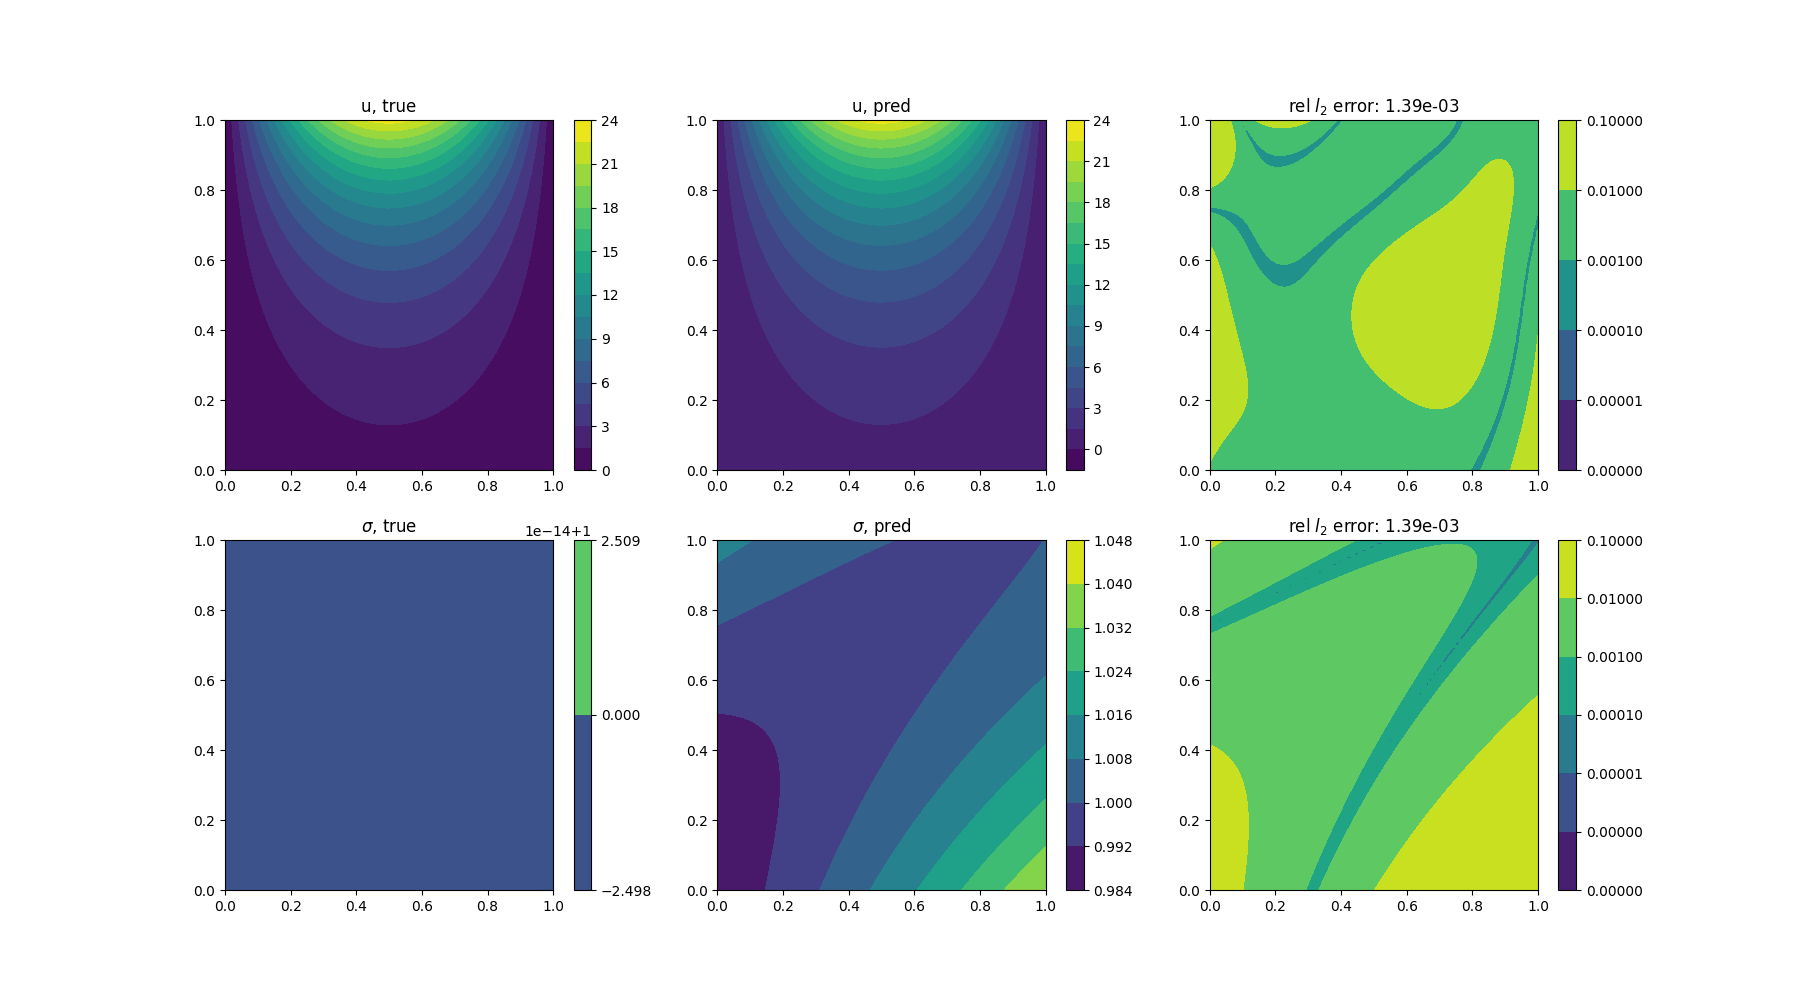

In [6]:
checkpoint_callback = trainer.callbacks[-1]
checkpoint = torch.load(checkpoint_callback.best_model_path)
pinn.load_state_dict(checkpoint["state_dict"])

x_test = torch.from_numpy(x_domain).to(pinn.device)
y_test = torch.from_numpy(y_domain).to(pinn.device)
u_test = u_fn(x_domain, y_domain).reshape((len(x_1d), len(y_1d))).T
sigma_test = np.ones_like(u_test)

with torch.no_grad():
	u_pred = pinn.forward(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
	sigma_pred = pinn.inverse_module(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
	
u_err = np.sqrt(np.mean((u_test - u_pred)**2))
u_norm = np.sqrt(np.mean(u_test**2))
sigma_err = np.sqrt(np.mean((sigma_test - sigma_pred)**2))
sigma_norm = np.sqrt(np.mean(sigma_test**2))

X, Y = np.meshgrid(x_1d, y_1d)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
cmap = mpl.cm.viridis
	
fig, axes = plt.subplots(2, 3, figsize = (18, 10))

c0 = axes[0][0].contourf(X, Y, u_test, cmap = cmap, levels = 20)
c1 = axes[0][1].contourf(X, Y, u_pred, cmap = cmap, levels = 20)
c2 = axes[0][2].contourf(X, Y, np.abs(u_test - u_pred), cmap = cmap, norm = mpl.colors.LogNorm())
c3 = axes[1][0].contourf(X, Y, sigma_test, cmap = cmap)
c4 = axes[1][1].contourf(X, Y, sigma_pred, cmap = cmap)
c5 = axes[1][2].contourf(X, Y, np.abs(sigma_test - sigma_pred), cmap = cmap, norm = mpl.colors.LogNorm())
 
for c, ax in zip([c0, c1, c2], axes[0]):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes[0], ["u, true", "u, pred", "rel $l_2$ error: {:.2e}".format(u_err/u_norm)]):
    ax.set_title(name)
	
for c, ax in zip([c3, c4, c5], axes[1]):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes[1], ["$\sigma$, true", "$\sigma$, pred", "rel $l_2$ error: {:.2e}".format(u_err/u_norm)]):
    ax.set_title(name)